In [1]:
#Revised notebook to load mat files from "mat_intermediate" to incorporate corrected genesis density,
#recalculate RMSE weighted by area, 
#incorporate Cartopy (possibly?) into maps (if I make them), 
#and (re)make some plots comparing errors across different experiments.

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io #For loading .mat file
from scipy.stats import iqr

In [3]:
from mpl_toolkits.basemap import Basemap

In [4]:
import cartopy

In [5]:
cartopy.__version__

'0.17.0'

In [6]:
#Load the mat files for final results (this was for original, non-corrected plots)
OBS_RMSEs = scipy.io.loadmat('mat_from_Jeff/OBS_RMSEs.mat')
OBS_RMSEsv2 = scipy.io.loadmat('mat_from_Jeff/OBS_RMSEsv2.mat')

SensTest_v1 = scipy.io.loadmat('mat_from_Jeff/JS_C180_ParamSensTest.mat')
SensTest_v2 = scipy.io.loadmat('mat_from_Jeff/JS_C180v2_ParamSensTest.mat')

#Non-normalized versions for V1-V2 comparison
NN_RMSEs = scipy.io.loadmat('mat_from_Jeff/JS_C180_ObsRMSEs_NonNormalized.mat')
NN_RMSEsv2 = scipy.io.loadmat('mat_from_Jeff/JS_C180v2_ObsRMSEs_NonNormalized.mat')

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/scipy/io/matlab/mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [7]:
#Load mat files for individual tests

In [8]:


#Names of tests and variables
tnames = ['20YearTest',
'Fe050',
'Fe200',
'Ds005',
'Ds007',
'Ds009',
'De004',
'De006',
'De008',
'Di006',
'Di007',
'Di008',
'Di009',
'Di010',
'Di011',
'Di012',
'Di013',
'Di014',
'Di015',
'Di016',
'Di017',
'Di018',
'Di019',
'Ec040',
'Ec050',
'Ec060',
'Ec070',
'Ec080',
'En010',
'En020',
'En030',
'En040',
'En050',
'En070',
'En080',
'En085',
'En090',
'En095',
'En097',
'En099',
'En090Ds005',
'En090Ds007',
'En090Ds009',
'En090De004',
'En090De006',
'En090De008',
'En090Di009',
'En090Di013',
'En090Di017',
'En090Ec040',
'En090Ec060',
'En090Ec080']

#Order the variables by what they were like in Jeff's matrix plot
vnames = [
    'GPCP_precip', 
    'CMAP_STD_precip',
    'CMAP_EHD_precip',  
    'ISCCP_cldOptDep', 
    'ERA_I_slp', 
    'ICOADS_slp', 
    'CRUTEM_STD_tsurf', 
    'CRUTEM_EHD_tsurf', 
    'CERES_lwTOA', 
    'CERES_swTOA', 
    'ERA_I_850u', 
    'ERA_I_850v', 
    'ERA_I_200u', 
    'ERA_I_200v', 
    'ERA_I_500z', 
    'ERA_I_zonT', 
    'ICOADS_uStress', 
    'ICOADS_vStress', 
    'ERA_I_zonU', 
    'ERA_I_zonV', 
    'ISCCP_OAFLUX_qnet', 
    'CERES_OAFLUX_qnet',
    'ERA_I_zonQ', 
    'NSIDC_snow',
    'IBTRACS_trackDen', 
    'IBTRACS_genDen'
]

In [9]:
#Dict of variable names in the models matching those for the observations
E3_vnames = {
    'GPCP_precip': 'PREC', 
    'CMAP_STD_precip': 'PREC',
    'CMAP_EHD_precip': 'PREC',
    'ISCCP_cldOptDep': 'OPTD', 
    'ERA_I_slp': 'SLP',
    'ICOADS_slp': 'SLP',
    'CRUTEM_STD_tsurf': 'TSURF',
    'CRUTEM_EHD_tsurf': 'TSURF',
    'CERES_lwTOA': 'OLR',
    'CERES_swTOA': 'OSR',
    'ERA_I_850u': 'U850',
    'ERA_I_850v': 'V850', 
    'ERA_I_200u': 'U200', 
    'ERA_I_200v': 'V200', 
    'ERA_I_500z': 'Z500', 
    'ERA_I_zonT': 'Tzon', 
    'ICOADS_uStress': 'TAU', #Why are these the same? Or does Tau have 2 components?
    'ICOADS_vStress': 'TAU',
    'ERA_I_zonU': 'Uzon', 
    'ERA_I_zonV': 'Vzon', 
    'ISCCP_OAFLUX_qnet': 'QNET', 
    'CERES_OAFLUX_qnet': 'QNET', 
    'ERA_I_zonQ': 'Qzon', 
    'NSIDC_snow': 'SNOW', 
    'IBTRACS_trackDen': 'TRACK',
    'IBTRACS_genDen': 'GEN'
}

In [10]:
# Function to load an individual mat file into a dict
# Note this is a "kludge" solution for the one missing test that should be all zeros, 
# and shouldn't be generalized. 
# (The test printed 0 so it should still work)
# vname: name of variable
def load_intermediate_mat(tname, vname, version=1):
    version_string = {1: 'JS_C180_ObsRMSEs_', 
                      2: 'JS_C180v2_ObsRMSEs_'}
    if vname == 'IBTRACS_genDen':
        if tname == 'En010':
            #No "corrected" file, load the uncorrected one (which should still be all zeros since track density should be 0 too)
            #(Unless a storm crossed over from one year to the next)
            mat_dict = scipy.io.loadmat('mat_intermediate/'+version_string[version]+tname+'_'+vname+'.mat')
            print('Loaded uncorrected genesis density for case with 0 TCs. Should still still be 0 because')
            print('this was the track density times 4, and if no TC genesis should be no tracks either. Max of the variable is:')
            print(np.max(mat_dict[E3_vnames[vname]])) #Make sure it is actually still 0 based on track
        else:
            mat_dict = scipy.io.loadmat('mat_intermediate/'+version_string[version]+tname+'_'+vname+'_corrected.mat')
    else:
        mat_dict = scipy.io.loadmat('mat_intermediate/'+version_string[version]+tname+'_'+vname+'.mat')
    return mat_dict

In [11]:
# Wrapper function to construct an XArray dataset from the above
def load_mat_to_dataset(tname, vname, version=1):
    mat_dict = load_intermediate_mat(tname, vname, version=version)
    if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']: #LAT_O, LEV_O dimensions
        lat = mat_dict['LAT_O'][:,0]
        lev = mat_dict['LEV_O'][0,:]
        #print(lat)
        #print(lev)
        model_array = xr.DataArray(mat_dict[E3_vnames[vname]], 
                                   coords={'lat': lat, 
                                           'lev': lev},  
                                   dims=['lat', 'lev'], 
                                   name=E3_vnames[vname])
        obs_array = xr.DataArray(mat_dict[vname], 
                                 coords={'lat': lat, 
                                         'lev': lev},  
                                 dims=['lat', 'lev'], 
                                 name=vname)
    elif vname in ['IBTRACS_trackDen', 'IBTRACS_genDen']: #Put in lat, lon manually. 
        #Should've saved "IBTRACS_lon", "IBTRACS_lat" variables. But, they were rearranged to be
        #ocean-centric: 335W-25E
        #How does this fit into -180 to 180 or 0 to 360 longitudes?
        lat = np.linspace(-89.5, 89.5, 180)
        lon = np.linspace(-334.5, 24.5, 360)
        model_array = xr.DataArray(mat_dict[E3_vnames[vname]], 
                                   coords={'lon': lon, 
                                           'lat': lat},  
                                   dims=['lon', 'lat'], 
                                   name=E3_vnames[vname])
        obs_array = xr.DataArray(mat_dict[vname], 
                                 coords={'lon': lon, 
                                         'lat': lat},  
                                 dims=['lon', 'lat'], 
                                 name=vname)
    elif vname == 'NSIDC_snow': #Downsample lat/lon to every 10th
        lat = mat_dict['LAT_O'][0,4:3600:10]+0.025
        lon = mat_dict['LON_O'][4:7200:10,0]+0.025
        print('about to make snow arrays')
        model_array = xr.DataArray(mat_dict[E3_vnames[vname]], 
                                   coords={'lon': lon, 
                                           'lat': lat},  
                                   dims=['lon', 'lat'], 
                                   name=E3_vnames[vname])
        obs_array = xr.DataArray(mat_dict[vname], 
                                 coords={'lon': lon, 
                                         'lat': lat},  
                                 dims=['lon', 'lat'], 
                                 name=vname)
        print('made snow arrays')
    else: #LAT_O, LON_O dimensions
        lat = mat_dict['LAT_O'][0,:]
        lon = mat_dict['LON_O'][:,0]
        #print(lat)
        #print(lon)
        model_array = xr.DataArray(mat_dict[E3_vnames[vname]], 
                                   coords={'lon': lon, 
                                           'lat': lat},  
                                   dims=['lon', 'lat'], 
                                   name=E3_vnames[vname])
        obs_array = xr.DataArray(mat_dict[vname], 
                                 coords={'lon': lon, 
                                         'lat': lat},  
                                 dims=['lon', 'lat'], 
                                 name=vname)
    ds_merged = xr.merge([model_array, obs_array])
    return ds_merged

In [12]:
#2nd wrapper function to run the above for all of the tests, and concatenate into an XArray dataset along the test dimension
def mat_to_dataset_all_tests(tnames, vname, version=1):
    ds_dict = dict()
    for tname in tnames:
        #print('Loading mat files for test: ' + tname)
        ds_dict[tname] = load_mat_to_dataset(tname, vname, version=version)
    ds_concat = xr.concat(ds_dict.values(), dim=pd.Index(tnames, name='tname'))
    return ds_concat

In [13]:
#Test this with the genesis density

In [14]:
test_td = mat_to_dataset_all_tests(tnames, 'IBTRACS_genDen')

Loaded uncorrected genesis density for case with 0 TCs. Should still still be 0 because
this was the track density times 4, and if no TC genesis should be no tracks either. Max of the variable is:
0


In [15]:
#OK, test printed 0 so it seems this stil worked. 
#Now run this for all of the cases, then re-run the map plots.

In [16]:

mat_ds_dict = dict()
for v in vnames:
    print('Loading mat files for variable: ' + v)
    mat_ds_dict[v] = mat_to_dataset_all_tests(tnames, v)

Loading mat files for variable: GPCP_precip
Loading mat files for variable: CMAP_STD_precip
Loading mat files for variable: CMAP_EHD_precip
Loading mat files for variable: ISCCP_cldOptDep
Loading mat files for variable: ERA_I_slp
Loading mat files for variable: ICOADS_slp
Loading mat files for variable: CRUTEM_STD_tsurf
Loading mat files for variable: CRUTEM_EHD_tsurf
Loading mat files for variable: CERES_lwTOA
Loading mat files for variable: CERES_swTOA
Loading mat files for variable: ERA_I_850u
Loading mat files for variable: ERA_I_850v
Loading mat files for variable: ERA_I_200u
Loading mat files for variable: ERA_I_200v
Loading mat files for variable: ERA_I_500z
Loading mat files for variable: ERA_I_zonT
Loading mat files for variable: ICOADS_uStress
Loading mat files for variable: ICOADS_vStress
Loading mat files for variable: ERA_I_zonU
Loading mat files for variable: ERA_I_zonV
Loading mat files for variable: ISCCP_OAFLUX_qnet
Loading mat files for variable: CERES_OAFLUX_qnet
Loa

In [17]:

#####   Calculate Error Diagnostics   #####


In [18]:
#Calculate error metrics in loop through the dict
#(What is there besides RMSE, latitude weighted or not?)
#(Only other thing I can think of is difference in global means)
#(Otherwise, positive and negative errors in different places will cancel)

In [19]:
print(mat_ds_dict['GPCP_precip'])

<xarray.Dataset>
Dimensions:      (lat: 72, lon: 144, tname: 52)
Coordinates:
  * lon          (lon) float32 -333.8 -331.2 -328.8 -326.2 ... 18.75 21.25 23.75
  * lat          (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * tname        (tname) object '20YearTest' 'Fe050' ... 'En090Ec080'
Data variables:
    PREC         (tname, lon, lat) float64 0.1608 0.1116 ... 0.7701 0.7825
    GPCP_precip  (tname, lon, lat) float64 0.2575 0.162 0.1062 ... 0.4763 0.4936


In [20]:
#Maybe the vertically varying quantities should be pressure weighted as well. 
#But how far should we go down this rabbit hole? 

In [21]:
#Latitude issue: print all the latitudes for each key
#(This wasn't the problem, had nothing to do with which results had problems)
#for vname in vnames:
#    print('Latitude coordinate for variable: ' + vname)
#    print(mat_ds_dict[vname].lat)

In [22]:
#Calculation of error 
# for vname in mat_ds_dict.keys():
#     print('Calculating error diagnostics for: ' + vname)
    
#     #Calculate RMSE -- non latitude weighted
#     mod_data = mat_ds_dict[vname][E3_vnames[vname]]
#     print(mod_data)
#     obs_data = mat_ds_dict[vname][vname]
#     print(obs_data)
#     raw_error = mod_data - obs_data
#     print(raw_error)
#     #Take mean across the lon (or lev) and lat dimensions but not tname dimension 
#     if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']:
#         mean_squared_error = (raw_error*raw_error).mean(dim=['lev', 'lat'])
#     else:
#         mean_squared_error = (raw_error*raw_error).mean(dim=['lon', 'lat'])
#     RMSE_unweighted = np.sqrt(mean_squared_error)
#     mat_ds_dict[vname]['RMSE_unweighted'] = RMSE_unweighted
    
#     #Latitude weighted RMSE and global mean difference: do later
    
#     #Calculate RMSE -- latitude weighted
#     lat_weights = np.cos(mat_ds_dict[vname]['lat']*np.pi/180.)
#     sum_weights = np.sum(lat_weights)
#     #print(sum_weights)
#     dot_product = (raw_error*raw_error).dot(lat_weights) #Multiplies along shared dimension and takes sum
#     print(dot_product)
#     #Take zonal or vertical mean (vertical pressure weighting with different heights would be hard)
#     if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']:
#         vertical_mean = dot_product.mean(dim='lev')
#         RMSE_weighted = np.sqrt(vertical_mean/sum_weights)
#     else:
#         zonal_mean = dot_product.mean(dim='lon')
#         RMSE_weighted = np.sqrt(zonal_mean/sum_weights)
#     print(RMSE_weighted)
#     mat_ds_dict[vname]['RMSE_weighted'] = RMSE_weighted
    
#     #Calculate global means of the modeled and observed quantity and their difference
#     if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']:
#         gm_mod = (mod_data.dot(lat_weights)).mean(dim='lev')/sum_weights
#         gm_obs = (obs_data.dot(lat_weights)).mean(dim='lev')/sum_weights
#     else:
#         gm_mod = (mod_data.dot(lat_weights)).mean(dim='lon')/sum_weights
#         gm_obs = (obs_data.dot(lat_weights)).mean(dim='lon')/sum_weights
#     diff_global_means = gm_mod - gm_obs
#     mat_ds_dict[vname]['gm_mod'] = gm_mod
#     mat_ds_dict[vname]['gm_obs'] = gm_obs
#     mat_ds_dict[vname]['diff_global_means'] = diff_global_means
    

In [23]:
#Attempt to calculate mean error by dimensions separately like Jeff did, to see if I now get same results as him
for vname in mat_ds_dict.keys():
    print('Calculating error diagnostics (mean dimensions separately) for: ' + vname)
    
    #Calculate RMSE -- non latitude weighted
    mod_data = mat_ds_dict[vname][E3_vnames[vname]]
    obs_data = mat_ds_dict[vname][vname]
    raw_error = mod_data - obs_data
    #print(raw_error) 
    #print(raw_error.mean(dim='lat'))
    #print(raw_error.mean(dim='lat').mean(dim='lon')) #OK, this should still work --there are no nans!
    #Take mean across the lon (or lev) and lat dimensions but not tname dimension 
    if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']:
        mean_squared_error = (raw_error*raw_error).mean(dim='lev').mean(dim='lat')
    else:
        mean_squared_error = (raw_error*raw_error).mean(dim='lon').mean(dim='lat')
    #print(mean_squared_error)
    RMSE_unweighted = np.sqrt(mean_squared_error)
    mat_ds_dict[vname]['RMSE_unweighted_mean_separate'] = RMSE_unweighted

Calculating error diagnostics (mean dimensions separately) for: GPCP_precip
Calculating error diagnostics (mean dimensions separately) for: CMAP_STD_precip
Calculating error diagnostics (mean dimensions separately) for: CMAP_EHD_precip
Calculating error diagnostics (mean dimensions separately) for: ISCCP_cldOptDep
Calculating error diagnostics (mean dimensions separately) for: ERA_I_slp
Calculating error diagnostics (mean dimensions separately) for: ICOADS_slp
Calculating error diagnostics (mean dimensions separately) for: CRUTEM_STD_tsurf
Calculating error diagnostics (mean dimensions separately) for: CRUTEM_EHD_tsurf
Calculating error diagnostics (mean dimensions separately) for: CERES_lwTOA
Calculating error diagnostics (mean dimensions separately) for: CERES_swTOA
Calculating error diagnostics (mean dimensions separately) for: ERA_I_850u
Calculating error diagnostics (mean dimensions separately) for: ERA_I_850v
Calculating error diagnostics (mean dimensions separately) for: ERA_I_2

In [24]:
#Version calculating mean across both dimensions at once
#(different from what Jeff did but )
for vname in mat_ds_dict.keys():
    print('Calculating error diagnostics for: ' + vname)
    
    #Calculate RMSE -- non latitude weighted
    mod_data = mat_ds_dict[vname][E3_vnames[vname]]
    obs_data = mat_ds_dict[vname][vname]
    raw_error = mod_data - obs_data
    #Take mean across the lon (or lev) and lat dimensions but not tname dimension 
    if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']:
        mean_squared_error = (raw_error*raw_error).mean(dim=['lev', 'lat'])
    else:
        mean_squared_error = (raw_error*raw_error).mean(dim=['lon', 'lat'])
    RMSE_unweighted = np.sqrt(mean_squared_error)
    mat_ds_dict[vname]['RMSE_unweighted'] = RMSE_unweighted
    
#     #Latitude weighted RMSE and global mean difference: do later
#     #Challenge is to account for both missing values and weighting by area.
#     #Need to create a 2D latitude weight matrix, multiply by 0 where the data is missing,
#     #Multiply the data (with nans) by the weights, take sum and divide by 2D sum of the masked weights.
#     #Remember also have pressure weighting issue for vertical. So maybe don't bother with this yet?
    
    #Calculate RMSE -- latitude weighted
    lat_weights = np.cos(mat_ds_dict[vname]['lat']*np.pi/180.)
    #grid_shape = np.shape(mat_ds_dict[vname][vname].isel(tname=0).data)
    #print(grid_shape)
    ones_grid = mat_ds_dict[vname][vname].isel(tname=0).fillna(0)*0+1.0 #Create grid of ones that's an xarray
    weight_grid = ones_grid*lat_weights
    weight_grid_masked = weight_grid*np.logical_not(np.isnan(raw_error))
    #print(weight_grid_masked)
    squared_error_times_weights = raw_error*raw_error*weight_grid_masked
    dot_product = (raw_error*raw_error).dot(lat_weights) 
    if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']:
        sum_squared_error_weighted = squared_error_times_weights.sum(dim=['lev', 'lat'])
        sum_weights_masked = weight_grid_masked.sum(dim=['lev', 'lat'])
    else:
        sum_squared_error_weighted = squared_error_times_weights.sum(dim=['lon', 'lat'])
        sum_weights_masked = weight_grid_masked.sum(dim=['lon', 'lat'])
    RMSE_weighted = np.sqrt(sum_squared_error_weighted/sum_weights_masked)
    mat_ds_dict[vname]['RMSE_weighted'] = RMSE_weighted
    
    #Calculate global means of the modeled and observed quantity and their difference
    if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']:
        gm_mod = (mod_data*weight_grid_masked).sum(dim=['lev', 'lat'])/sum_weights_masked
        gm_obs = (obs_data*weight_grid_masked).sum(dim=['lev', 'lat'])/sum_weights_masked
    else:
        gm_mod = (mod_data*weight_grid_masked).sum(dim=['lon', 'lat'])/sum_weights_masked
        gm_obs = (obs_data*weight_grid_masked).sum(dim=['lon', 'lat'])/sum_weights_masked
    diff_global_means = gm_mod - gm_obs
    mat_ds_dict[vname]['gm_mod'] = gm_mod
    mat_ds_dict[vname]['gm_obs'] = gm_obs
    mat_ds_dict[vname]['diff_global_means'] = diff_global_means

Calculating error diagnostics for: GPCP_precip
Calculating error diagnostics for: CMAP_STD_precip
Calculating error diagnostics for: CMAP_EHD_precip
Calculating error diagnostics for: ISCCP_cldOptDep
Calculating error diagnostics for: ERA_I_slp
Calculating error diagnostics for: ICOADS_slp
Calculating error diagnostics for: CRUTEM_STD_tsurf
Calculating error diagnostics for: CRUTEM_EHD_tsurf
Calculating error diagnostics for: CERES_lwTOA
Calculating error diagnostics for: CERES_swTOA
Calculating error diagnostics for: ERA_I_850u
Calculating error diagnostics for: ERA_I_850v
Calculating error diagnostics for: ERA_I_200u
Calculating error diagnostics for: ERA_I_200v
Calculating error diagnostics for: ERA_I_500z
Calculating error diagnostics for: ERA_I_zonT
Calculating error diagnostics for: ICOADS_uStress
Calculating error diagnostics for: ICOADS_vStress
Calculating error diagnostics for: ERA_I_zonU
Calculating error diagnostics for: ERA_I_zonV
Calculating error diagnostics for: ISCCP_OA

In [25]:
#Create matrices for these standard errors across the dicts



In [26]:
print(mat_ds_dict['CERES_lwTOA'])

<xarray.Dataset>
Dimensions:                        (lat: 180, lon: 360, tname: 52)
Coordinates:
  * lon                            (lon) float32 -334.5 -333.5 ... 23.5 24.5
  * lat                            (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
  * tname                          (tname) object '20YearTest' ... 'En090Ec080'
Data variables:
    OLR                            (tname, lon, lat) float64 152.1 ... 198.9
    CERES_lwTOA                    (tname, lon, lat) float64 141.2 ... 194.1
    RMSE_unweighted_mean_separate  (tname) float64 11.74 11.33 ... 9.116 9.124
    RMSE_unweighted                (tname) float64 11.74 11.33 ... 9.116 9.124
    RMSE_weighted                  (tname) float64 13.76 13.19 ... 10.59 10.4
    gm_mod                         (tname) float64 233.7 233.6 ... 234.8 235.2
    gm_obs                         (tname) float64 240.3 240.3 ... 240.3 240.3
    diff_global_means              (tname) float64 -6.567 -6.662 ... -5.089


In [27]:
mat_RMSE_u = np.zeros([len(vnames), len(tnames)])
mat_RMSE_w = np.zeros([len(vnames), len(tnames)])
mat_RMSE_gm_mod = np.zeros([len(vnames), len(tnames)])
mat_RMSE_gm_obs = np.zeros([len(vnames), len(tnames)])
mat_RMSE_dgm = np.zeros([len(vnames), len(tnames)])
i = 0
for vname in vnames:
    mat_RMSE_u[i,:] = mat_ds_dict[vname]['RMSE_unweighted']
    mat_RMSE_w[i,:] = mat_ds_dict[vname]['RMSE_weighted']
    mat_RMSE_gm_mod[i,:] = mat_ds_dict[vname]['gm_mod']
    mat_RMSE_gm_mod[i,:] = mat_ds_dict[vname]['gm_mod']
    mat_RMSE_dgm[i,:] = mat_ds_dict[vname]['diff_global_means']
    i = i + 1

In [28]:
mat_RMSE_u_separate = np.zeros([len(vnames), len(tnames)])
i = 0
for vname in vnames:
    mat_RMSE_u_separate[i,:] = mat_ds_dict[vname]['RMSE_unweighted_mean_separate']
    i = i + 1

In [29]:
#Convert these to XArray arrays for the normalization? Or just deal with dimensions I know, just 2

In [30]:
#Normalize by IQR and subtract median (for unweighted, weighted, global mean diff.)
def norm_IQR_median(mat_2D):
    row_IQR = iqr(mat_2D, axis=1)
    div_IQR = mat_2D/row_IQR[:,None]
    med_divIQR = np.median(div_IQR, axis=1)
    norm_mat = div_IQR - med_divIQR[:,None]
    return norm_mat

In [31]:
#Alternative normalization: subtract median first, THEN divide by IQR
#(Does this matter?)
#Example: 3, 5, 7, 9, 12: IQR = 4
#Divide by IQR first: .75, 1.25, 1.75, 2.25, 3
#                     -1, 0.5, 0, .5, 1.25

#Subtract median first: 
# -4, -2, 0, 2, 5
#-1, -.5, 0, .5, 1.25 

#OK, same answer 
#So don't need to do this.

In [32]:
norm_RMSE_u_separate = norm_IQR_median(mat_RMSE_u_separate)

In [33]:
norm_RMSE_u = norm_IQR_median(mat_RMSE_u)

In [34]:
norm_RMSE_w = norm_IQR_median(mat_RMSE_w)
#Note, normalizing the global mean differences this way doesn't make sense. 
#Just plot the absolue difference from global mean (divided by mean absolute value?)

In [35]:
def norm_med_abs(mat_2D):
    row_med_abs = np.median(np.abs(mat_2D), axis=1)
    return mat_2D / row_med_abs[:,None]

In [36]:
#Normalize the global mean differences by instead dividing by mean absolute value
norm_dgm = norm_med_abs(mat_RMSE_dgm)

In [37]:

#####   PLOTS   #####


In [38]:
#Make the revised matrix plots here (test plots below)

In [39]:
#Shortened plot label strings

#Shortened versions, showing actual numbers used
fnums = ['Default',
'50',
'200',
'.05',
'.07',
'.09',
'.04',
'.06',
'.08',
'.06',
'.07',
'.08',
'.09',
'.10',
'.11',
'.12',
'.13',
'.14',
'.15',
'.16',
'.17',
'.18',
'.19',
'.40',
'.50',
'.60',
'.70',
'.80',
'.10',
'.20',
'.30',
'.40',
'.50',
'.70',
'.80',
'.85',
'.90',
'.95',
'.97',
'.99',
'.05',
'.07',
'.09',
'.04',
'.06',
'.08',
'.09',
'.13',
'.17',
'.40',
'.60',
'.80']

onames = ['Pr. (GP)', 
          'Pr. (C1)', 
          'Pr. (C2)', 
          '$\\tau_{\mathrm{cld}}$', 
          'SLP (1)', 
          'SLP (2)', 
          '$T_s$ (1)', 
          '$T_s$ (2)', 
          'OLR', 
          'OSR', 
          '$u_{850}$',
          '$v_{850}$', 
          '$u_{200}$', 
          '$v_{200}$', 
          '$z_{g,500}$', 
          '[$T_a$]', 
          '$\\tau_{u,\mathrm{sfc.}}$',
          '$\\tau_{v,\mathrm{sfc.}}$',
          '[$u$]',
          '[$v$]', 
          '$Q_\mathrm{net,surf.}$ (1)', 
          '$Q_\mathrm{net,surf.}$ (2)', 
          '[$q$]', 
          'Snow Frac.', 
          'Track Dens.', 
          'Gen. Dens.']

[[ 0.43580843 -0.40198198 -0.42884505 ...  1.14640998  0.43187051
   1.96327532]
 [ 0.37641408  0.20228032 -0.50989334 ...  1.30128753 -0.9855813
   0.89818034]
 [ 1.14982138 -0.47463157 -0.73547355 ... -0.20481646 -0.10372193
   1.2049815 ]
 ...
 [ 1.09251156 -0.74547329 -0.64331419 ...  0.60921568  0.52506308
   0.96883836]
 [ 1.19870001 -0.77130492 -0.69636611 ...  0.51234982  0.47834028
   0.94234   ]
 [ 0.89919757 -0.75725358 -0.6187258  ...  0.61207422  0.49999757
   0.95559561]]
[ 0.43580843  0.37641408  1.14982138  0.01412064 -0.55640179 -0.51205548
  1.03285725  0.65267013 -0.41459829  0.04142933  0.13908359  0.22987292
 -0.1961174   0.85053178  0.04570877  0.59082949  0.03469051  0.11727608
  0.09609588  0.09563045  0.63255841  0.8633906  -0.15302486  1.09251156
  1.19870001  0.89919757]


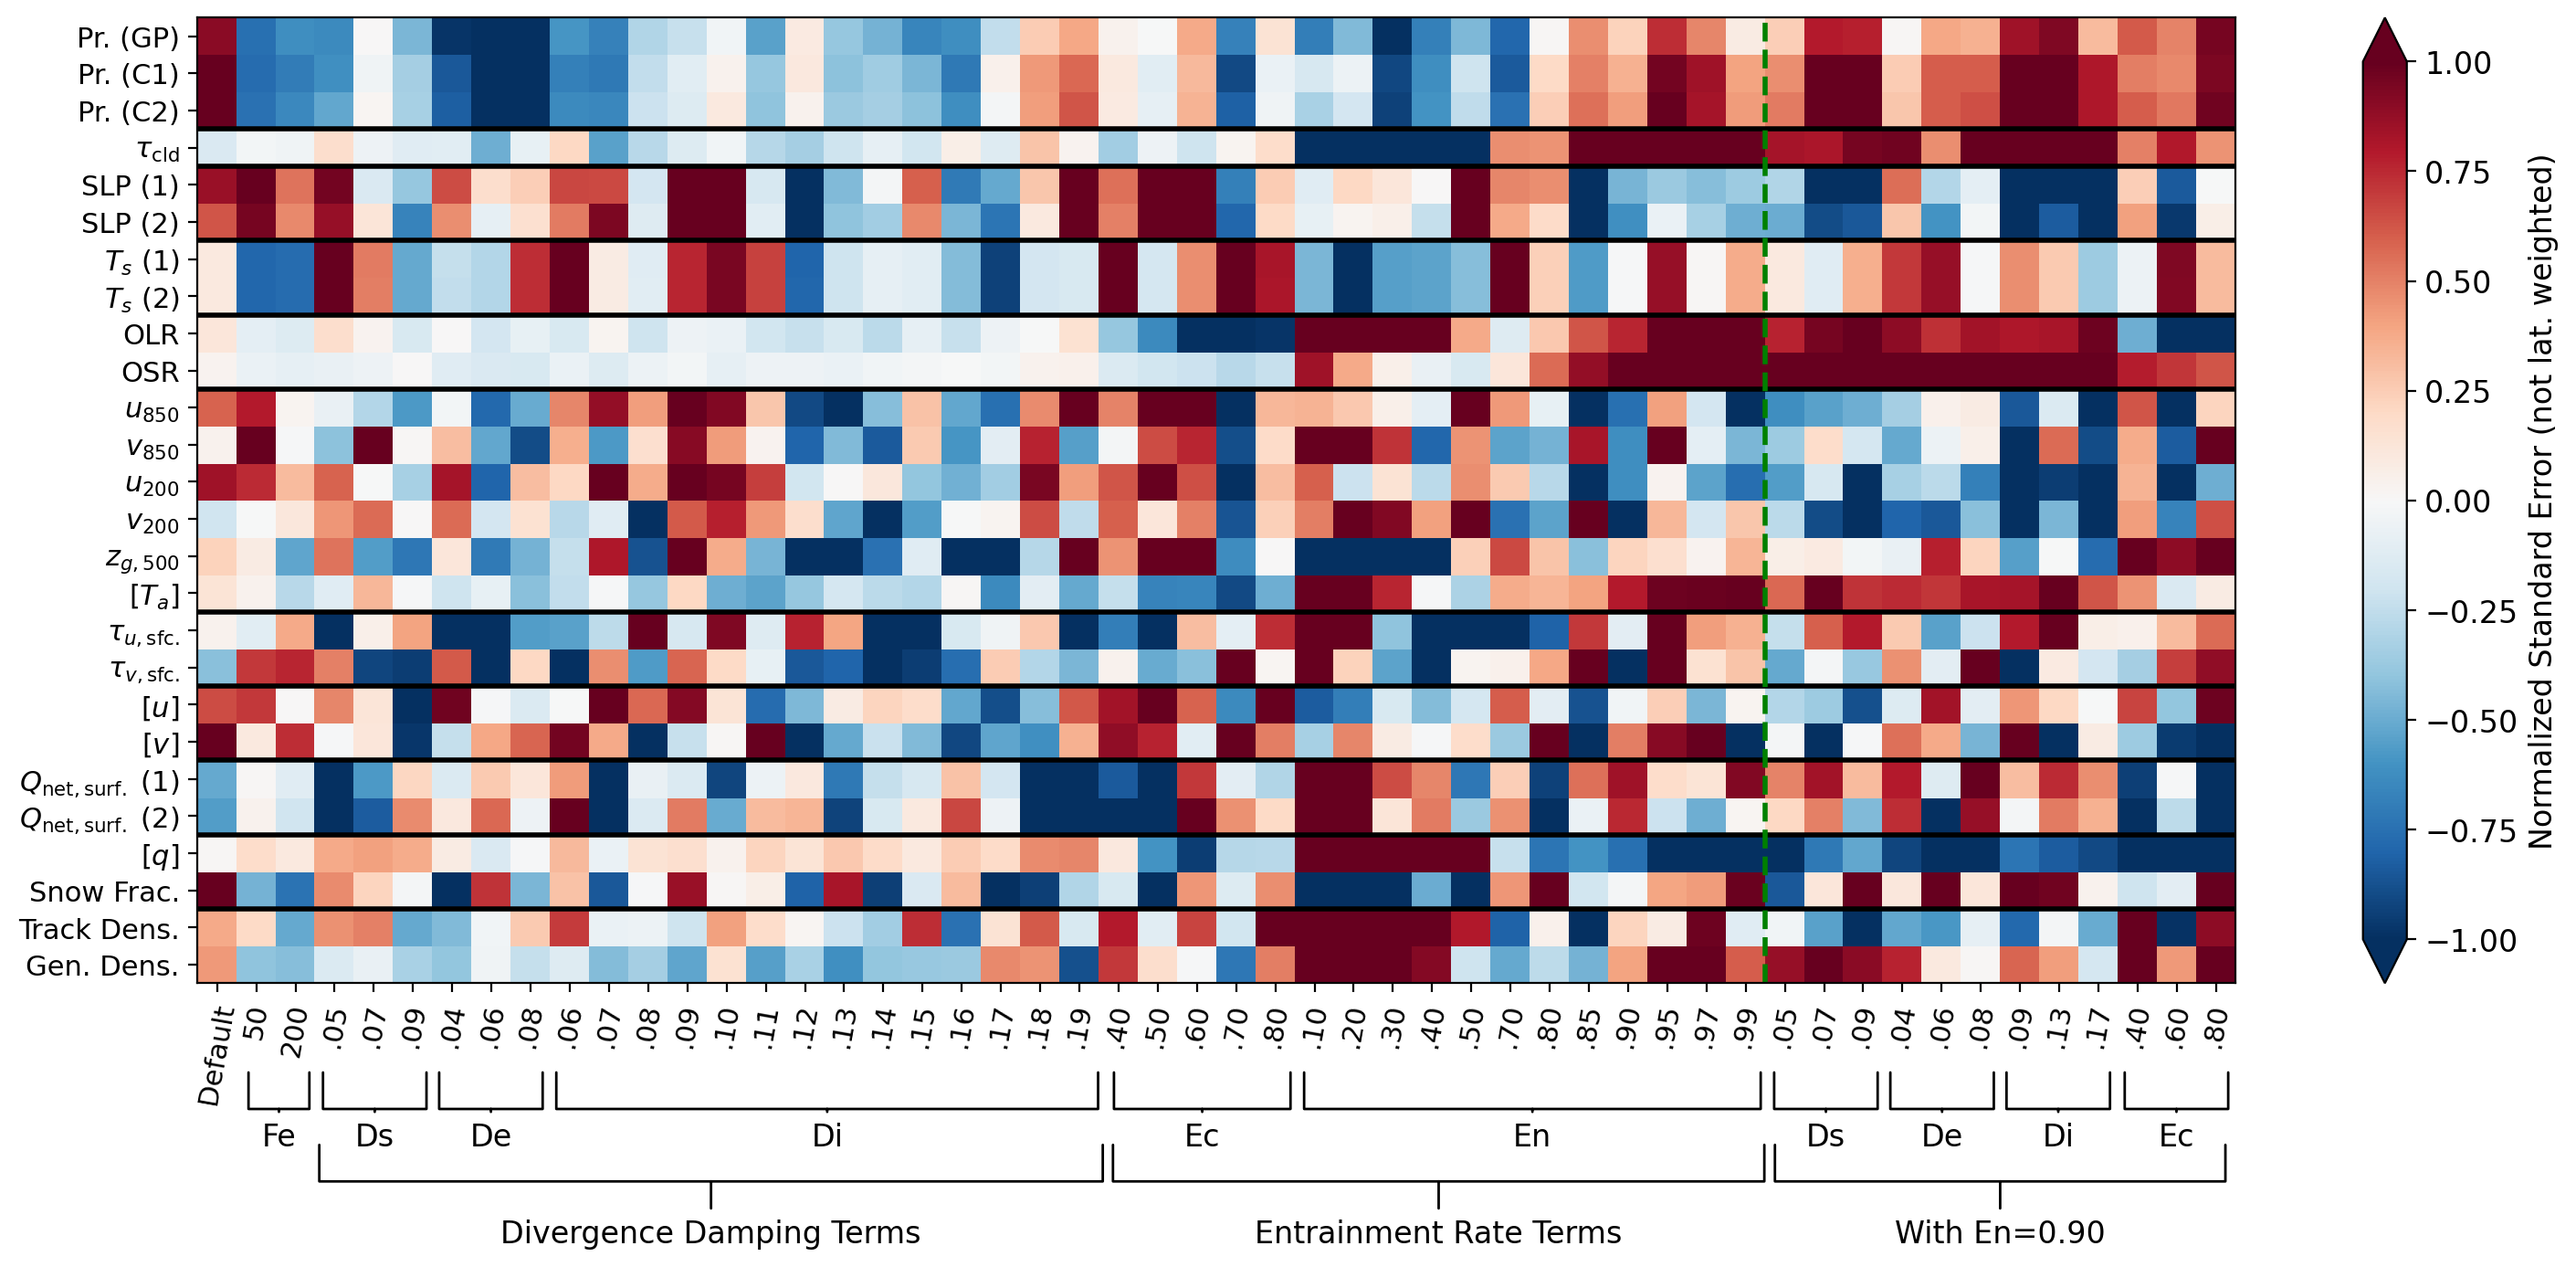

In [60]:
#Unweighted global mean with mean on separate dimensions, latitude last (like Jeff did)
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_RMSE_u_separate)
print(plotmat)
print(plotmat[:,0])
plt.pcolor(plotmat, cmap = plt.cm.RdBu_r, 
           vmin=-1, vmax=1)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized Standard Error (not lat. weighted)', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/RMSE_matrix_V1_unweighted_mean_separate.png', bbox_inches='tight')
plt.savefig('plots/RMSE_matrix_V1_unweighted_mean_separate.pdf', bbox_inches='tight')

#This version, taking nanmean on dimensions separately with lat last, completely reproduces Jeff's plot!

[[ 0.43580843 -0.40198198 -0.42884505 ...  1.14640998  0.43187051
   1.96327532]
 [ 0.37641408  0.20228032 -0.50989334 ...  1.30128753 -0.9855813
   0.89818034]
 [ 2.50287826  0.01278532 -0.39793811 ...  0.95902913 -1.10839432
   1.63404902]
 ...
 [ 1.09251156 -0.74547329 -0.64331419 ...  0.60921568  0.52506308
   0.96883836]
 [ 1.19282638 -0.77399885 -0.69405631 ...  0.51296003  0.477783
   0.94533172]
 [ 0.89919757 -0.75725358 -0.6187258  ...  0.61207422  0.49999757
   0.95559561]]
[ 0.43580843  0.37641408  2.50287826  0.01445859  0.1110474  -0.23494717
  1.01822685  0.6559314  -0.85567493 -0.15998364  0.1146025   0.22987292
 -0.1961174   0.85053178  0.09890898  0.64198521  0.03469051  0.11727608
  0.35902639  0.35947379  0.57525883  0.99909433 -0.15302486  1.09251156
  1.19282638  0.89919757]


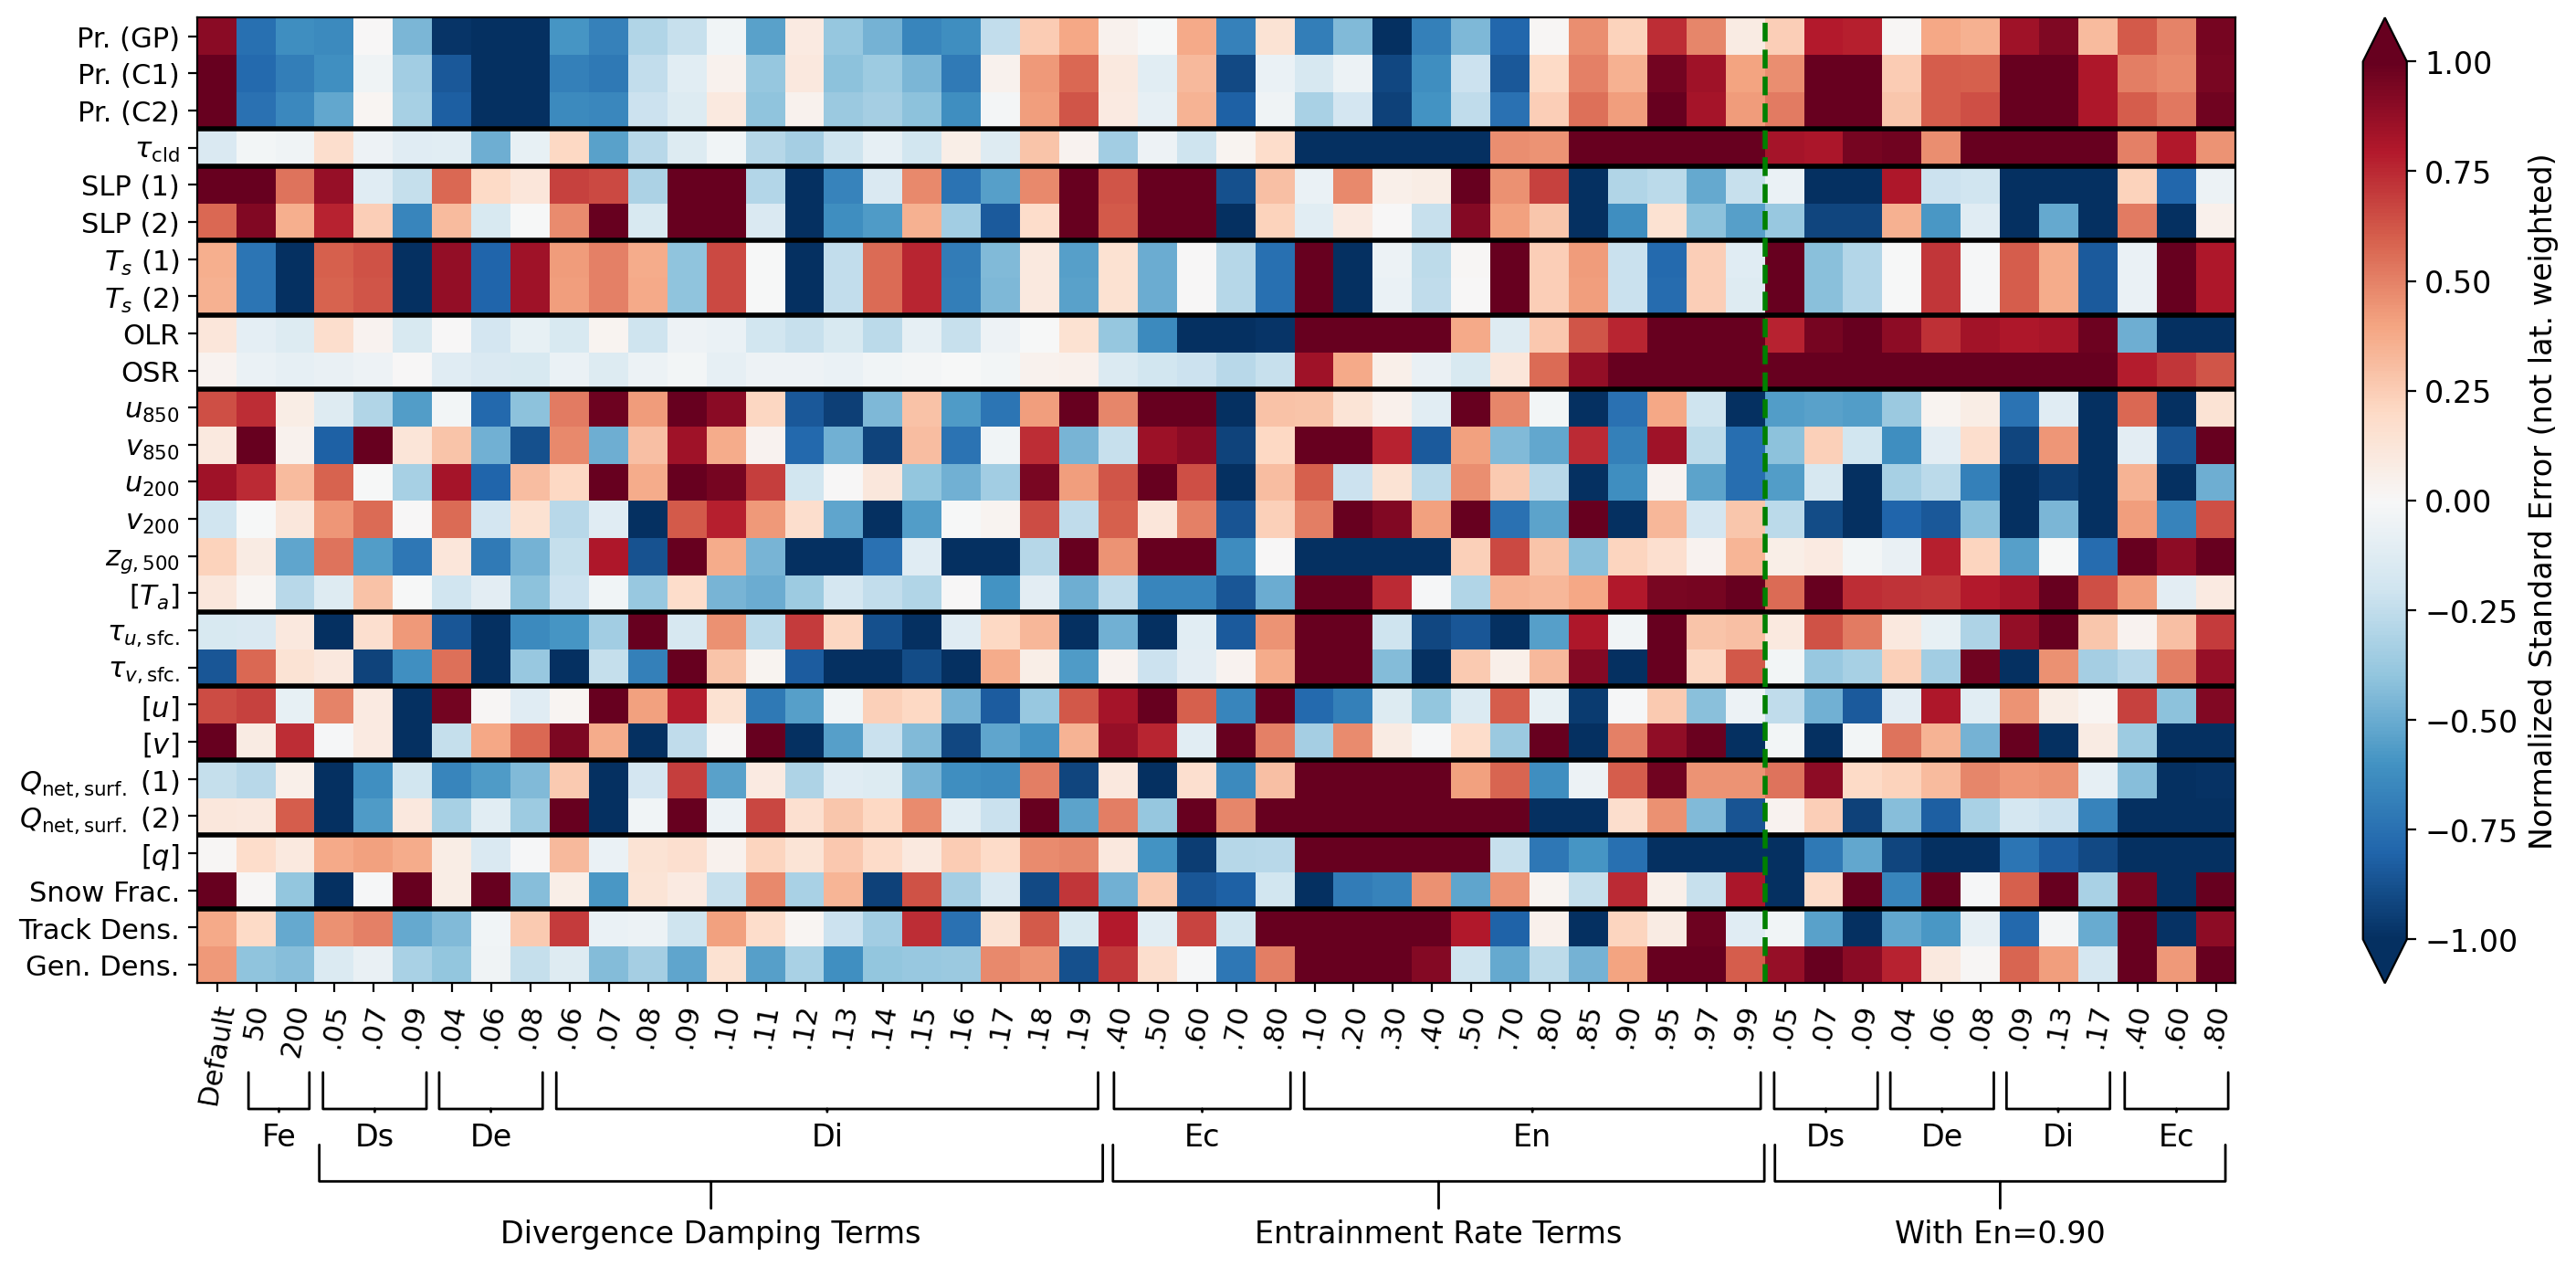

In [75]:
#Unweighted global mean with mean on elements all at once, excluding nans
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_RMSE_u)
print(plotmat)
print(plotmat[:,0])
plt.pcolor(plotmat, cmap = plt.cm.RdBu_r, 
           vmin=-1, vmax=1)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized Standard Error (not lat. weighted)', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/RMSE_matrix_V1_unweighted.png', bbox_inches='tight')
plt.savefig('plots/RMSE_matrix_V1_unweighted.pdf', bbox_inches='tight')

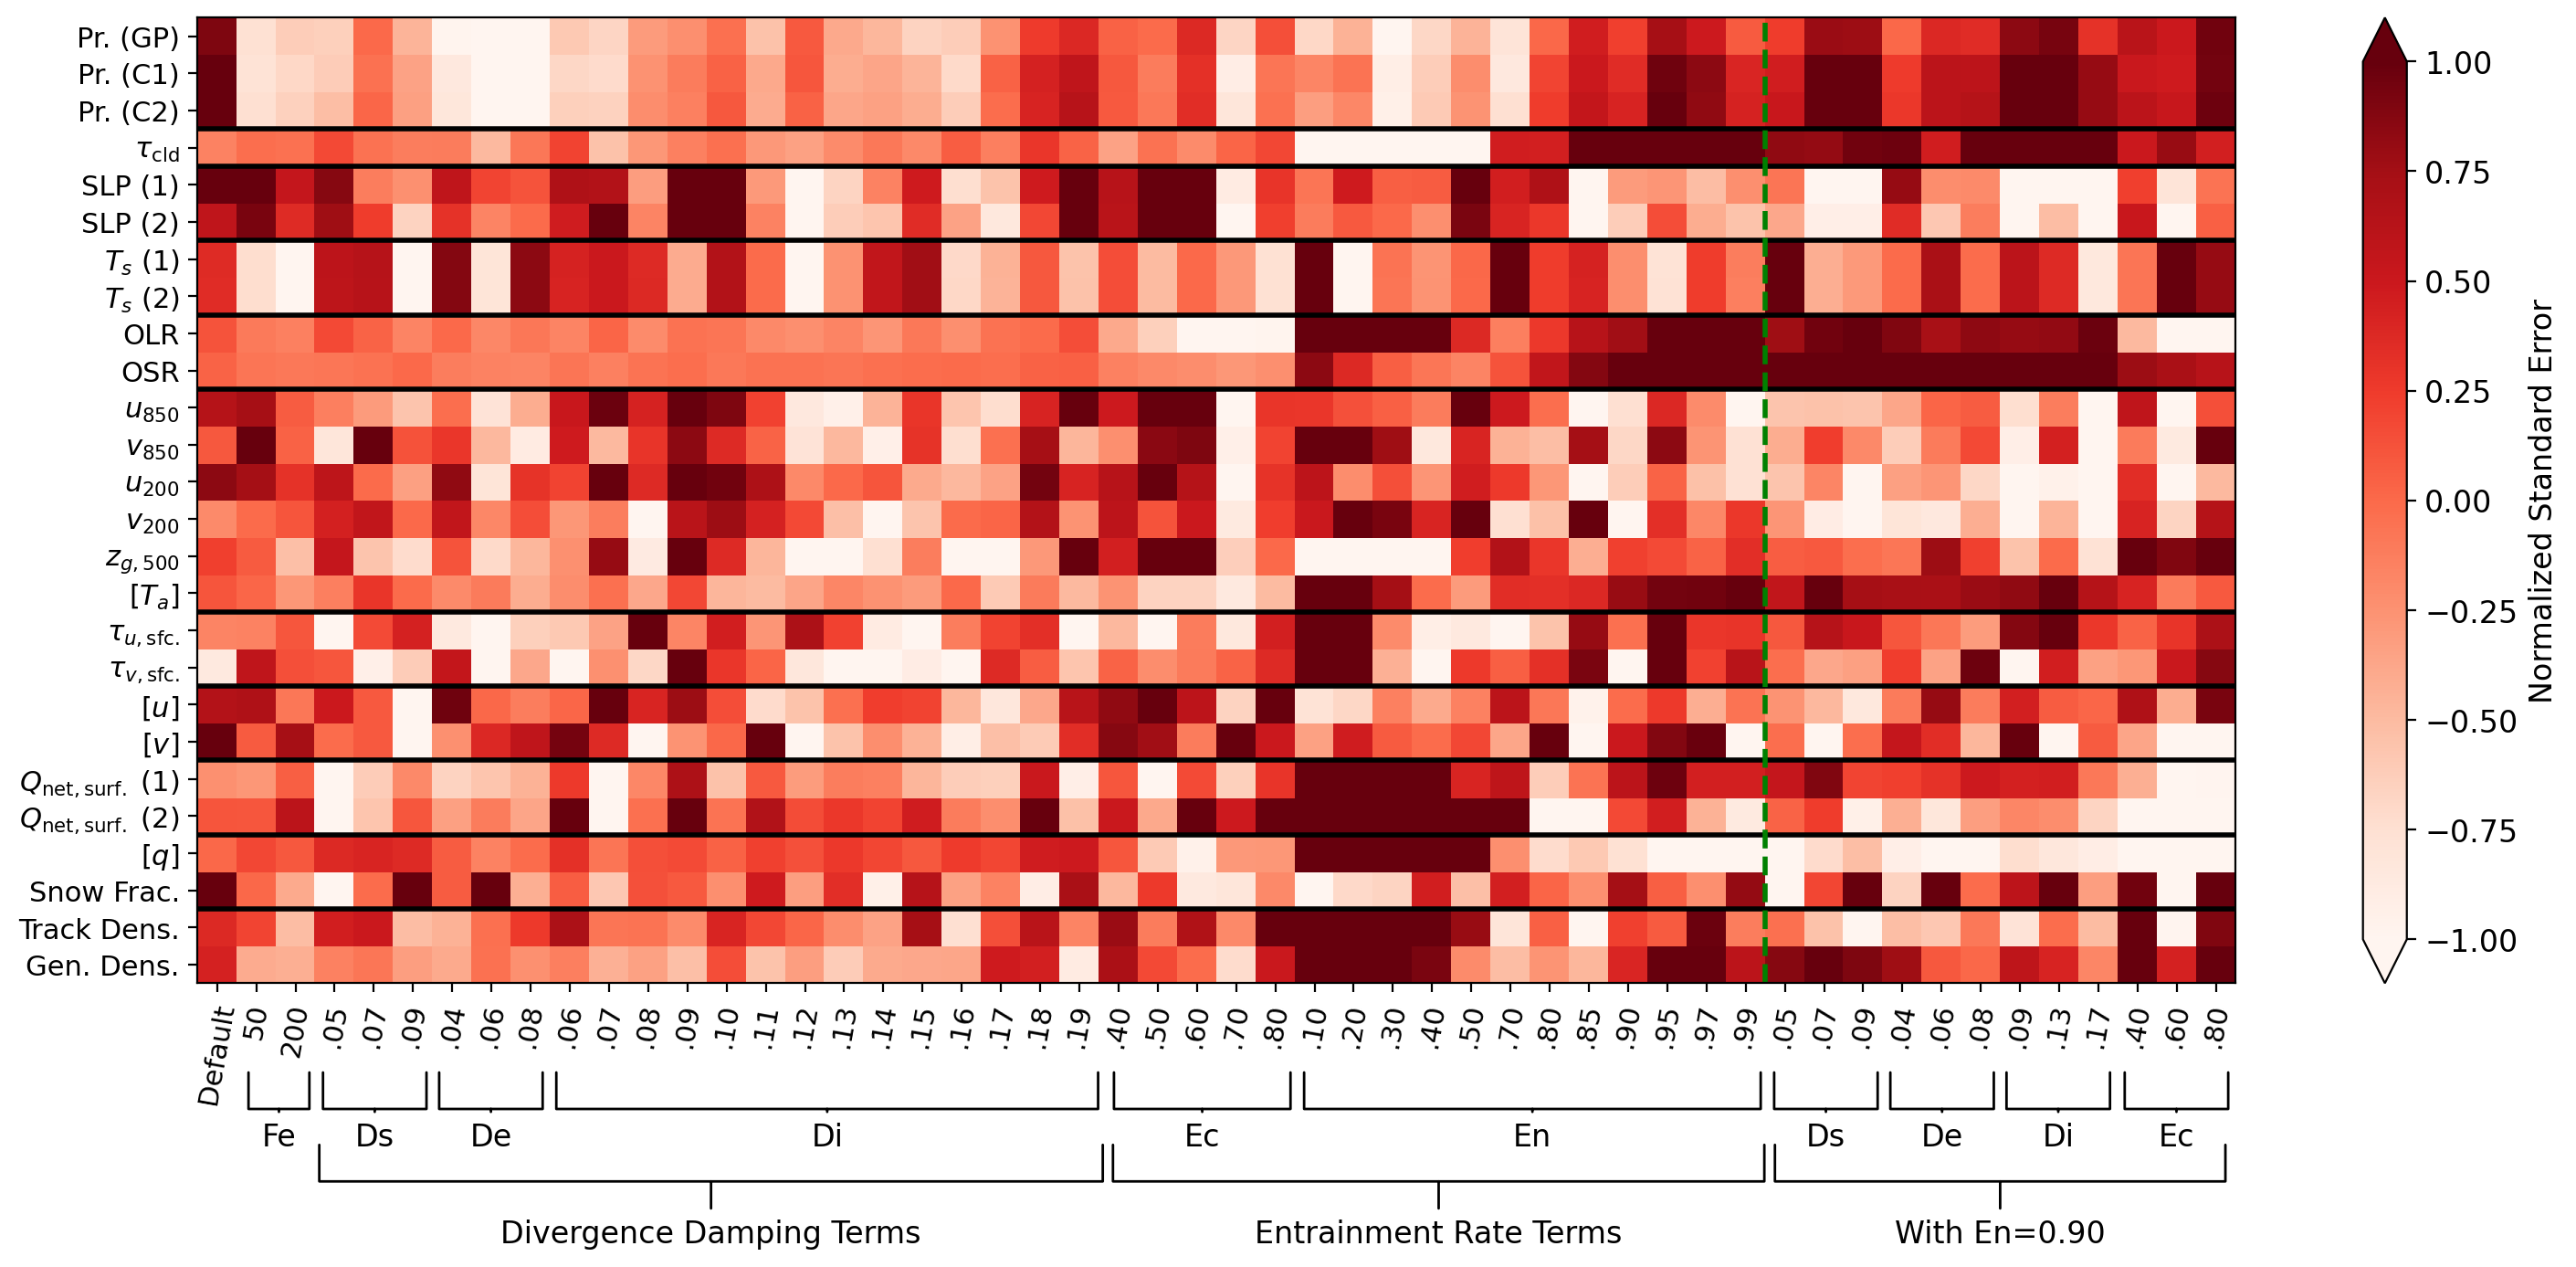

In [74]:
#Global mean, all at once, with different colormap
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_RMSE_u)
plt.pcolor(plotmat, cmap = plt.cm.Reds, 
           vmin=-1, vmax=1)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized Standard Error', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/RMSE_matrix_V1_unweighted_reds.png', bbox_inches='tight')
plt.savefig('plots/RMSE_matrix_V1_unweighted_reds.pdf', bbox_inches='tight')

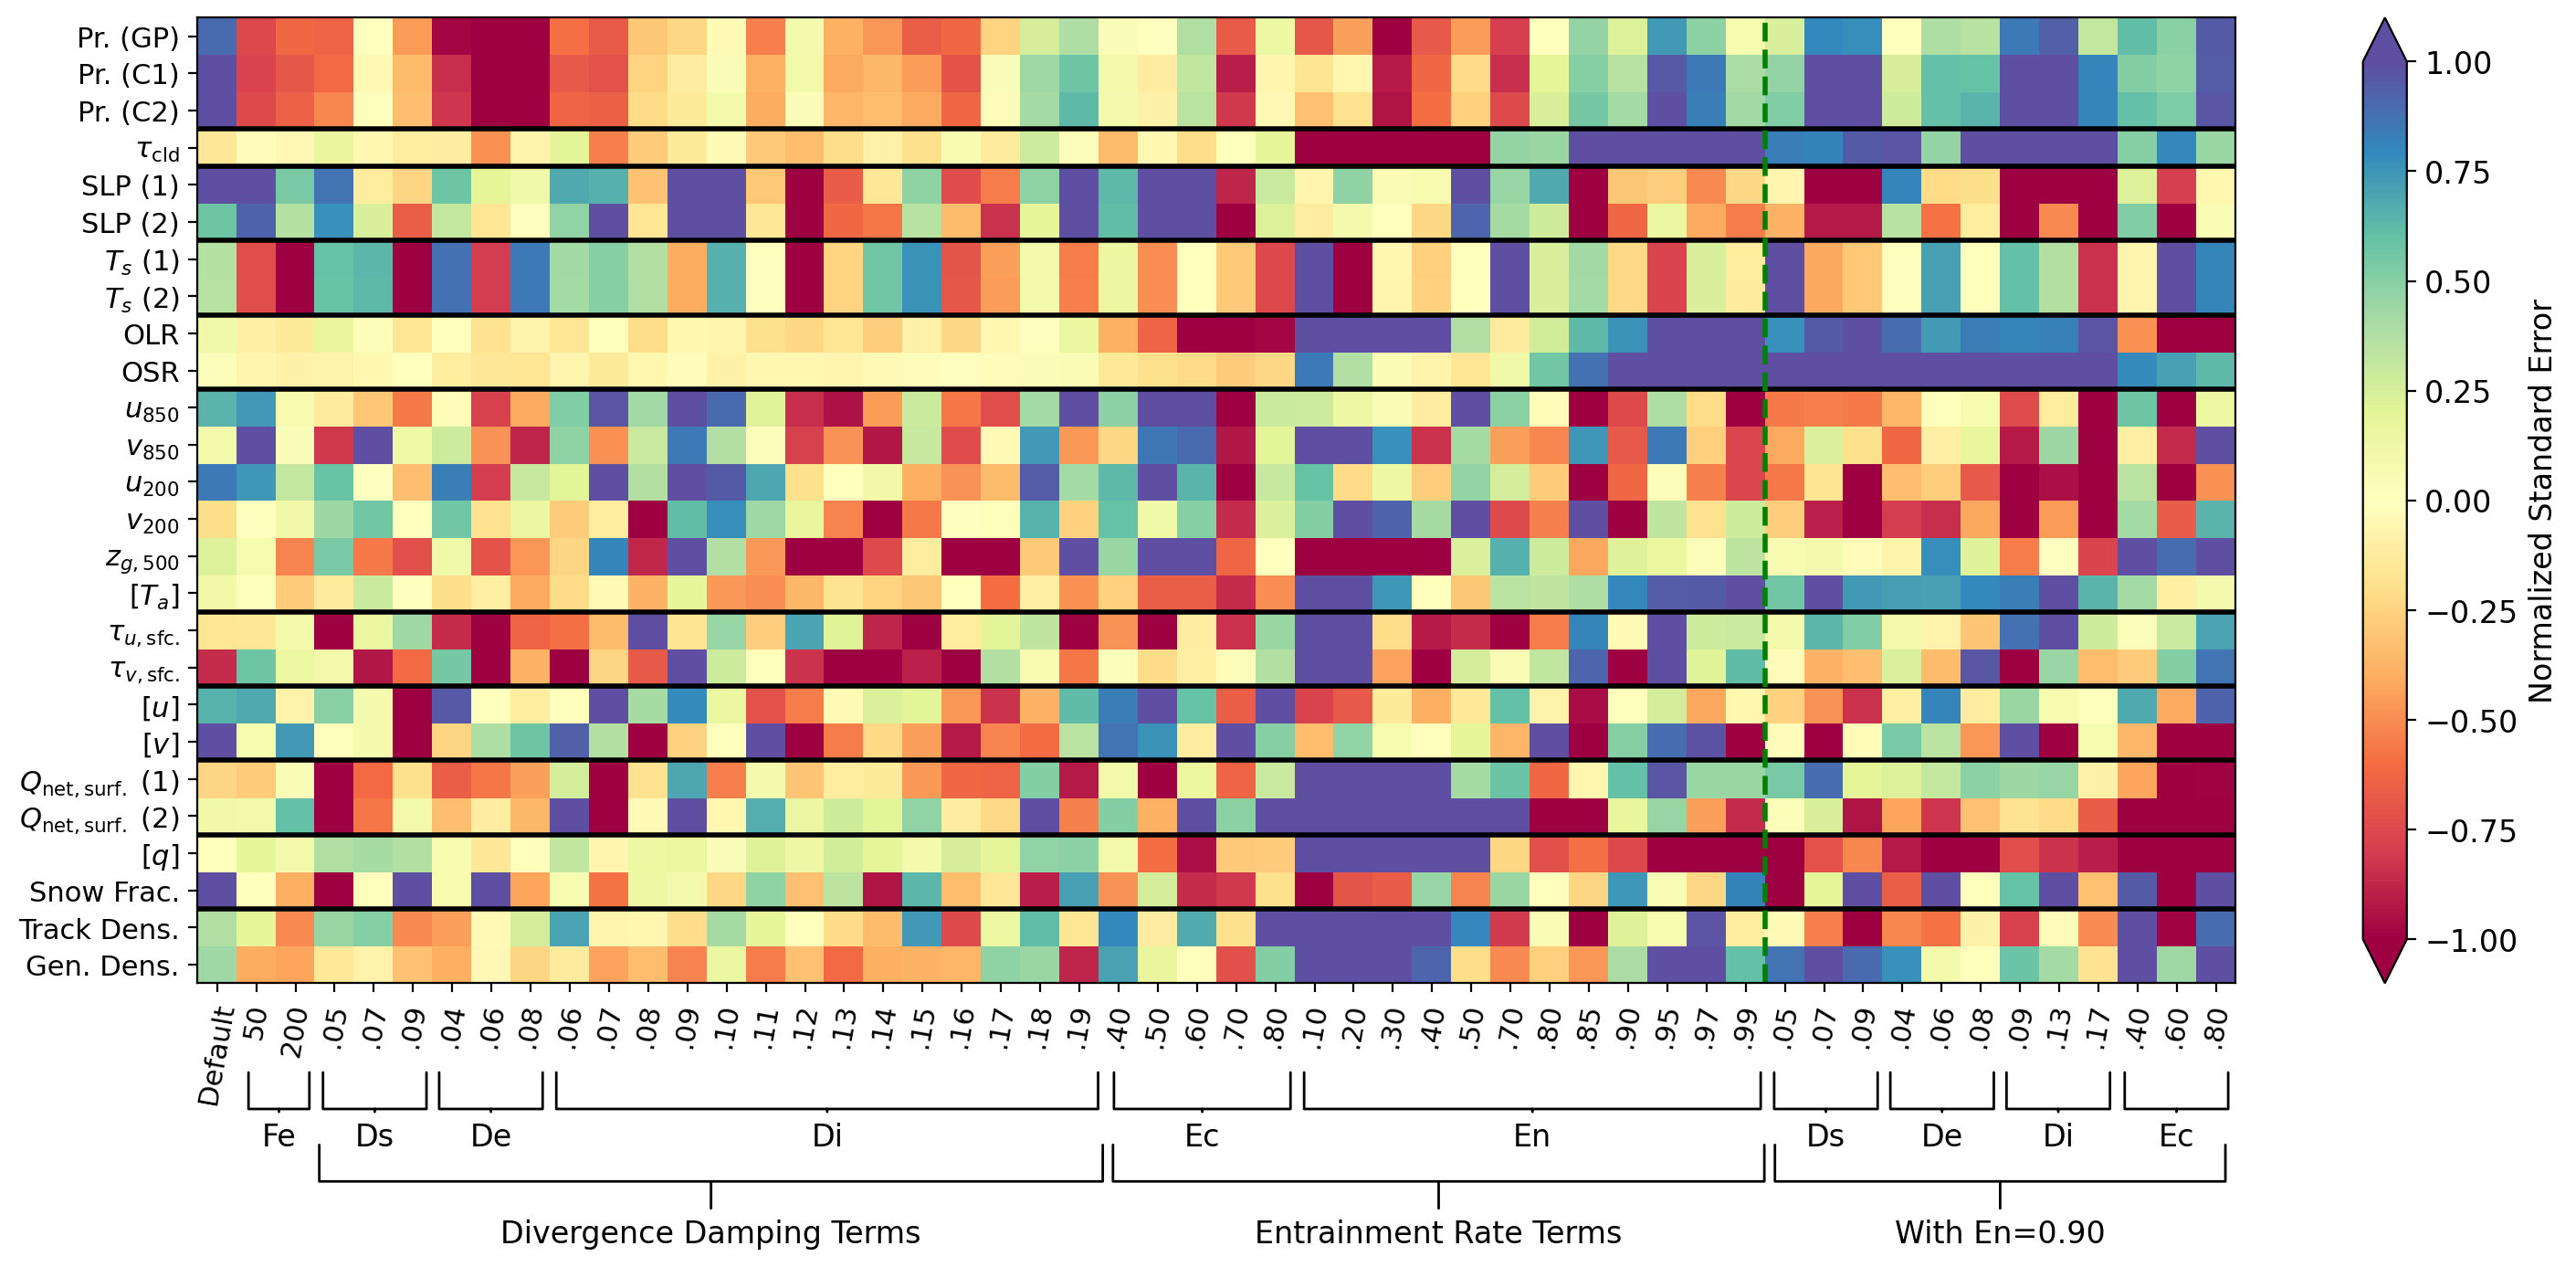

In [76]:
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_RMSE_u)
plt.pcolor(plotmat, cmap = plt.cm.Spectral, 
           vmin=-1, vmax=1)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized Standard Error', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/RMSE_matrix_V1_unweighted_spectral.png', bbox_inches='tight')
plt.savefig('plots/RMSE_matrix_V1_unweighted_spectral.pdf', bbox_inches='tight')

#This isn't easily intelligible...

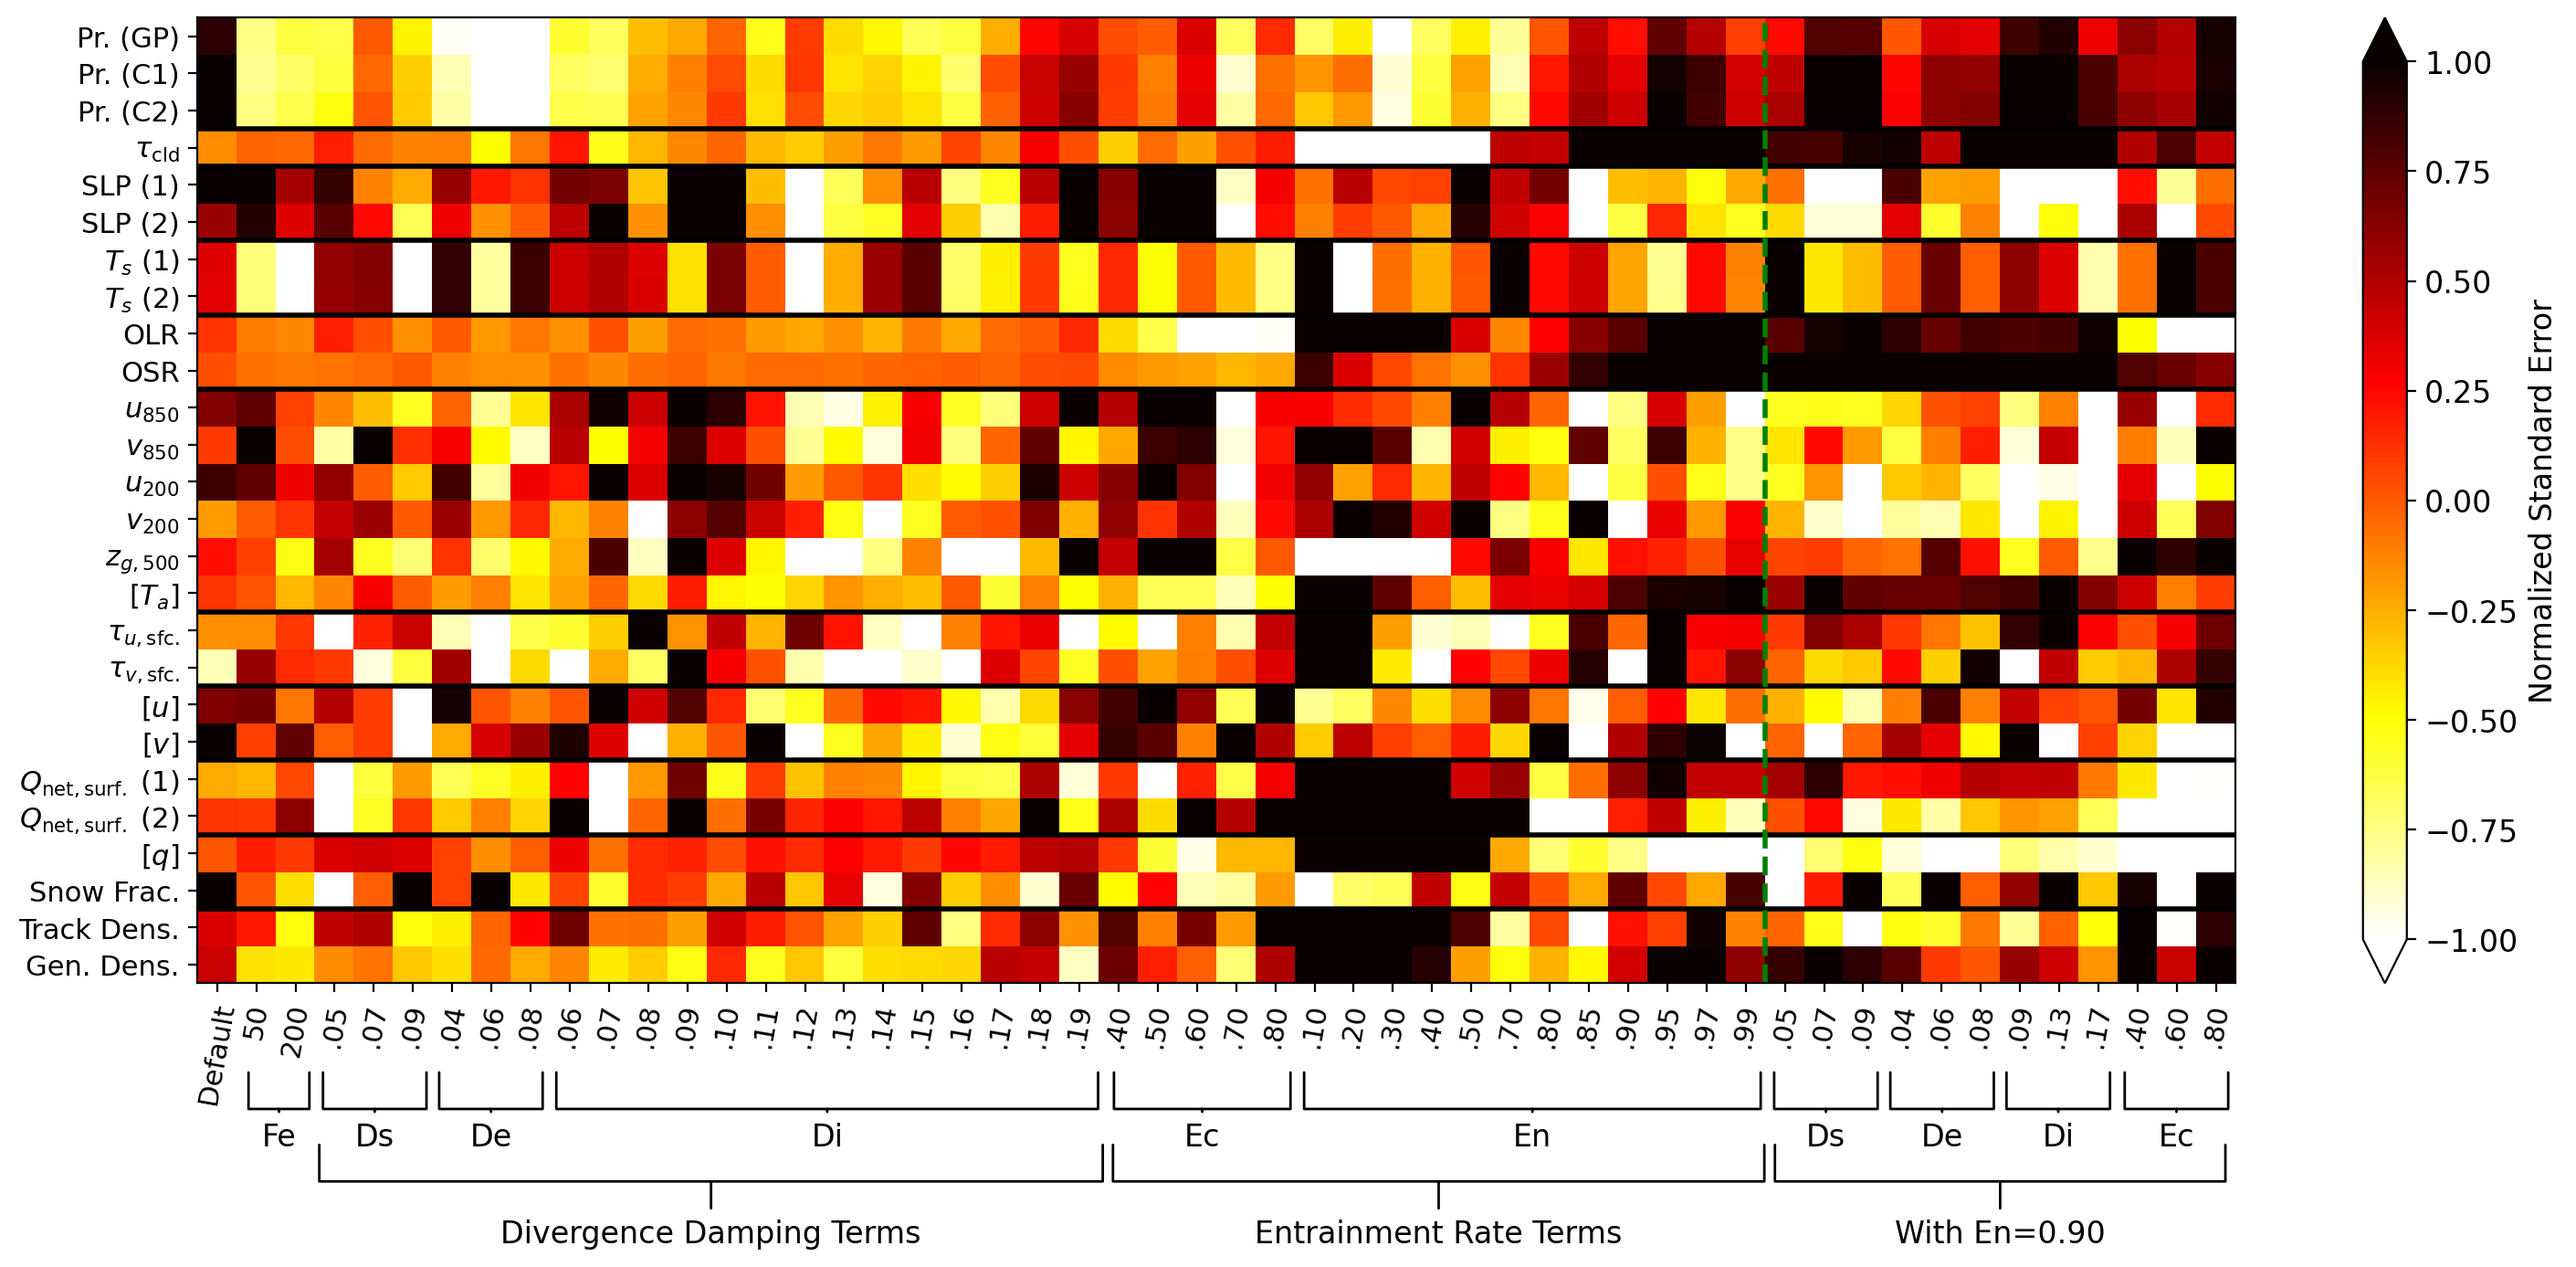

In [77]:
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_RMSE_u)
plt.pcolor(plotmat, cmap = plt.cm.hot_r, 
           vmin=-1, vmax=1)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized Standard Error', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/RMSE_matrix_V1_unweighted_hot_r.png', bbox_inches='tight')
plt.savefig('plots/RMSE_matrix_V1_unweighted_hot_r.pdf', bbox_inches='tight')

#This isn't easily intelligible...

[[ 0.449312   -0.40673523 -0.43648441 ...  1.16493331  0.43673353
   1.9570176 ]
 [ 0.34618466  0.1861114  -0.51347871 ...  1.30272241 -0.97267724
   0.90098308]
 [ 1.32511391  0.07654438 -0.47234782 ...  1.40888046 -0.73582073
   2.30400498]
 ...
 [ 1.09646807 -0.78621372 -0.62522921 ...  0.6537371   0.5431297
   0.97132345]
 [ 1.17910803 -0.8041487  -0.6653677  ...  0.58383732  0.47683298
   0.95939232]
 [ 0.94698608 -0.81647591 -0.62340935 ...  0.65430647  0.53701537
   0.97454796]]
[ 0.449312    0.34618466  1.32511391  0.02555101  0.07170131 -0.20393145
  0.97688927  0.87780771 -0.72268973  0.00901866 -0.00805667 -0.07553171
 -0.13812798  0.97620267  0.0228858   0.90136948  0.04082883  0.14277742
  0.54696847  0.54502924  0.1971439   0.4439546  -0.17437631  1.09646807
  1.17910803  0.94698608]


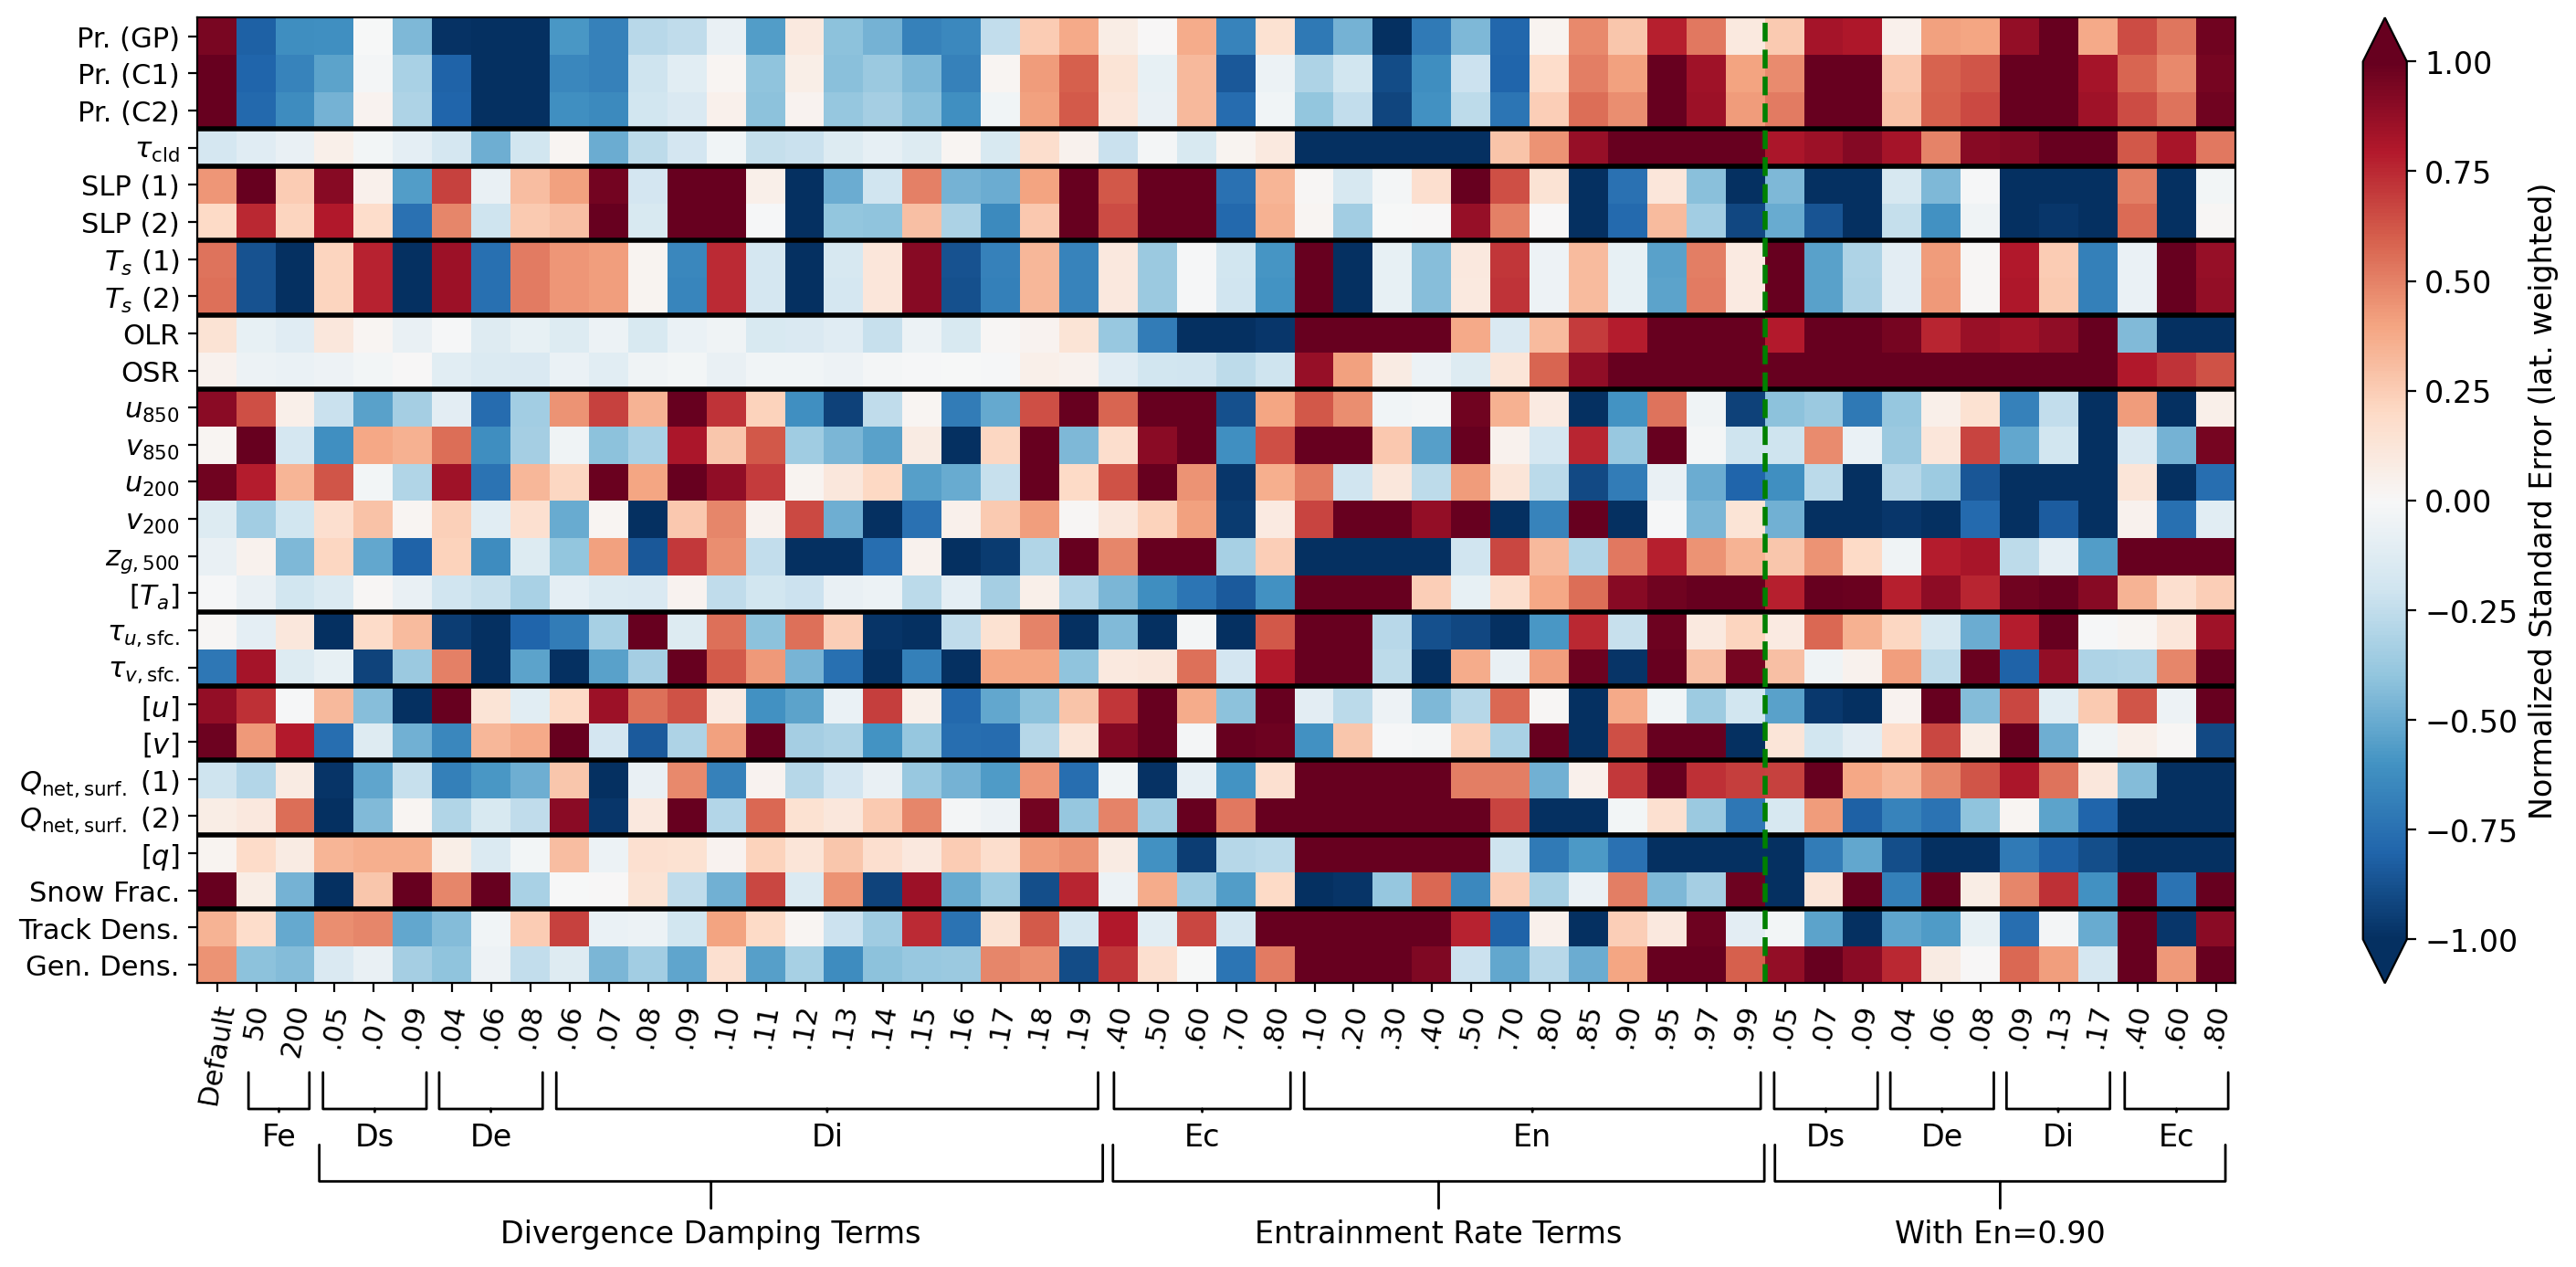

In [41]:
#Weighted RMSE
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_RMSE_w)
print(plotmat)
print(plotmat[:,0])
plt.pcolor(plotmat, cmap = plt.cm.RdBu_r, 
           vmin=-1, vmax=1)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized Standard Error (lat. weighted)', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/RMSE_matrix_V1_weighted.png', bbox_inches='tight')
plt.savefig('plots/RMSE_matrix_V1_weighted.pdf', bbox_inches='tight')



[[ 0.449312   -0.40673523 -0.43648441 ...  1.16493331  0.43673353
   1.9570176 ]
 [ 0.34618466  0.1861114  -0.51347871 ...  1.30272241 -0.97267724
   0.90098308]
 [ 1.32511391  0.07654438 -0.47234782 ...  1.40888046 -0.73582073
   2.30400498]
 ...
 [ 1.09646807 -0.78621372 -0.62522921 ...  0.6537371   0.5431297
   0.97132345]
 [ 1.17910803 -0.8041487  -0.6653677  ...  0.58383732  0.47683298
   0.95939232]
 [ 0.94698608 -0.81647591 -0.62340935 ...  0.65430647  0.53701537
   0.97454796]]
[ 0.449312    0.34618466  1.32511391  0.02555101  0.07170131 -0.20393145
  0.97688927  0.87780771 -0.72268973  0.00901866 -0.00805667 -0.07553171
 -0.13812798  0.97620267  0.0228858   0.90136948  0.04082883  0.14277742
  0.54696847  0.54502924  0.1971439   0.4439546  -0.17437631  1.09646807
  1.17910803  0.94698608]


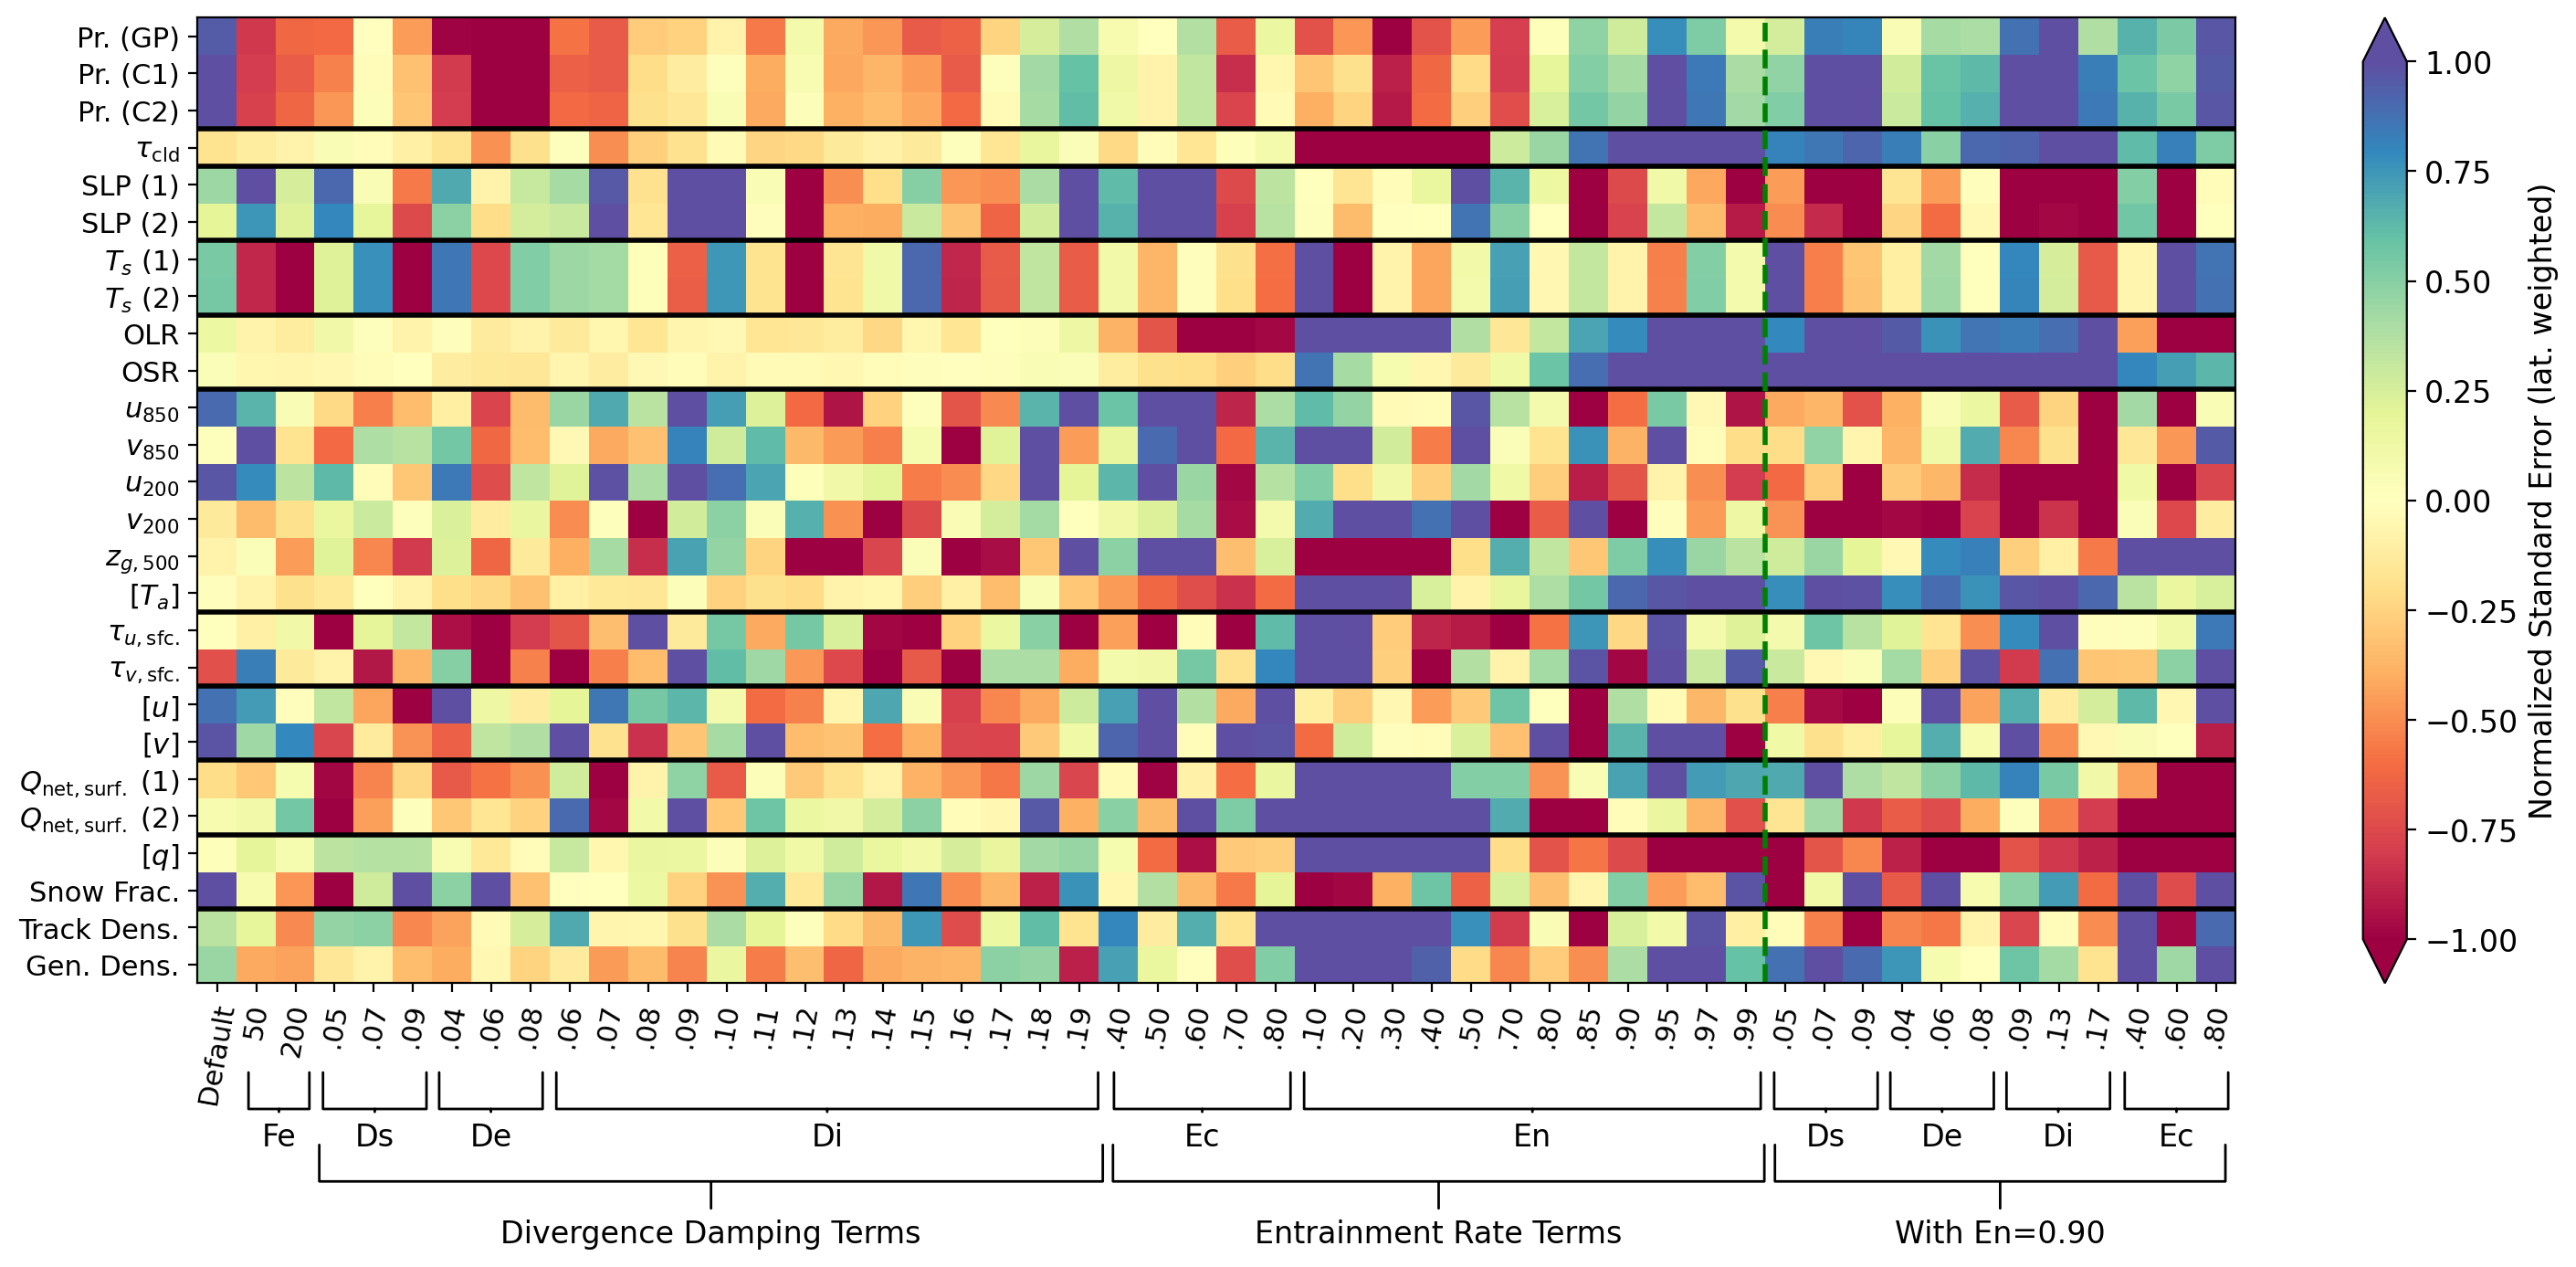

In [43]:
#Weighted RMSE
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_RMSE_w)
print(plotmat)
print(plotmat[:,0])
plt.pcolor(plotmat, cmap = plt.cm.Spectral, 
           vmin=-1, vmax=1)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized Standard Error (lat. weighted)', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/RMSE_matrix_V1_weighted_spectral.png', bbox_inches='tight')
plt.savefig('plots/RMSE_matrix_V1_weighted_spectral.pdf', bbox_inches='tight')

[[ 0.449312   -0.40673523 -0.43648441 ...  1.16493331  0.43673353
   1.9570176 ]
 [ 0.34618466  0.1861114  -0.51347871 ...  1.30272241 -0.97267724
   0.90098308]
 [ 1.32511391  0.07654438 -0.47234782 ...  1.40888046 -0.73582073
   2.30400498]
 ...
 [ 1.09646807 -0.78621372 -0.62522921 ...  0.6537371   0.5431297
   0.97132345]
 [ 1.17910803 -0.8041487  -0.6653677  ...  0.58383732  0.47683298
   0.95939232]
 [ 0.94698608 -0.81647591 -0.62340935 ...  0.65430647  0.53701537
   0.97454796]]
[ 0.449312    0.34618466  1.32511391  0.02555101  0.07170131 -0.20393145
  0.97688927  0.87780771 -0.72268973  0.00901866 -0.00805667 -0.07553171
 -0.13812798  0.97620267  0.0228858   0.90136948  0.04082883  0.14277742
  0.54696847  0.54502924  0.1971439   0.4439546  -0.17437631  1.09646807
  1.17910803  0.94698608]


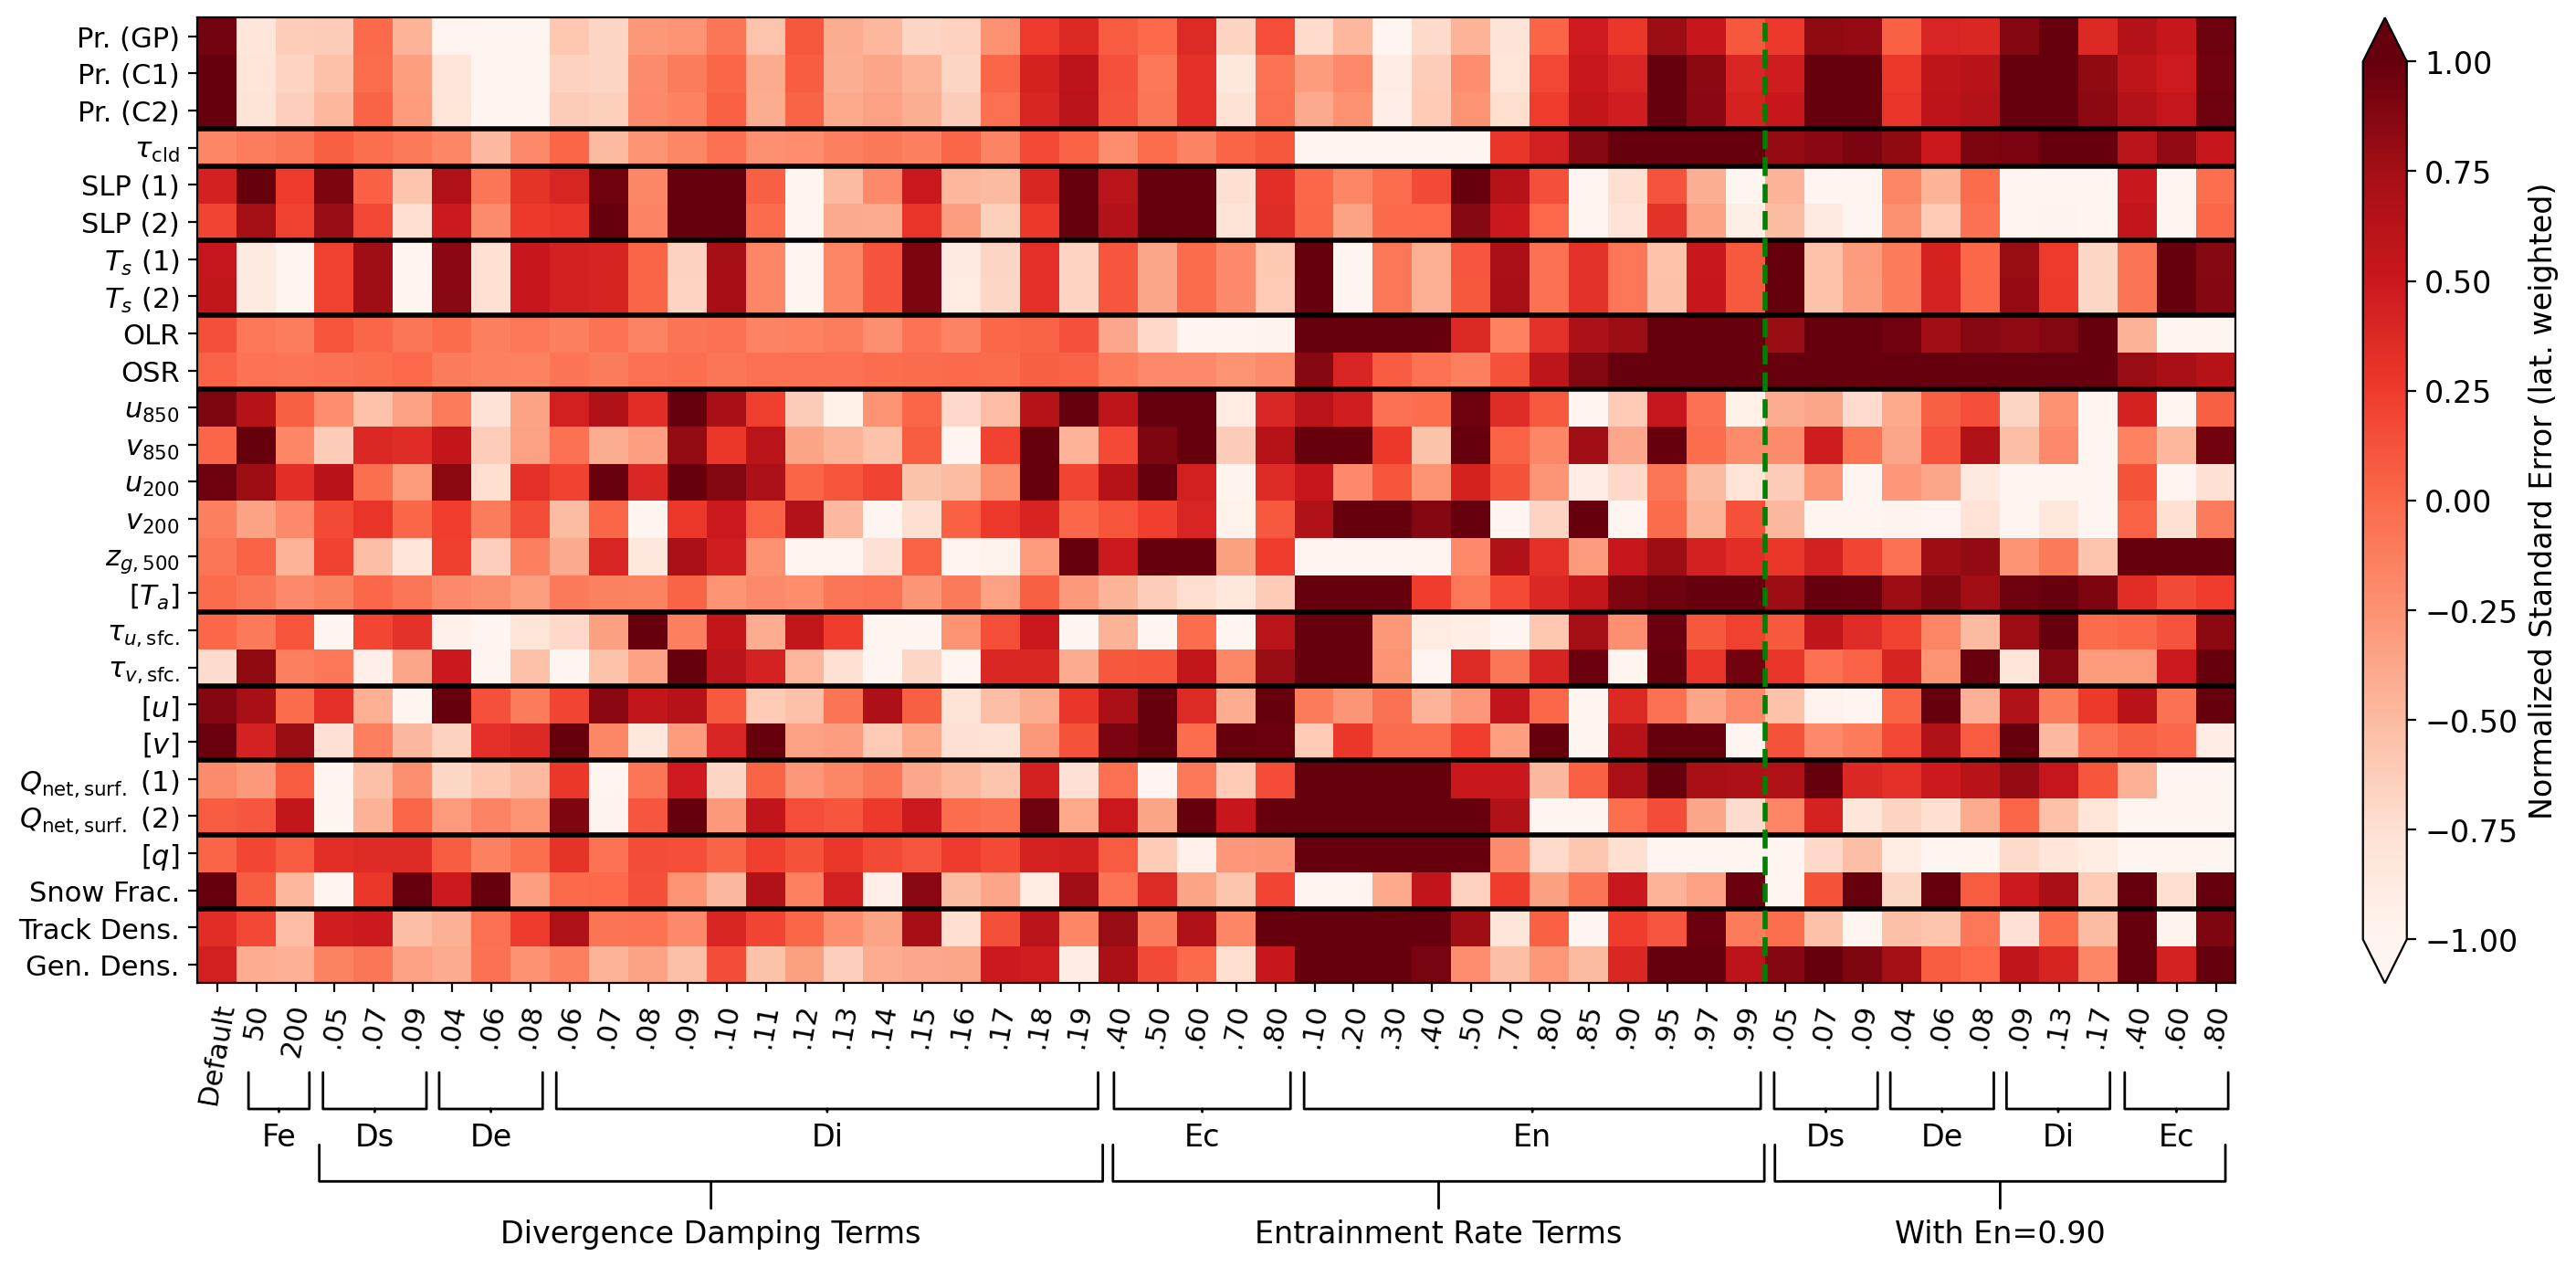

In [48]:
#Weighted RMSE
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_RMSE_w)
print(plotmat)
print(plotmat[:,0])
plt.pcolor(plotmat, cmap = plt.cm.Reds, 
           vmin=-1, vmax=1)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized Standard Error (lat. weighted)', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/RMSE_matrix_V1_weighted_reds.png', bbox_inches='tight')
plt.savefig('plots/RMSE_matrix_V1_weighted_reds.pdf', bbox_inches='tight')

[[ 0.449312   -0.40673523 -0.43648441 ...  1.16493331  0.43673353
   1.9570176 ]
 [ 0.34618466  0.1861114  -0.51347871 ...  1.30272241 -0.97267724
   0.90098308]
 [ 1.32511391  0.07654438 -0.47234782 ...  1.40888046 -0.73582073
   2.30400498]
 ...
 [ 1.09646807 -0.78621372 -0.62522921 ...  0.6537371   0.5431297
   0.97132345]
 [ 1.17910803 -0.8041487  -0.6653677  ...  0.58383732  0.47683298
   0.95939232]
 [ 0.94698608 -0.81647591 -0.62340935 ...  0.65430647  0.53701537
   0.97454796]]
[ 0.449312    0.34618466  1.32511391  0.02555101  0.07170131 -0.20393145
  0.97688927  0.87780771 -0.72268973  0.00901866 -0.00805667 -0.07553171
 -0.13812798  0.97620267  0.0228858   0.90136948  0.04082883  0.14277742
  0.54696847  0.54502924  0.1971439   0.4439546  -0.17437631  1.09646807
  1.17910803  0.94698608]


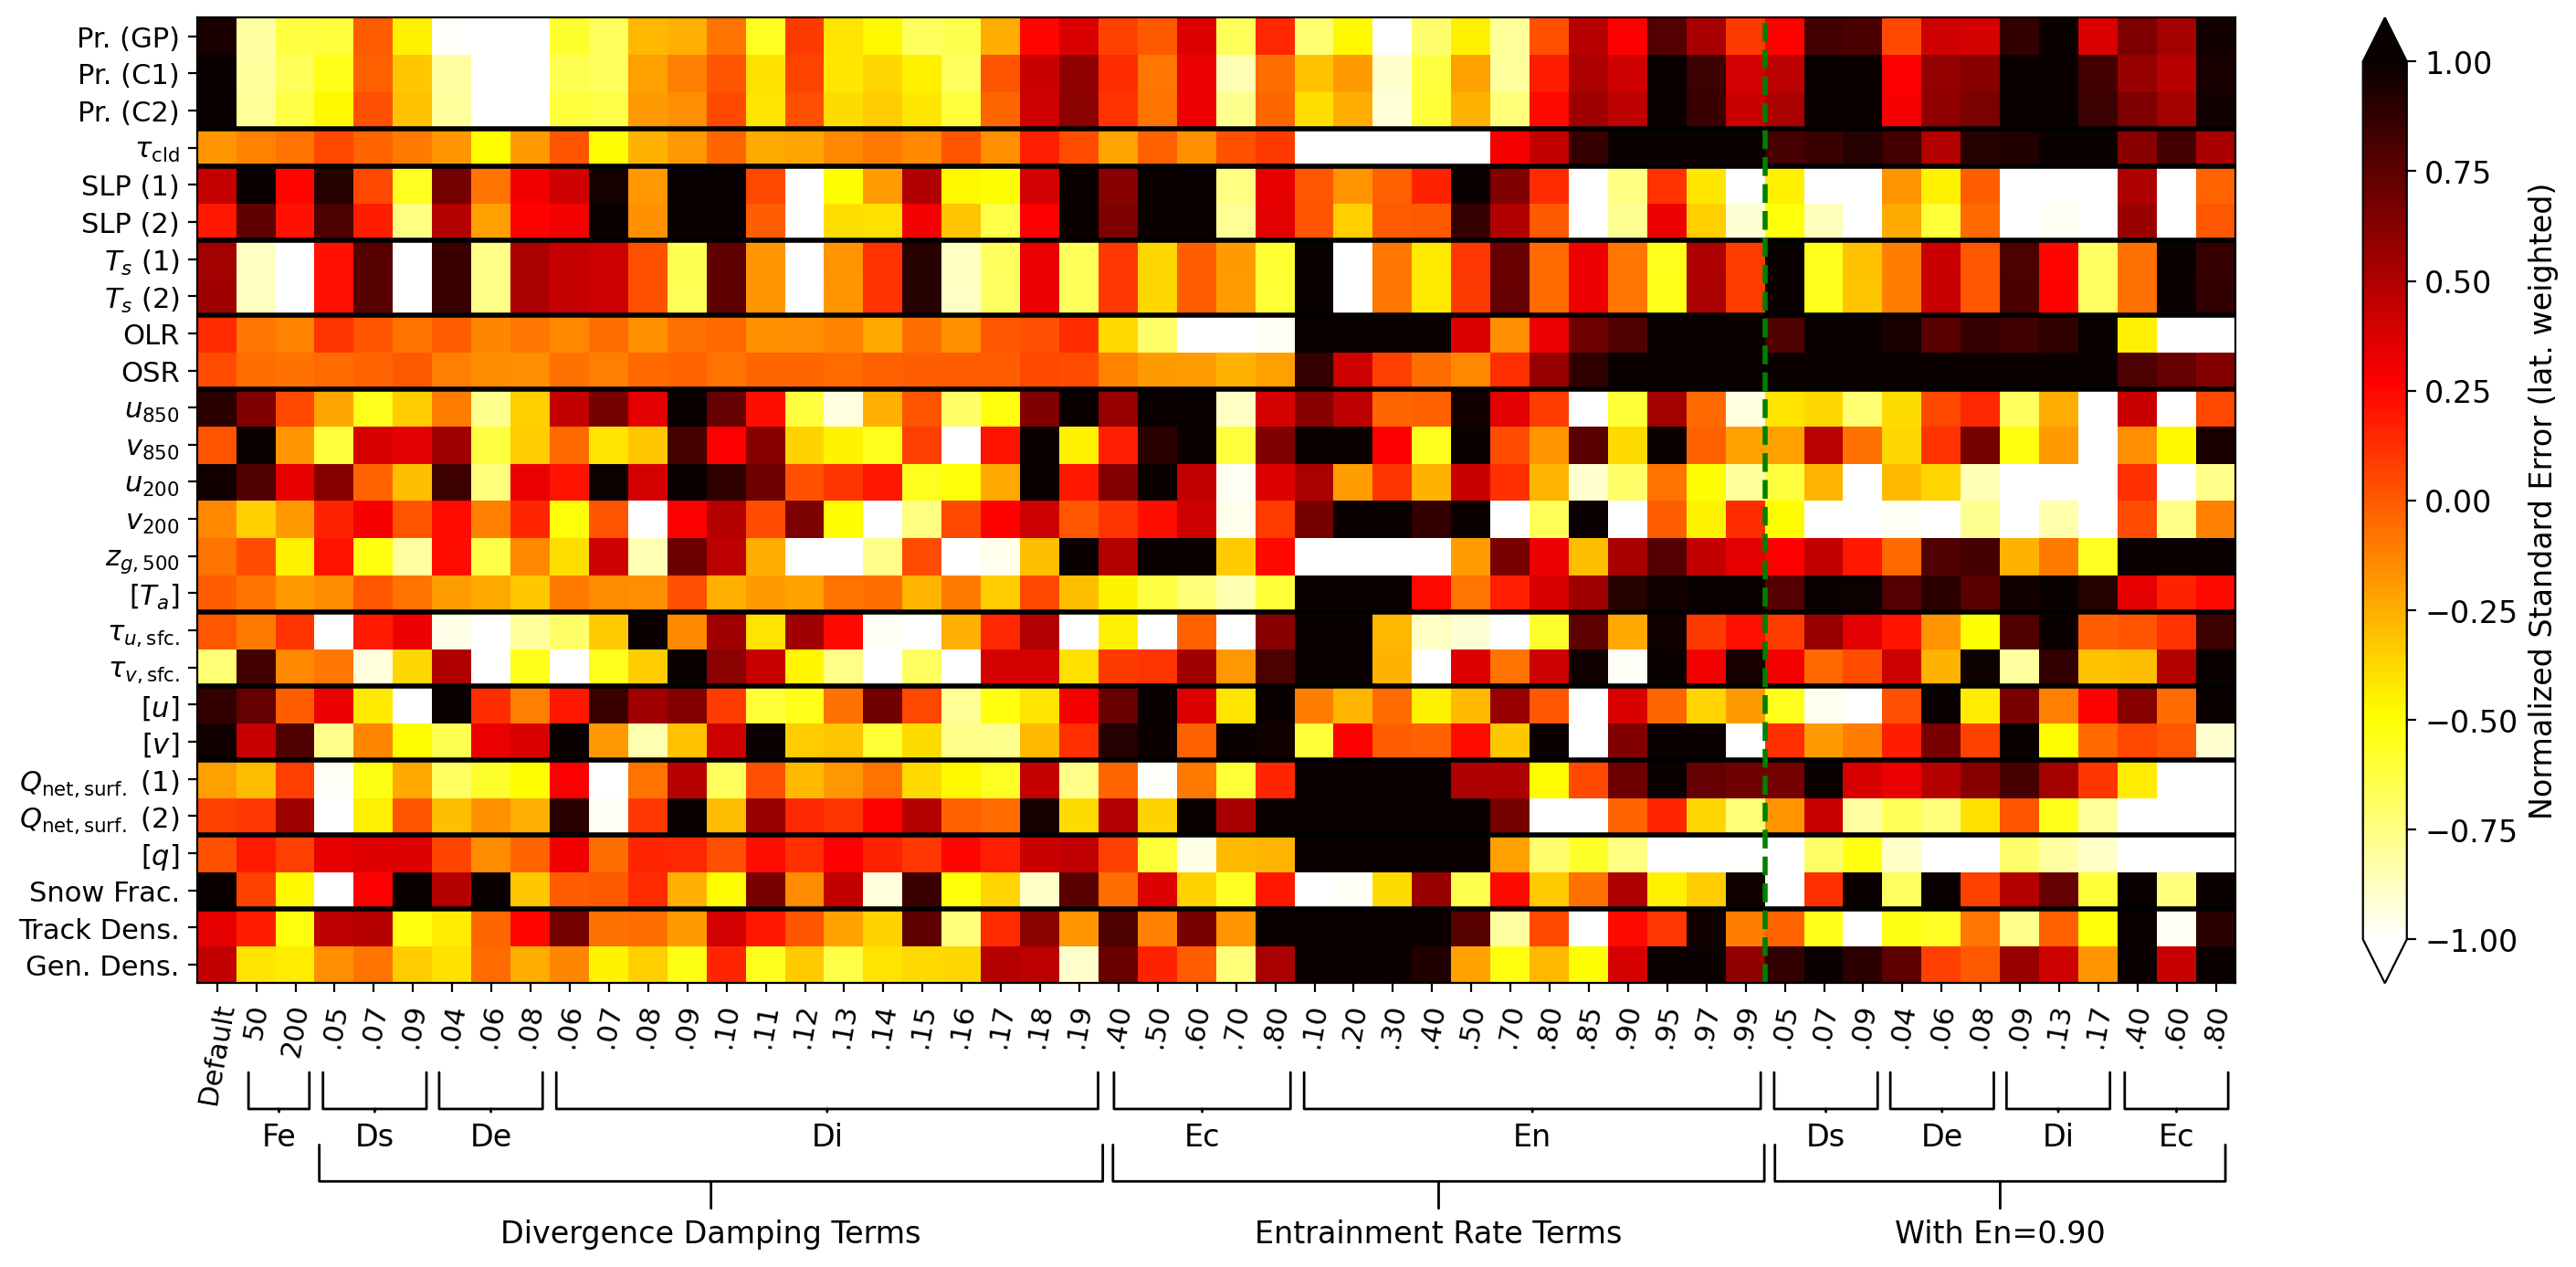

In [46]:
#Weighted RMSE
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_RMSE_w)
print(plotmat)
print(plotmat[:,0])
plt.pcolor(plotmat, cmap = plt.cm.hot_r, 
           vmin=-1, vmax=1)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized Standard Error (lat. weighted)', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/RMSE_matrix_V1_weighted_hot_r.png', bbox_inches='tight')
plt.savefig('plots/RMSE_matrix_V1_weighted_hot_r.pdf', bbox_inches='tight')

[[ 0.449312   -0.40673523 -0.43648441 ...  1.16493331  0.43673353
   1.9570176 ]
 [ 0.34618466  0.1861114  -0.51347871 ...  1.30272241 -0.97267724
   0.90098308]
 [ 1.32511391  0.07654438 -0.47234782 ...  1.40888046 -0.73582073
   2.30400498]
 ...
 [ 1.09646807 -0.78621372 -0.62522921 ...  0.6537371   0.5431297
   0.97132345]
 [ 1.17910803 -0.8041487  -0.6653677  ...  0.58383732  0.47683298
   0.95939232]
 [ 0.94698608 -0.81647591 -0.62340935 ...  0.65430647  0.53701537
   0.97454796]]
[ 0.449312    0.34618466  1.32511391  0.02555101  0.07170131 -0.20393145
  0.97688927  0.87780771 -0.72268973  0.00901866 -0.00805667 -0.07553171
 -0.13812798  0.97620267  0.0228858   0.90136948  0.04082883  0.14277742
  0.54696847  0.54502924  0.1971439   0.4439546  -0.17437631  1.09646807
  1.17910803  0.94698608]


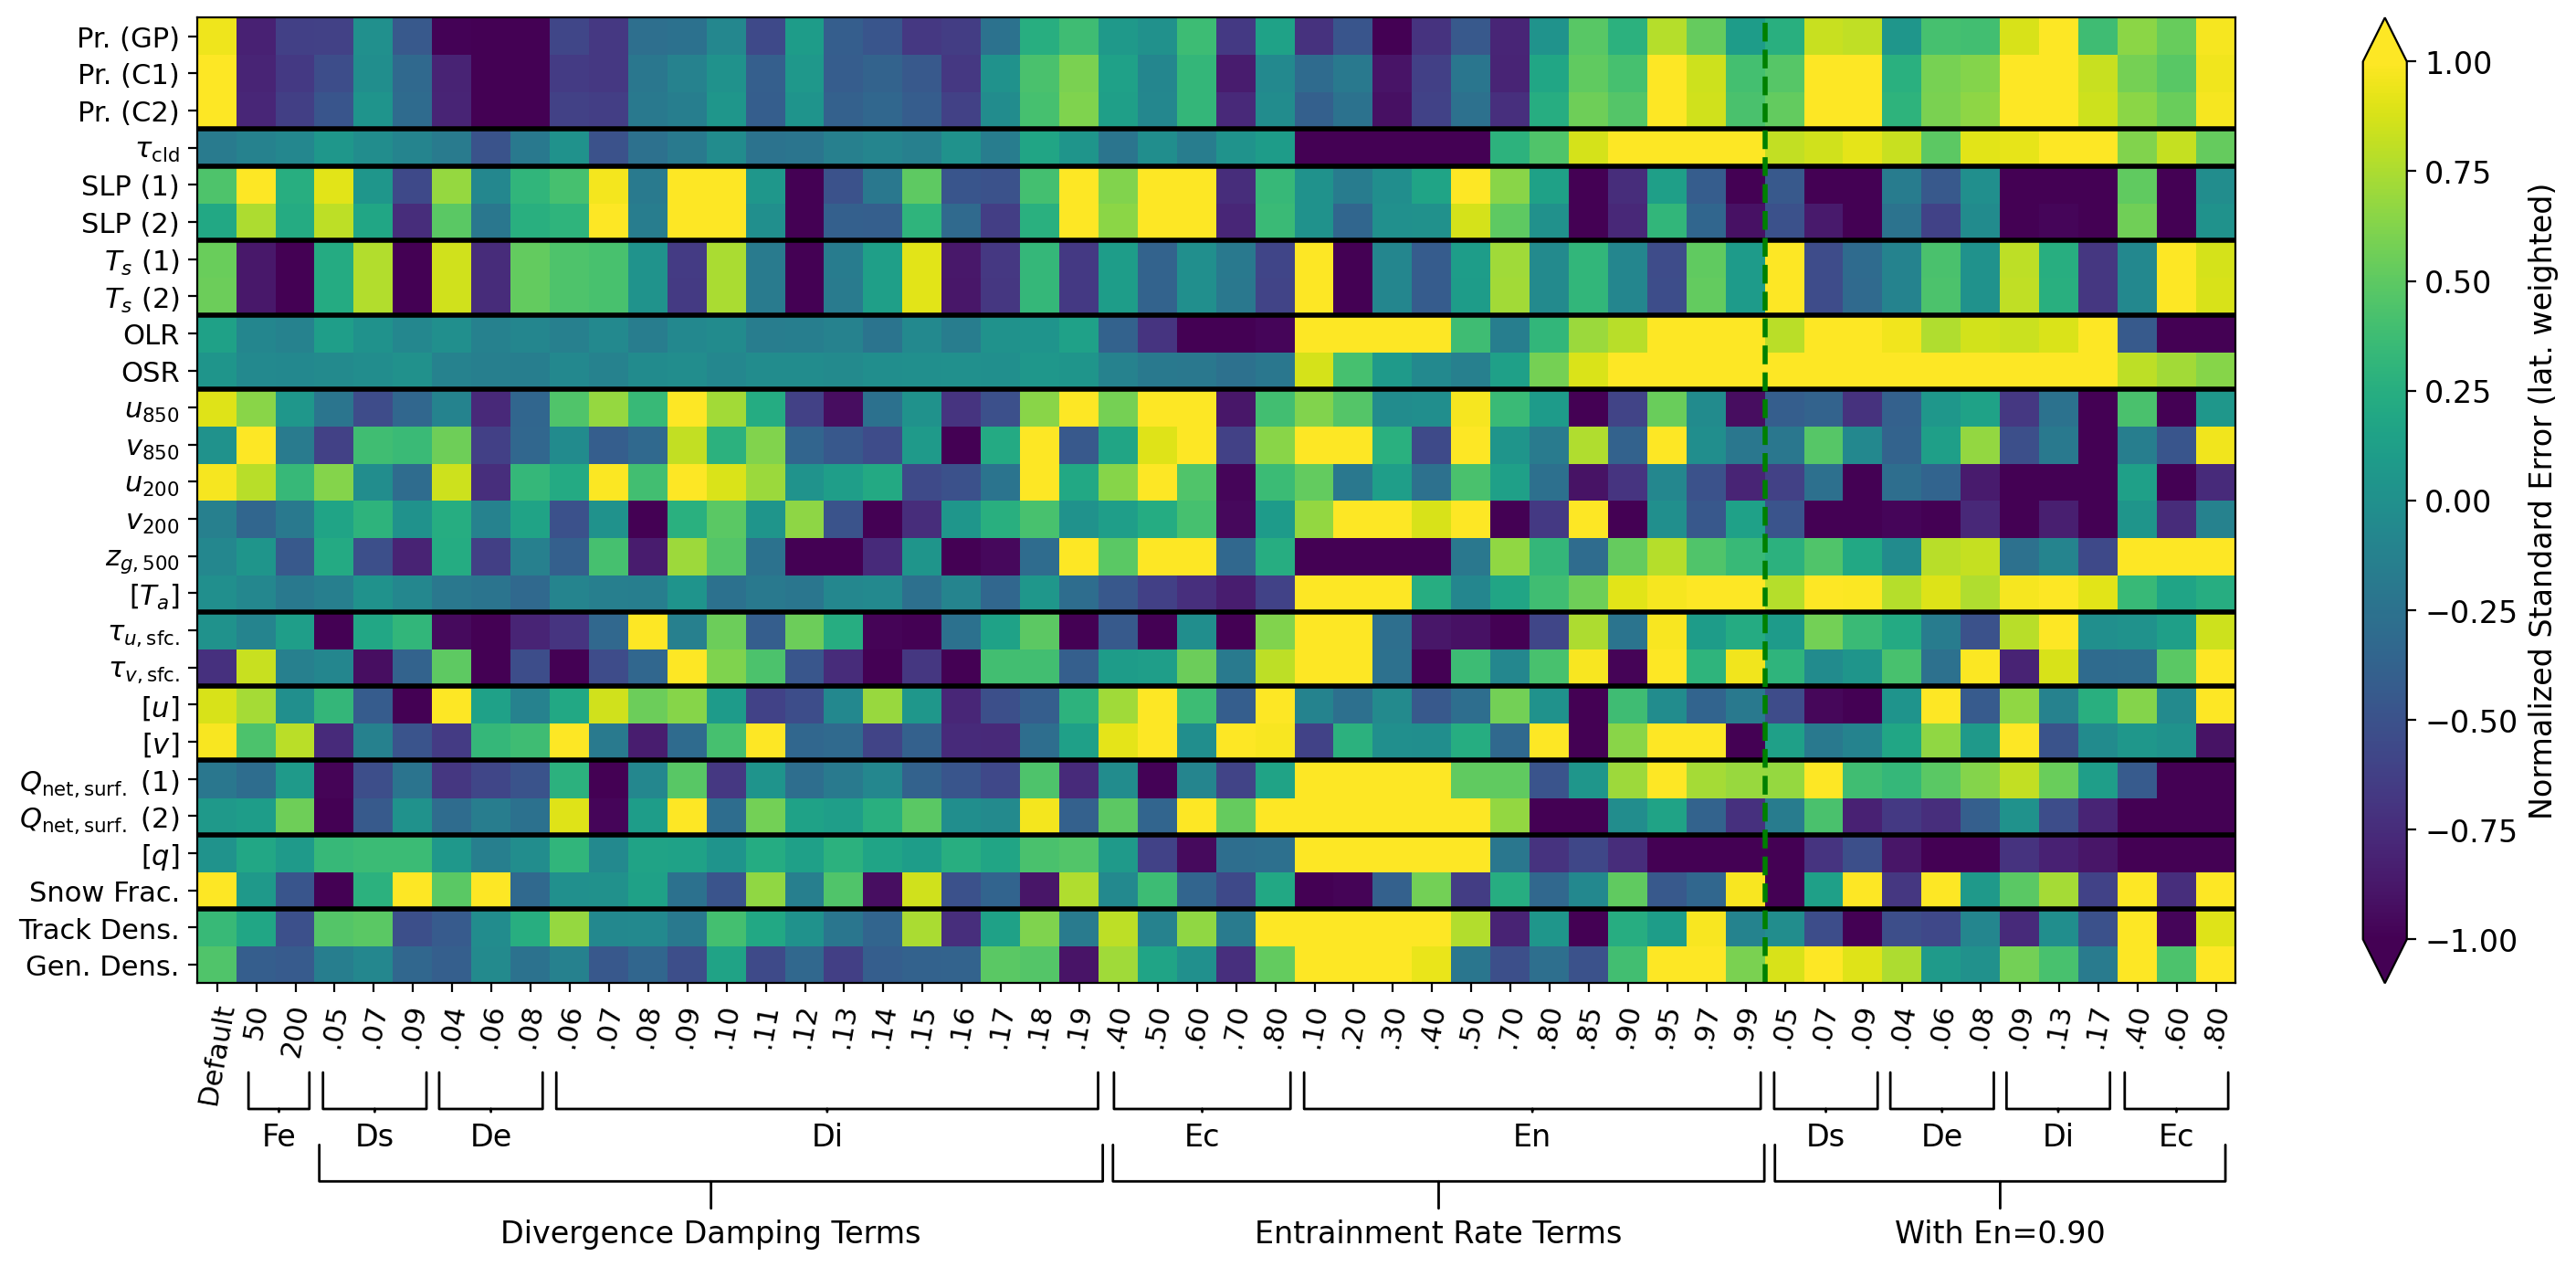

In [42]:
#Weighted RMSE
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_RMSE_w)
print(plotmat)
print(plotmat[:,0])
plt.pcolor(plotmat, cmap = plt.cm.viridis, 
           vmin=-1, vmax=1)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized Standard Error (lat. weighted)', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/RMSE_matrix_V1_weighted_viridis.png', bbox_inches='tight')
plt.savefig('plots/RMSE_matrix_V1_weighted_viridis.pdf', bbox_inches='tight')

[[-1.24388011 -1.110618   -1.18498709 ... -0.08232697  0.19148841
   0.16869629]
 [-1.06863402 -1.11625956 -1.0314155  ... -0.45385018 -0.34738431
  -0.23138456]
 [ 1.05879097  0.96356132  0.92686951 ...  1.10972592  0.91444988
   1.13299933]
 ...
 [ 1.00743156  1.03763893  1.02667206 ...  1.56105907  1.96533533
   2.02792525]
 [ 1.00361157  1.01789171  1.01241672 ...  1.27818885  1.47754075
   1.50832065]
 [ 0.99976475  1.04608047  1.02926541 ...  1.84861898  2.4684791
   2.56444563]]
[-1.24388011 -1.06863402  1.05879097  0.99769996 -0.77881373  0.5892205
  1.09277398 -1.50167573  1.1832916   0.97867767  1.04777494 -0.97049343
 -1.18472865  1.24045023  1.16406955 -0.81205274  0.95360296 -0.934926
 -1.20265097 -1.20271536 -0.98686344 -0.98568047  0.98509294  1.00743156
  1.00361157  0.99976475]


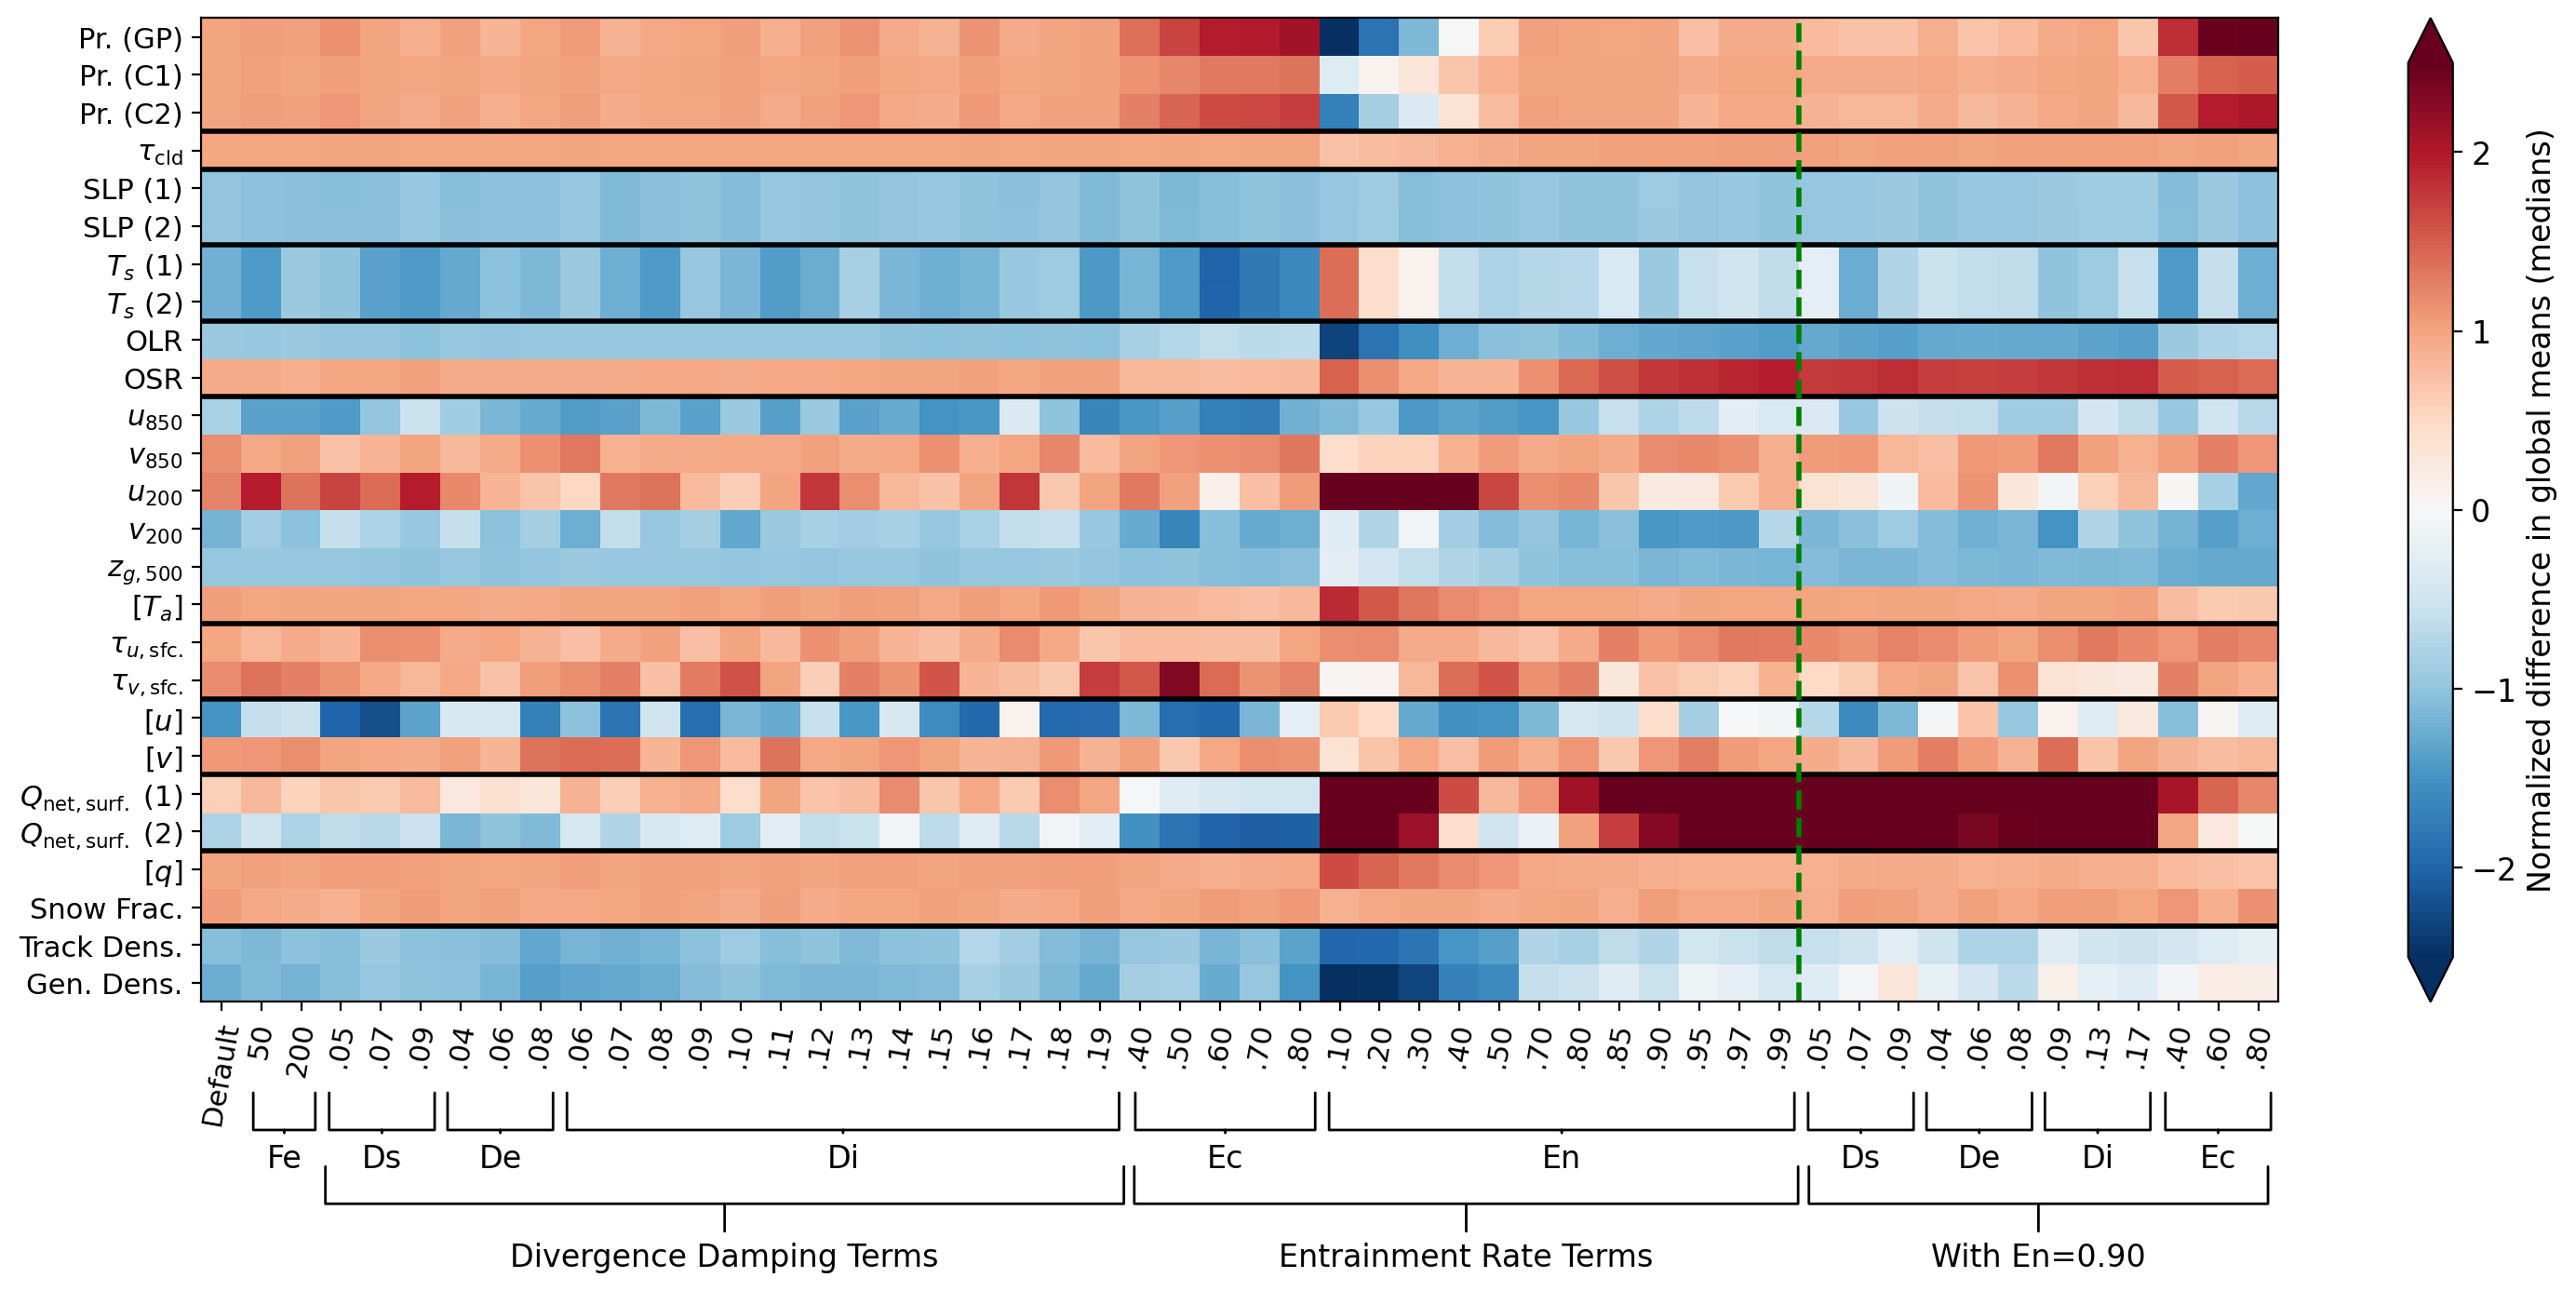

In [37]:
#Difference in global means
plt.figure(figsize=(18,7), dpi=200)
plotmat = np.flipud(norm_dgm)
print(plotmat)
print(plotmat[:,0])
plt.pcolor(plotmat, cmap = plt.cm.RdBu_r, 
           vmin=-2.5, vmax=2.5)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized difference in global means (medians)', fontsize=12)
#plt.tight_layout()

# #plt.title('V1 (standard error normalized by IQR across experiments)')

# ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=fs*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))


#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With En=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

plt.savefig('plots/ErrorGlobalMeans_matrix_V1.png', bbox_inches='tight')
plt.savefig('plots/ErrorGlobalMeans_matrix_V1.pdf', bbox_inches='tight')

[[-1.24388011 -1.110618   -1.18498709 ... -0.08232697  0.19148841
   0.16869629]
 [-1.06863402 -1.11625956 -1.0314155  ... -0.45385018 -0.34738431
  -0.23138456]
 [ 1.05879097  0.96356132  0.92686951 ...  1.10972592  0.91444988
   1.13299933]
 ...
 [ 1.00743156  1.03763893  1.02667206 ...  1.56105907  1.96533533
   2.02792525]
 [ 1.00361157  1.01789171  1.01241672 ...  1.27818885  1.47754075
   1.50832065]
 [ 0.99976475  1.04608047  1.02926541 ...  1.84861898  2.4684791
   2.56444563]]
[-1.24388011 -1.06863402  1.05879097  0.99769996 -0.77881373  0.5892205
  1.09277398 -1.50167573  1.1832916   0.97867767  1.04777494 -0.97049343
 -1.18472865  1.24045023  1.16406955 -0.81205274  0.95360296 -0.934926
 -1.20265097 -1.20271536 -0.98686344 -0.98568047  0.98509294  1.00743156
  1.00361157  0.99976475]
[[ 0.449312   -0.40673523 -0.43648441 ...  1.16493331  0.43673353
   1.9570176 ]
 [ 0.34618466  0.1861114  -0.51347871 ...  1.30272241 -0.97267724
   0.90098308]
 [ 1.32511391  0.07654438 -0.472

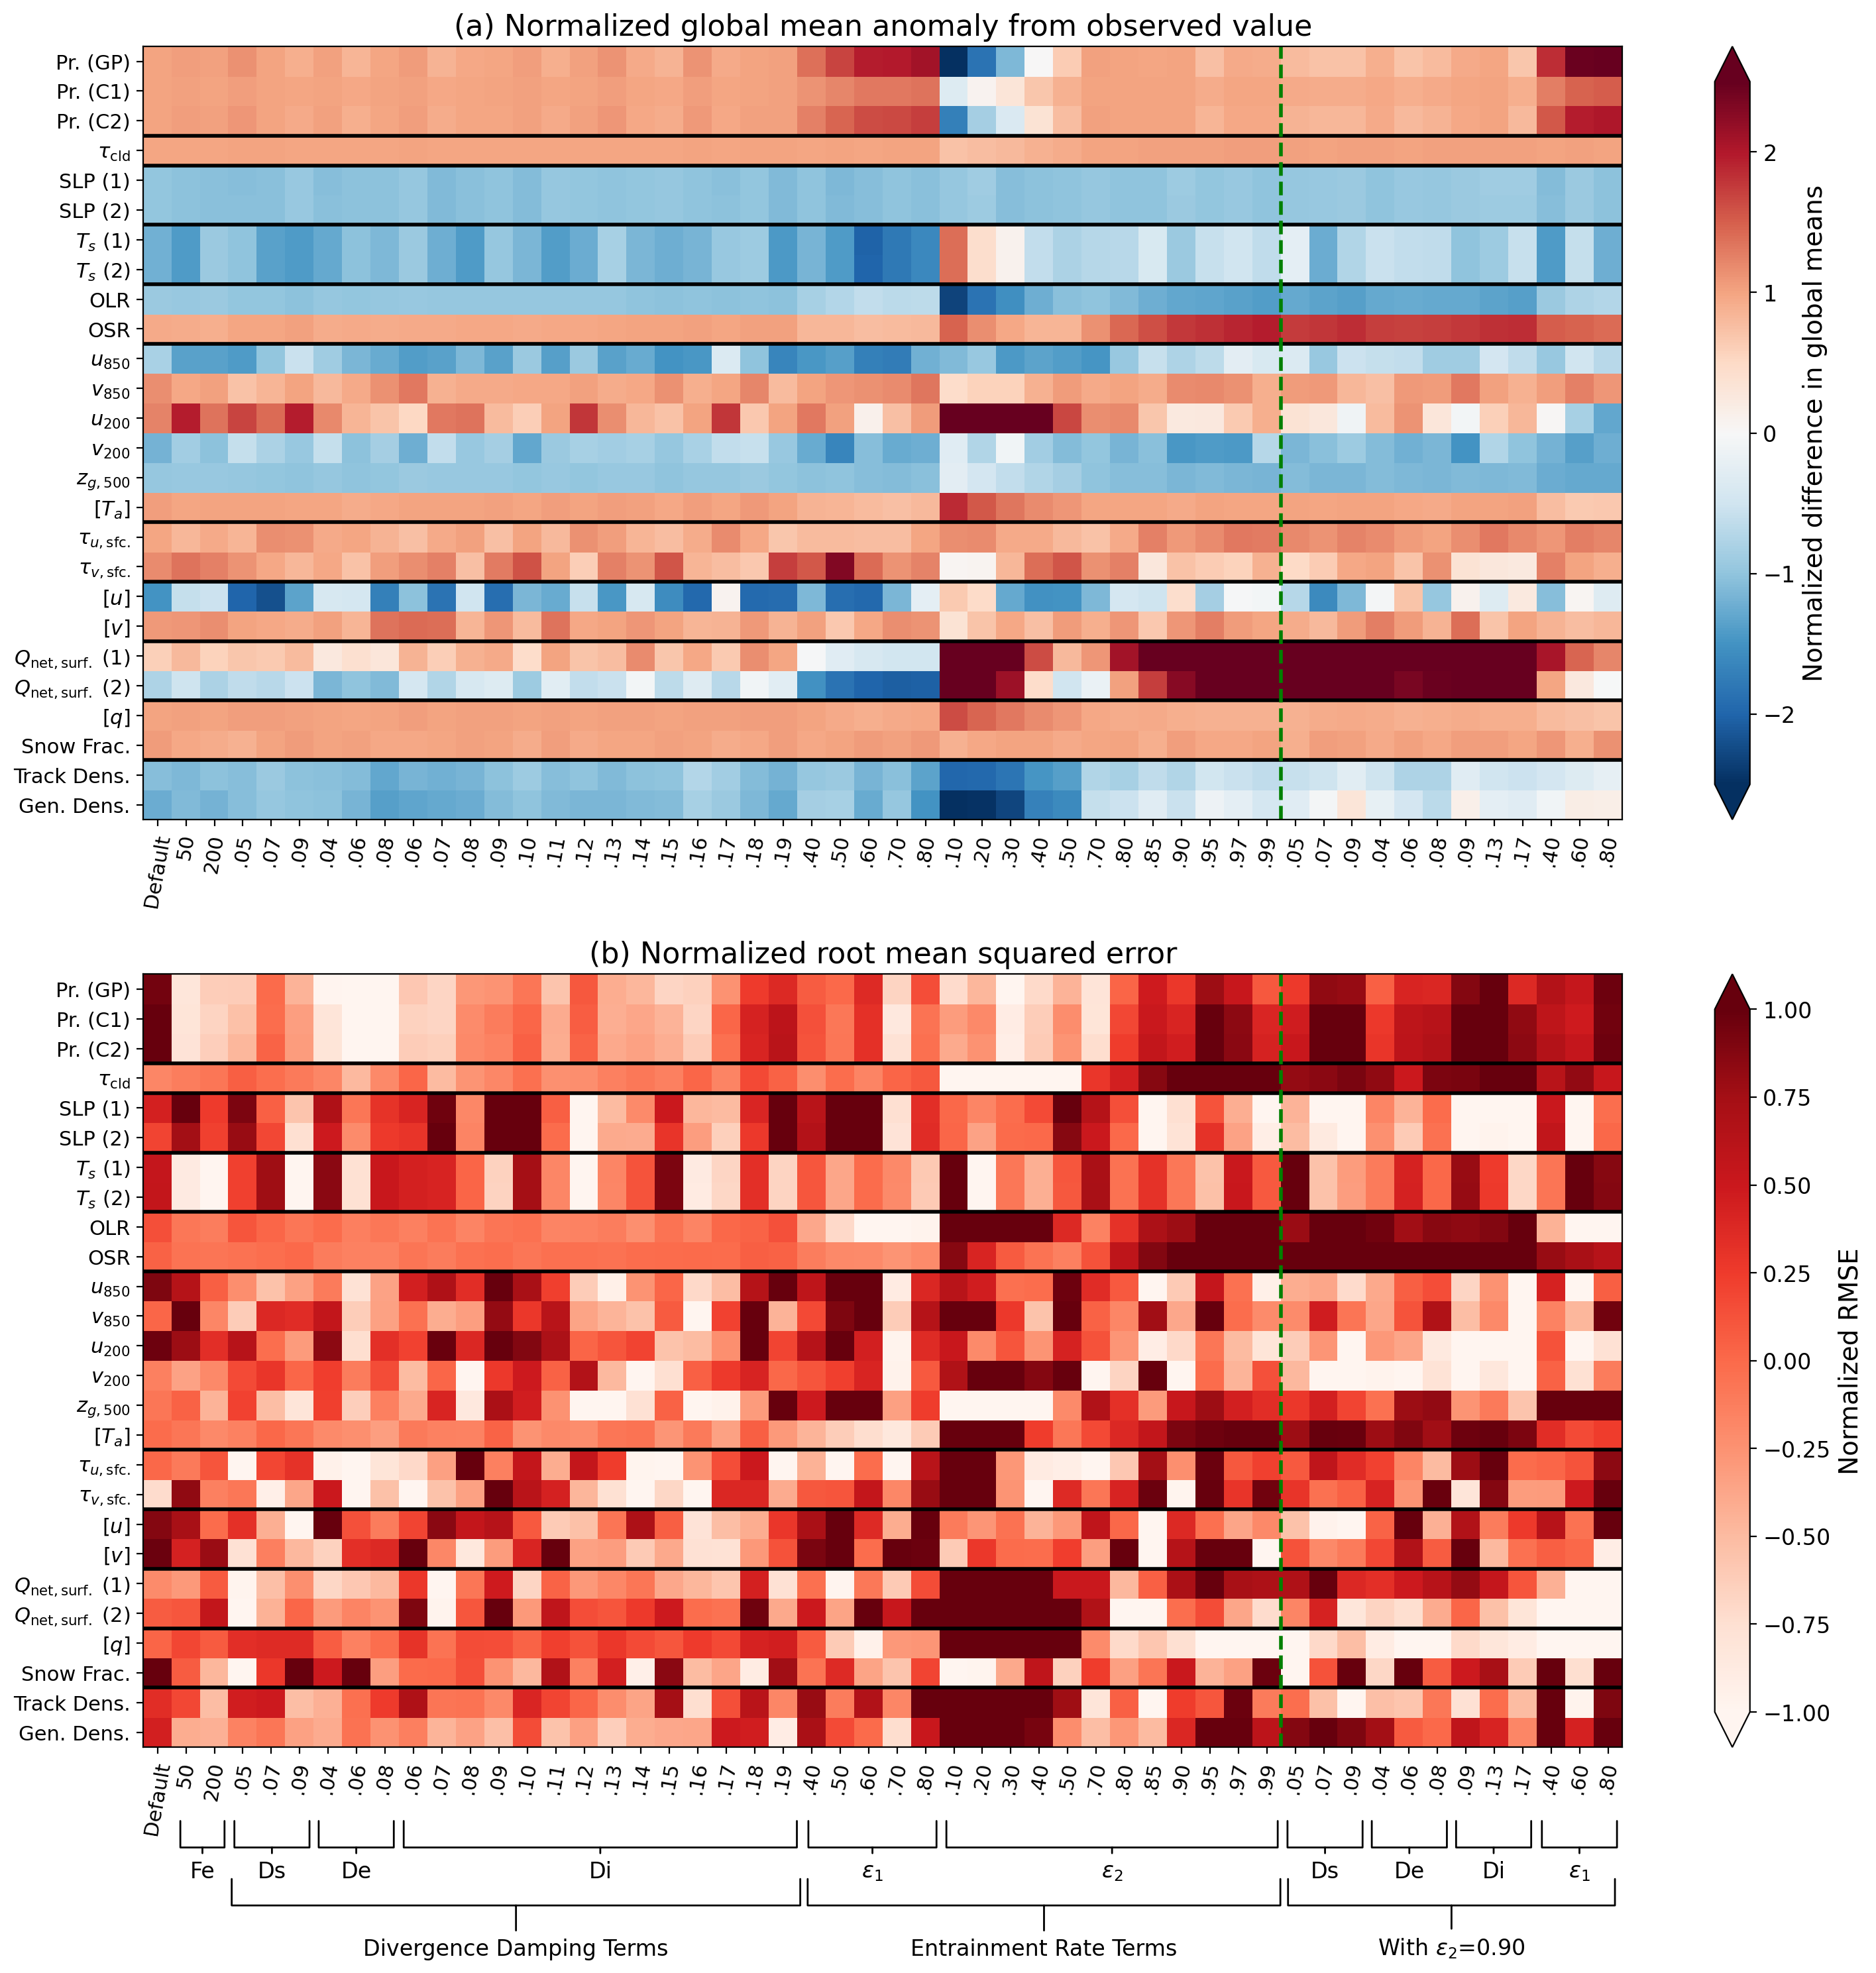

In [40]:
###. COMBINED plot: difference in global means (top), 
#    RMSE (lat. weighted) with REVERSE viridis (bottom)


plt.figure(figsize=(18,17), dpi=200)
plt.subplot(2,1,1) #Top: difference in global meansx
plotmat = np.flipud(norm_dgm)
print(plotmat)
print(plotmat[:,0])
plt.pcolor(plotmat, cmap = plt.cm.RdBu_r, 
           vmin=-2.5, vmax=2.5)
plt.title('(a) Normalized global mean anomaly from observed value', fontsize=16)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized difference in global means', fontsize=14)


# #Annotate the x axis labels with variable names
# ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

# ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


# ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


# ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


# ax.annotate('Ec', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

# ax.annotate('En', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


# ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


# ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


# ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


# ax.annotate('Ec', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#Skip 2nd row for this

#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

np.save('Figure_13a_data.npy', plotmat)



#Bottom: RMSE plot--REVERSE viridis
plt.subplot(2,1,2)

plotmat = np.flipud(norm_RMSE_w)
print(plotmat)
print(plotmat[:,0])
plt.pcolor(plotmat, cmap = plt.cm.Reds, 
           vmin=-1, vmax=1)
plt.title('(b) Normalized root mean squared error', fontsize=16)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(52)+0.5)
ax.set_xticklabels(fnums)
plt.xticks(rotation=80)
cbar = plt.colorbar(extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized RMSE', fontsize=14)

#Annotate the x axis labels with variable names
ax.annotate('Fe', xy=(0.04, -0.125), xytext=(0.04, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=1.2', lw=1.0))

ax.annotate('Ds', xy=(0.087, -0.125), xytext=(0.087, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.144, -0.125), xytext=(0.144, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.309, -0.125), xytext=(0.309, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=1.2', lw=1.0))


ax.annotate('$\epsilon_1$', xy=(0.493, -0.125), xytext=(0.493, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=1.2', lw=1.0))

ax.annotate('$\epsilon_2$', xy=(0.655, -0.125), xytext=(0.655, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.5, lengthB=1.2', lw=1.0))


ax.annotate('Ds', xy=(0.799, -0.125), xytext=(0.799, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('De', xy=(0.856, -0.125), xytext=(0.856, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('Di', xy=(0.913, -0.125), xytext=(0.913, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))


ax.annotate('$\epsilon_1$', xy=(0.971, -0.125), xytext=(0.971, -0.175), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.7, lengthB=1.2', lw=1.0))

#2nd row, more descriptive
ax.annotate('Divergence Damping Terms', xy=(0.252, -0.2), xytext=(0.252, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.87, lengthB=1.2', lw=1.0))

ax.annotate('Entrainment Rate Terms', xy=(0.609, -0.2), xytext=(0.609, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=10.7, lengthB=1.2', lw=1.0))

ax.annotate('With $\epsilon_2$=0.90', xy=(0.8845, -0.2), xytext=(0.8845, -0.275), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=7.4, lengthB=1.2', lw=1.0))


#Horizontal dashed lines separating the different types of dependent variables
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 52, linestyles='solid', linewidth=2, colors='k')

plt.vlines([40], 
           0, 26, linestyles='dashed', linewidth=2, colors='g')

#plt.tight_layout() This messes up the annotation

#plt.savefig('plots/double_error_matrix_plot.png', bbox_inches='tight')
#plt.savefig('plots/double_error_matrix_plot.pdf', bbox_inches='tight')

#Version with epsilon 1/2 instead of Ec/En

#plt.savefig('plots/double_error_matrix_plot_epsilon.png', bbox_inches='tight')
#plt.savefig('plots/double_error_matrix_plot_epsilon.pdf', bbox_inches='tight')

#Version with bigger text in titles, one line
plt.savefig('plots/double_error_matrix_plot_biglabel.png', bbox_inches='tight')
plt.savefig('plots/double_error_matrix_plot_biglabel.pdf', bbox_inches='tight')

np.save('Figure_13b_data.npy', plotmat)


In [48]:
#Test map plots

In [34]:
def plot_obs_def_test(ds_dict, var, test):
    plotmat_obs = np.transpose(ds_dict[var].sel(tname='20YearTest')[var].data)
    plotmat_def = np.transpose(ds_dict[var].sel(tname='20YearTest')[E3_vnames[var]].data)
    plotmat_test = np.transpose(ds_dict[var].sel(tname=test)[E3_vnames[var]].data)
    
    plt.subplot(2,3,1)
    cset = plt.contourf(plotmat_obs)
    plt.colorbar()
    levels = cset.levels
    plt.title(var+'\n(observed)')
    
    plt.subplot(2,3,2)
    plt.contourf(plotmat_def, levels=levels, extend='both')
    plt.colorbar()
    plt.title(E3_vnames[var]+'\n(20YearTest)')
    
    plt.subplot(2,3,3)
    plt.contourf(plotmat_test, levels=levels, extend='both')
    plt.colorbar()
    plt.title(E3_vnames[var]+'\n('+test+')')
    
    #Difference plots, 2nd row: default - obs, test - obs, test - default. All symmetrical colormaps
    plt.subplot(2,3,4)
    plotmat_4 = plotmat_def - plotmat_obs
    mx = np.max(np.abs([np.nanmin(plotmat_4), np.nanmax(plotmat_4)]))
    plt.contourf(plotmat_4, levels=np.linspace(-mx, mx, 21), cmap=plt.cm.RdBu_r)
    plt.colorbar()
    plt.title('20YearTest - observed')
    
    plt.subplot(2,3,5)
    plotmat_5 = plotmat_test - plotmat_obs
    mx = np.max(np.abs([np.nanmin(plotmat_5), np.nanmax(plotmat_5)]))
    plt.contourf(plotmat_5, levels=np.linspace(-mx, mx, 21), cmap=plt.cm.RdBu_r)
    plt.colorbar()
    plt.title(test+' - observed')
    
    
    plt.subplot(2,3,6)
    plotmat_6 = plotmat_test - plotmat_def
    mx = np.max(np.abs([np.nanmin(plotmat_6), np.nanmax(plotmat_6)]))
    plt.contourf(plotmat_6, levels=np.linspace(-mx, mx, 21), cmap=plt.cm.RdBu_r)
    plt.colorbar()
    plt.title(test+' - 20YearTest')
    
    plt.tight_layout()
    

In [35]:
#Test for both En090 and En010

Plotting 6-panel comparison for variable: GPCP_precip
Plotting 6-panel comparison for variable: CMAP_STD_precip
Plotting 6-panel comparison for variable: CMAP_EHD_precip
Plotting 6-panel comparison for variable: ISCCP_cldOptDep
Plotting 6-panel comparison for variable: ERA_I_slp
Plotting 6-panel comparison for variable: ICOADS_slp
Plotting 6-panel comparison for variable: CRUTEM_STD_tsurf
Plotting 6-panel comparison for variable: CRUTEM_EHD_tsurf
Plotting 6-panel comparison for variable: CERES_lwTOA
Plotting 6-panel comparison for variable: CERES_swTOA
Plotting 6-panel comparison for variable: ERA_I_850u
Plotting 6-panel comparison for variable: ERA_I_850v
Plotting 6-panel comparison for variable: ERA_I_200u
Plotting 6-panel comparison for variable: ERA_I_200v
Plotting 6-panel comparison for variable: ERA_I_500z
Plotting 6-panel comparison for variable: ERA_I_zonT
Plotting 6-panel comparison for variable: ICOADS_uStress
Plotting 6-panel comparison for variable: ICOADS_vStress
Plotting 

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Plotting 6-panel comparison for variable: CERES_OAFLUX_qnet
Plotting 6-panel comparison for variable: ERA_I_zonQ
Plotting 6-panel comparison for variable: NSIDC_snow
Plotting 6-panel comparison for variable: IBTRACS_trackDen
Plotting 6-panel comparison for variable: IBTRACS_genDen


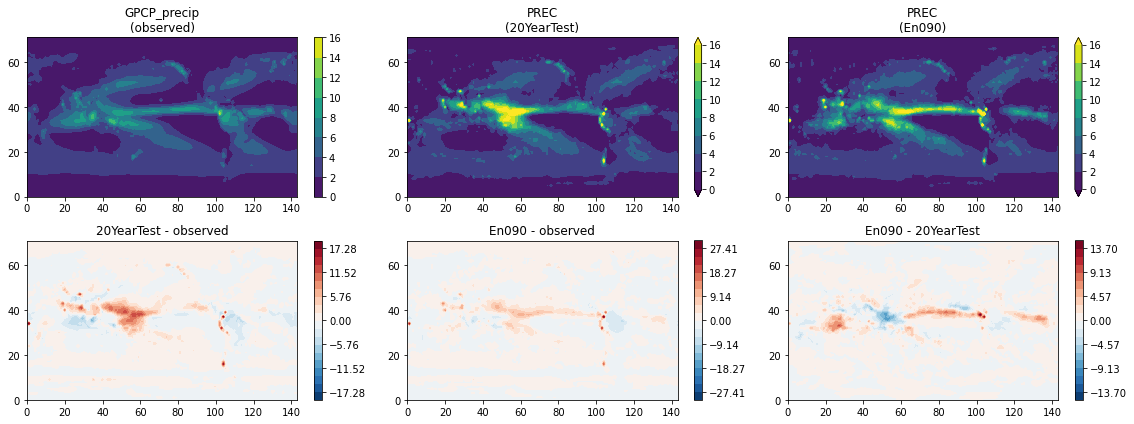

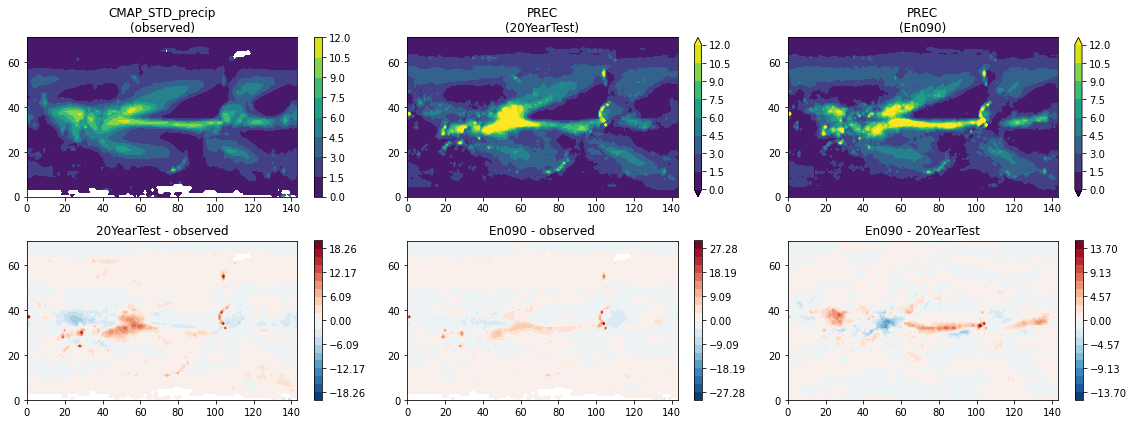

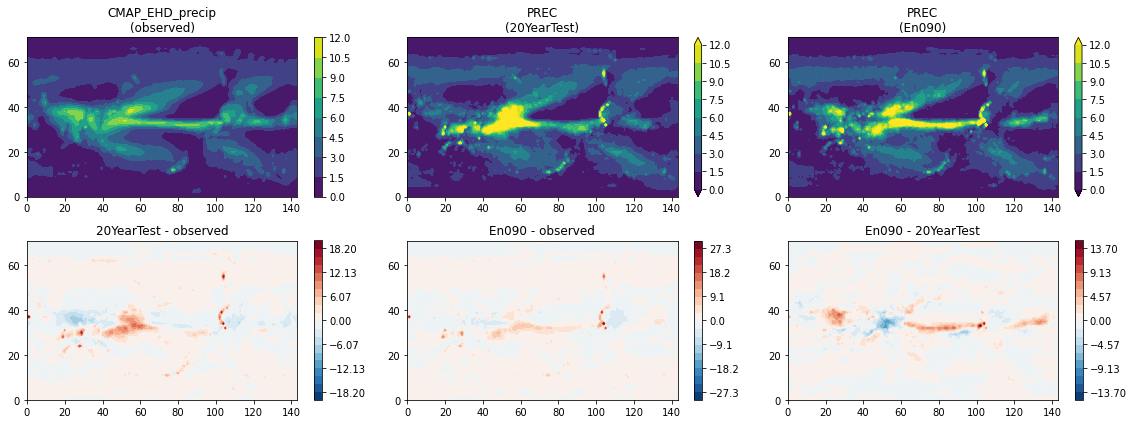

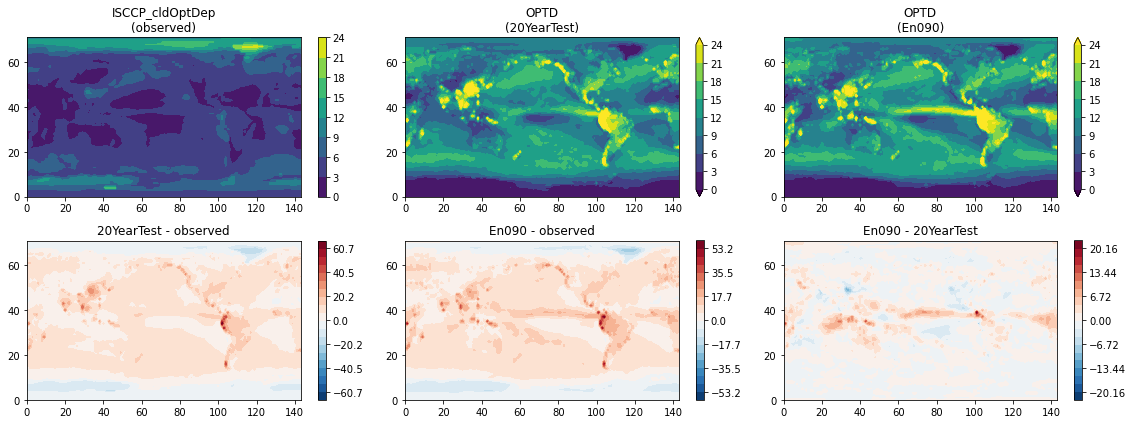

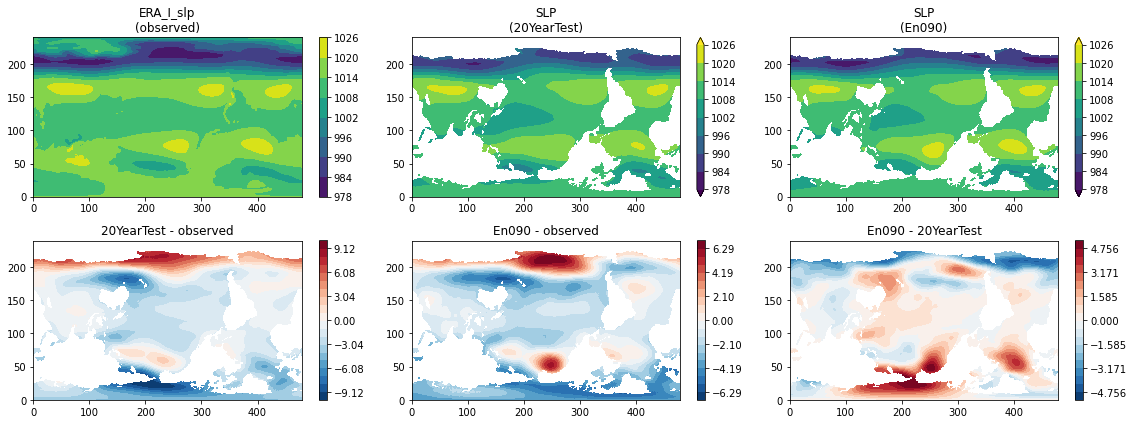

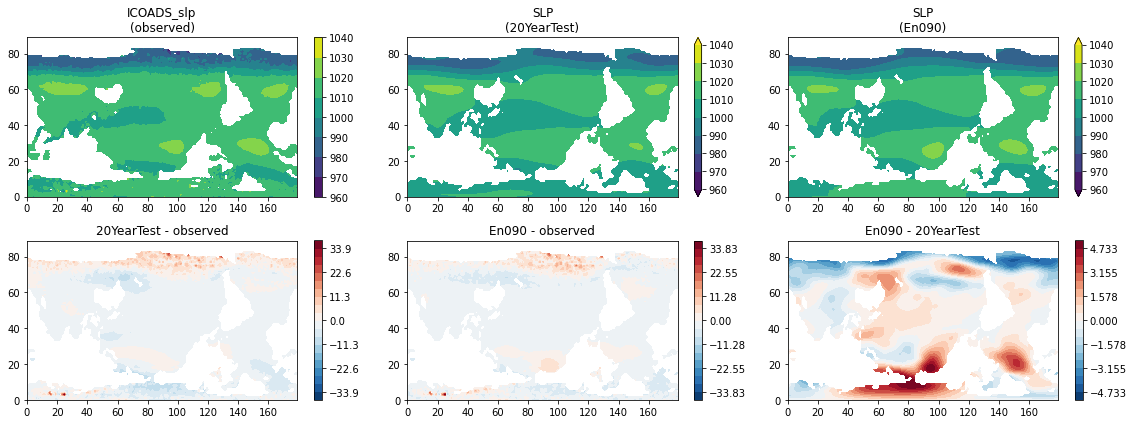

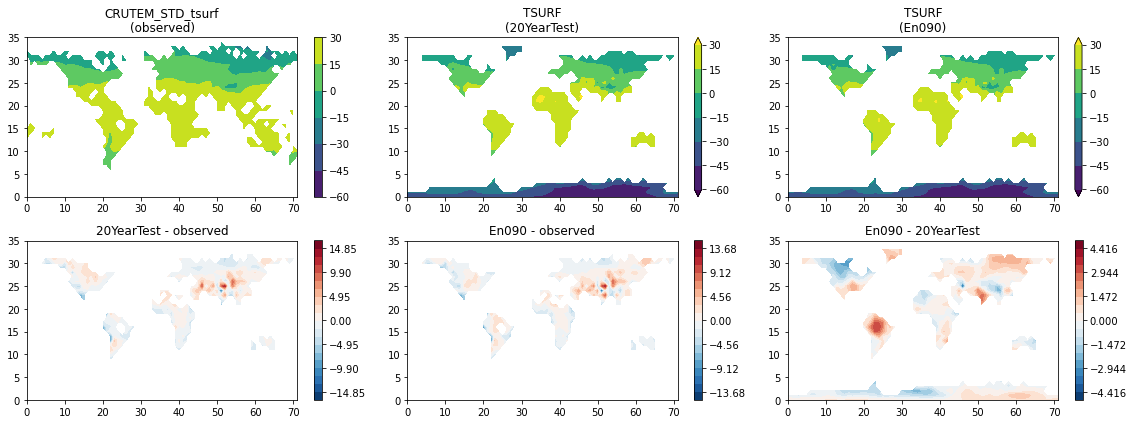

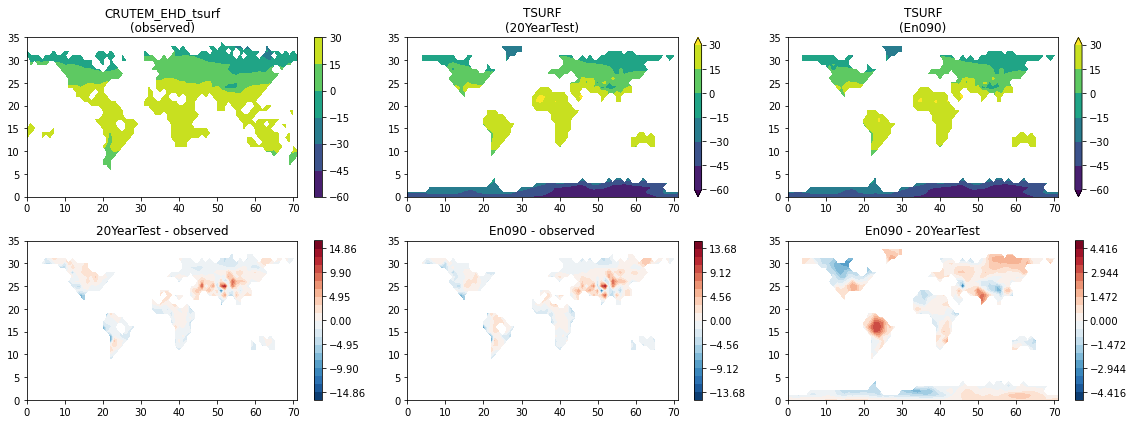

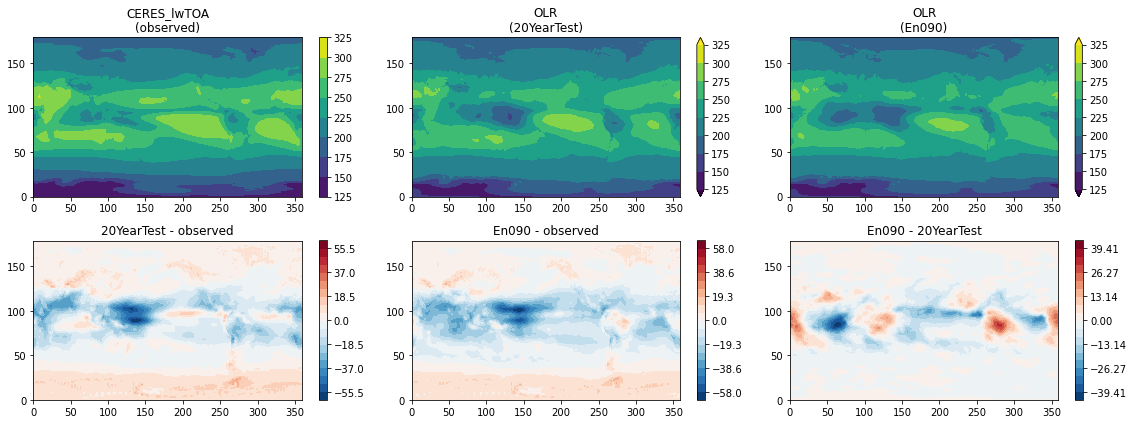

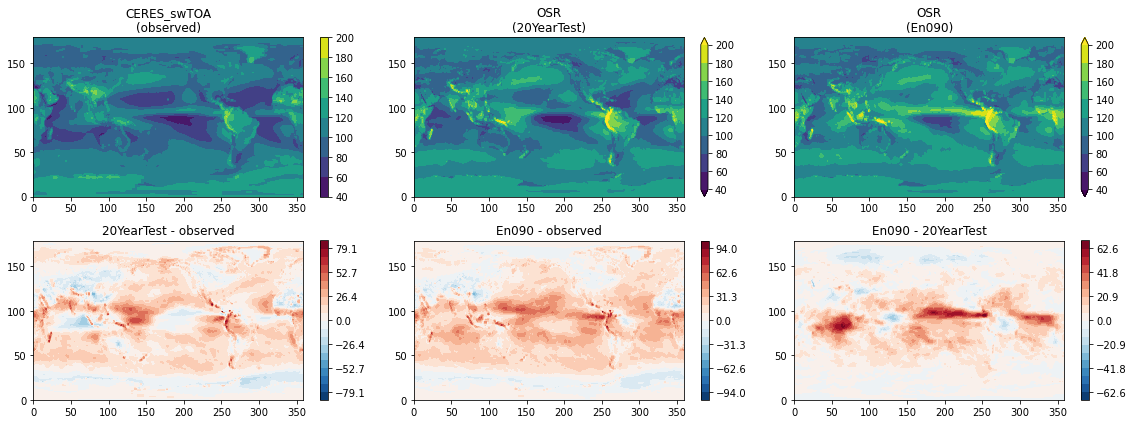

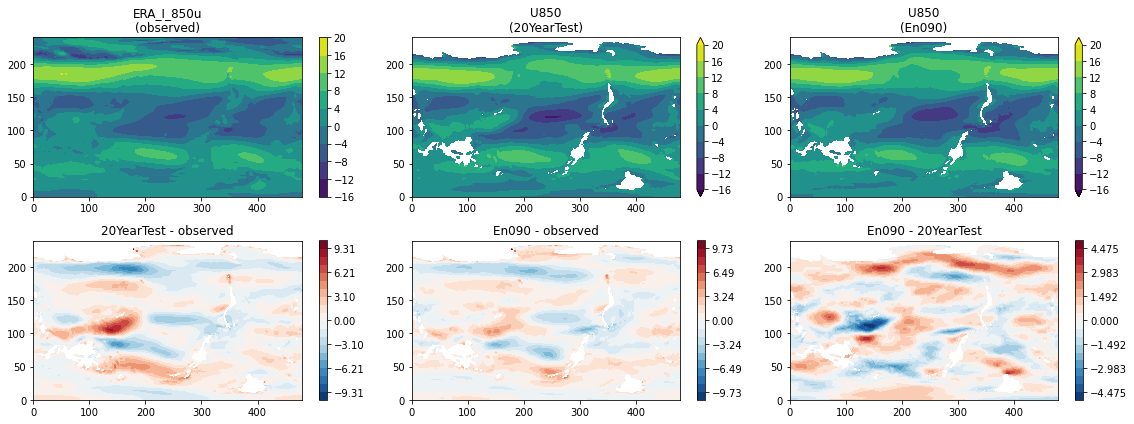

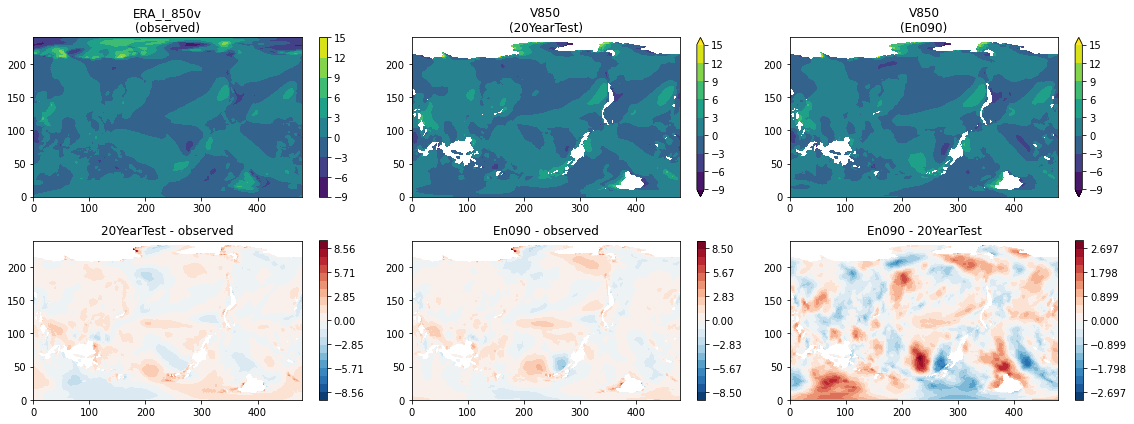

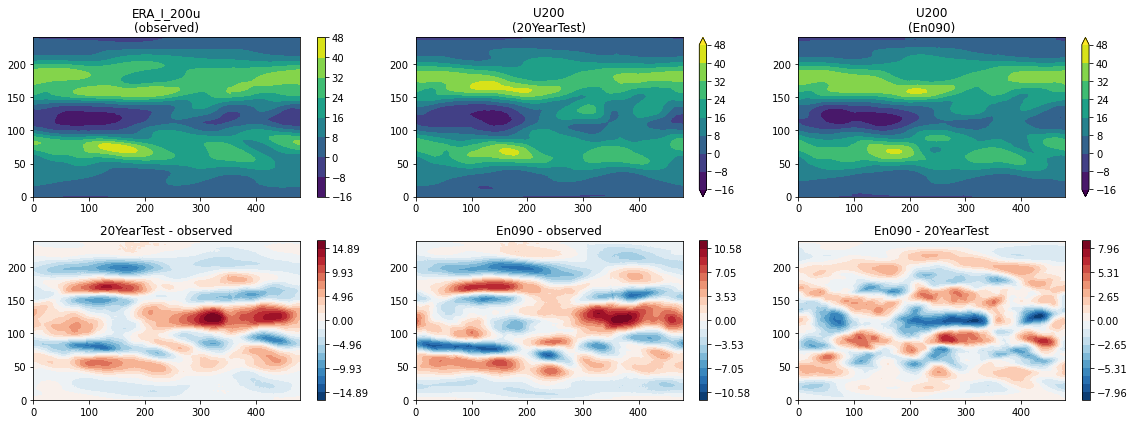

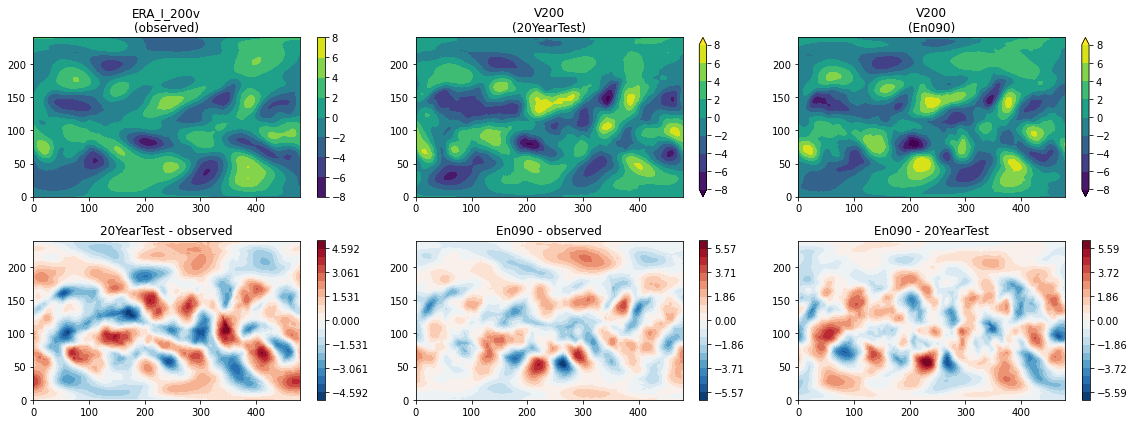

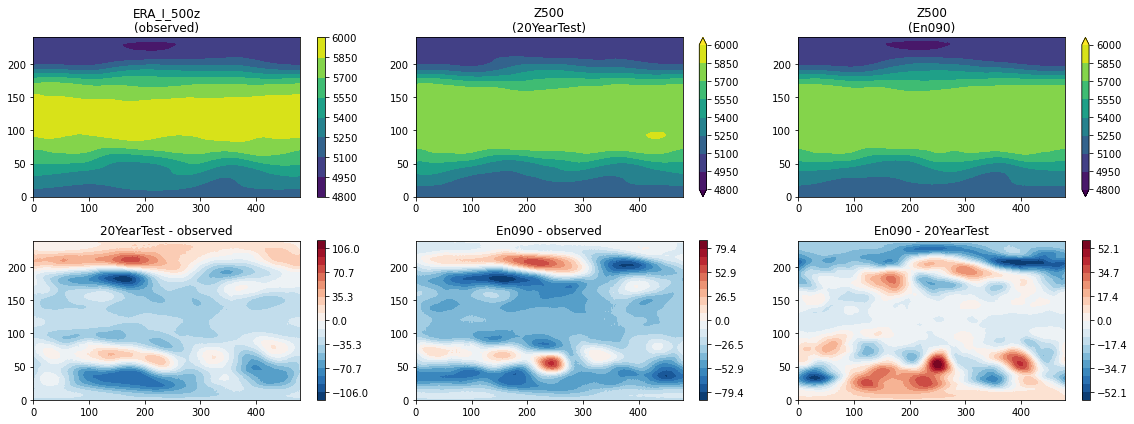

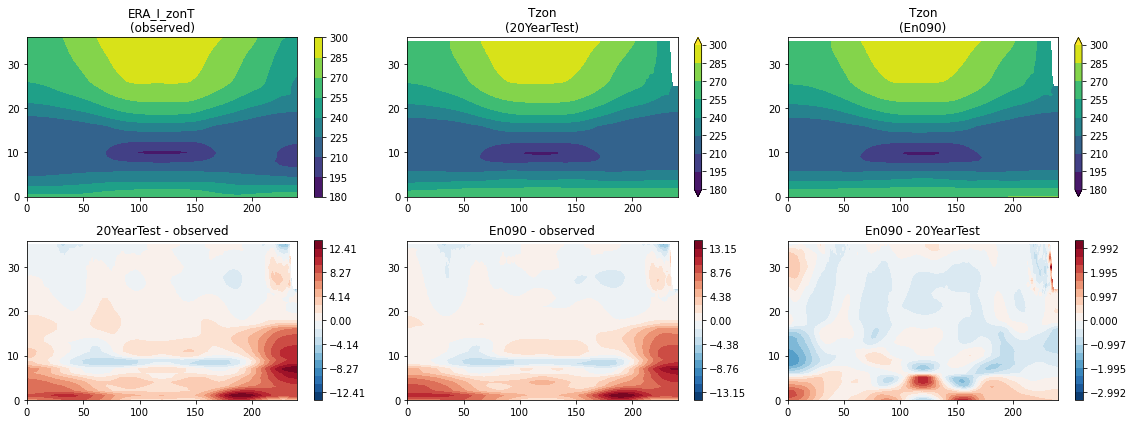

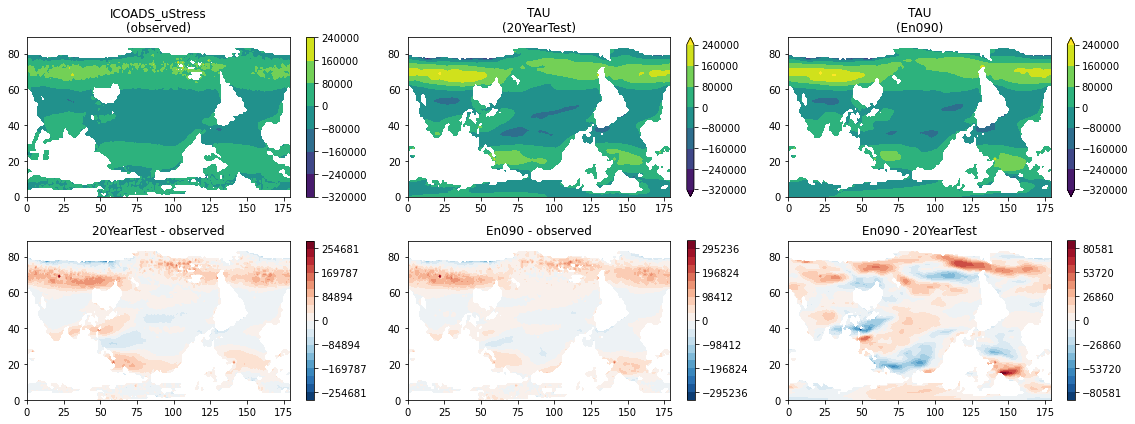

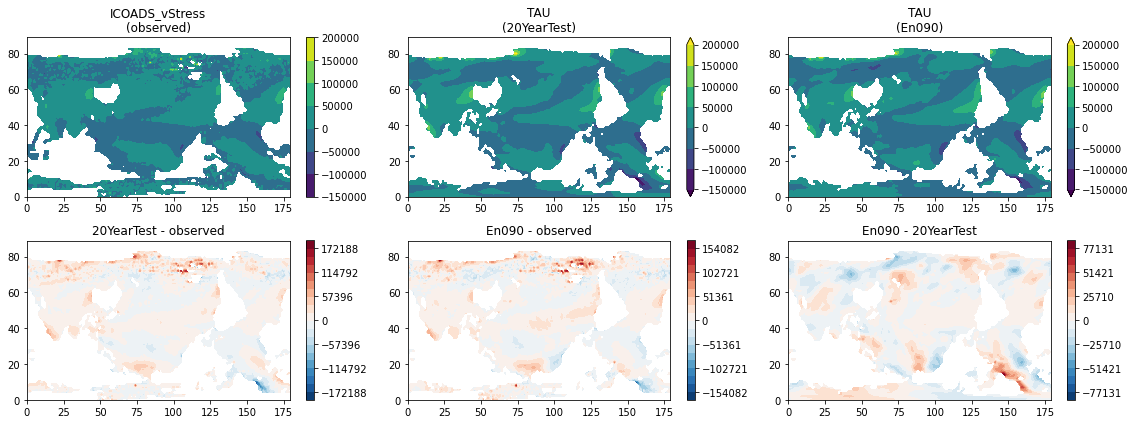

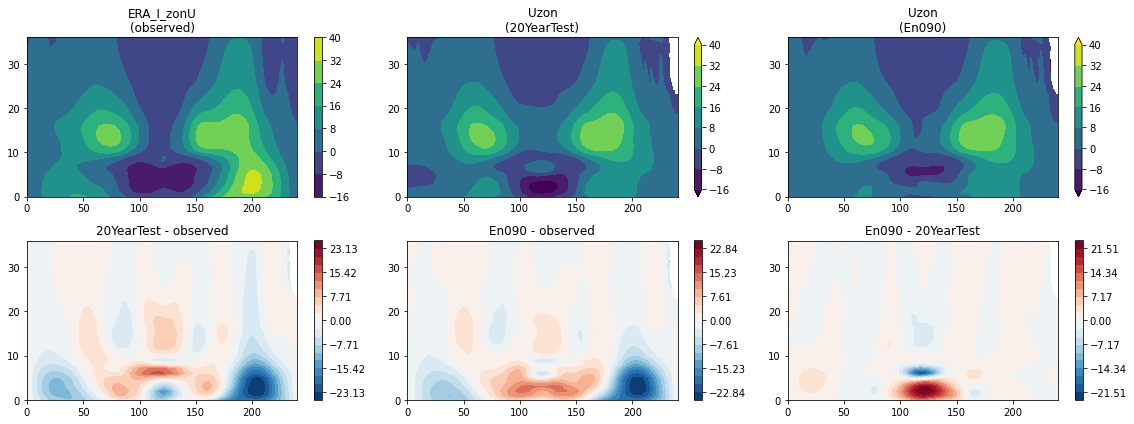

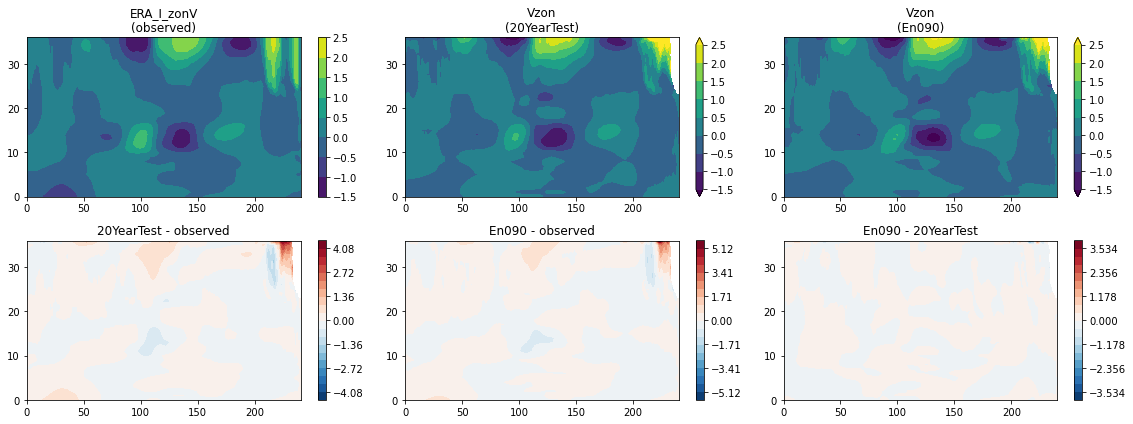

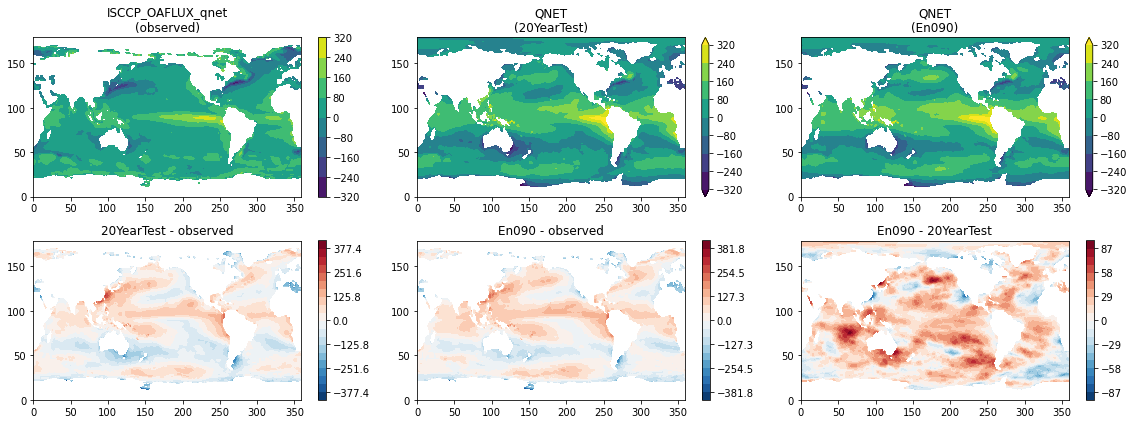

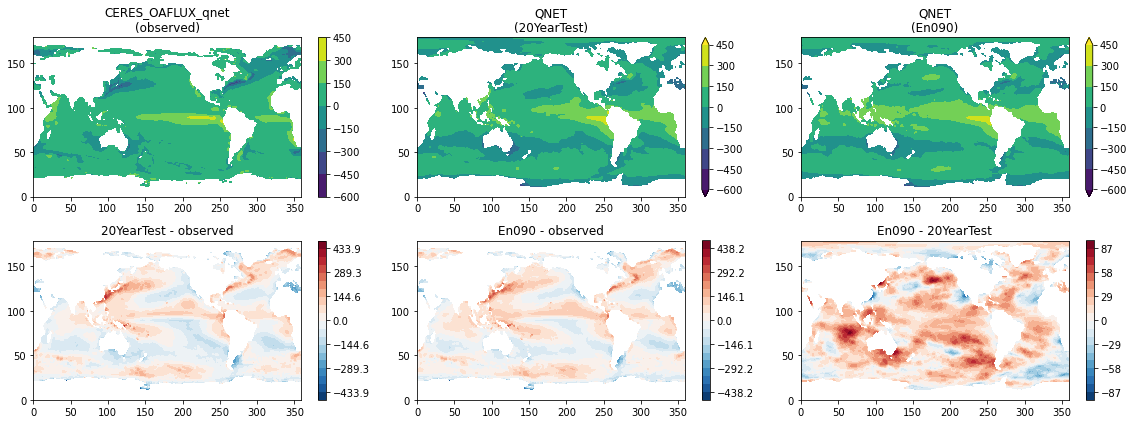

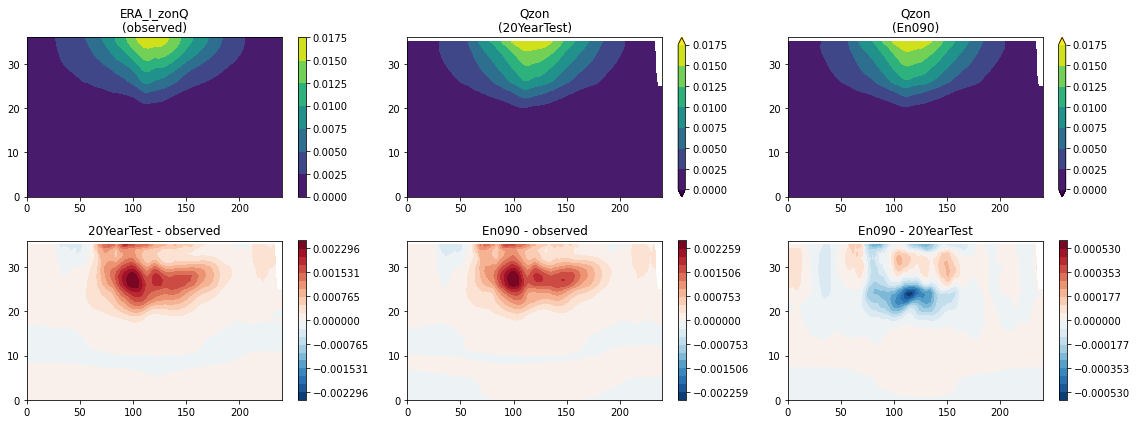

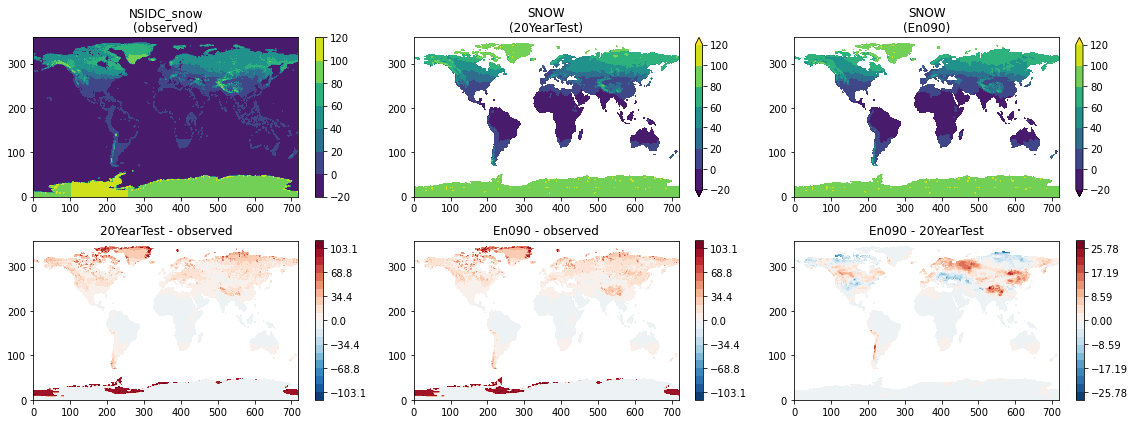

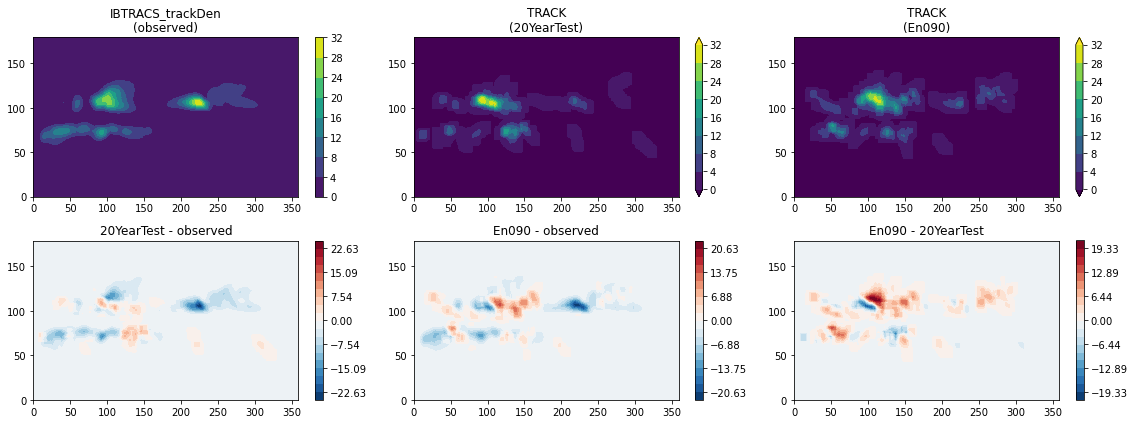

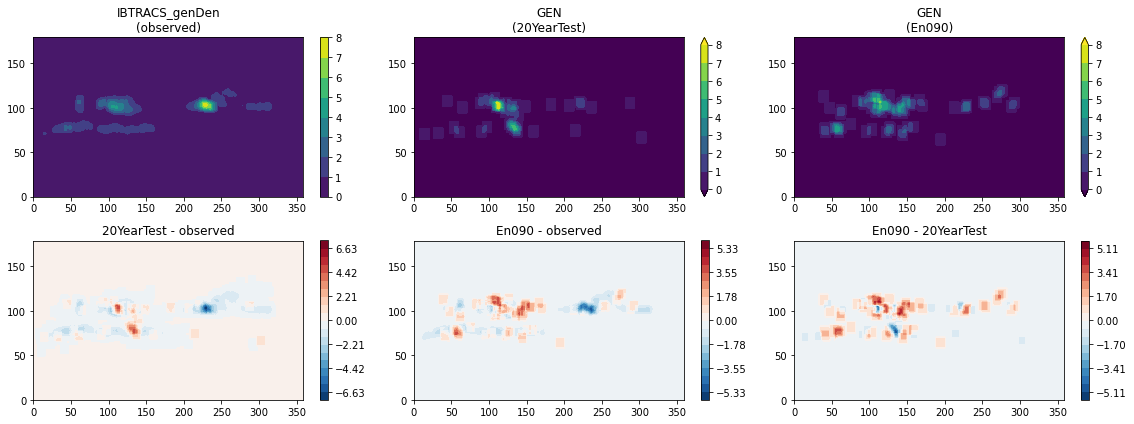

In [36]:
for v in vnames:
    print('Plotting 6-panel comparison for variable: ' + v)
    plt.figure(figsize=(16,6))
    plot_obs_def_test(mat_ds_dict, v, 'En090')
    plt.savefig('plots/obs_default_En090_'+v+'.png')

Plotting 6-panel comparison for variable: GPCP_precip
Plotting 6-panel comparison for variable: CMAP_STD_precip
Plotting 6-panel comparison for variable: CMAP_EHD_precip
Plotting 6-panel comparison for variable: ISCCP_cldOptDep
Plotting 6-panel comparison for variable: ERA_I_slp
Plotting 6-panel comparison for variable: ICOADS_slp
Plotting 6-panel comparison for variable: CRUTEM_STD_tsurf
Plotting 6-panel comparison for variable: CRUTEM_EHD_tsurf
Plotting 6-panel comparison for variable: CERES_lwTOA
Plotting 6-panel comparison for variable: CERES_swTOA
Plotting 6-panel comparison for variable: ERA_I_850u
Plotting 6-panel comparison for variable: ERA_I_850v
Plotting 6-panel comparison for variable: ERA_I_200u
Plotting 6-panel comparison for variable: ERA_I_200v
Plotting 6-panel comparison for variable: ERA_I_500z
Plotting 6-panel comparison for variable: ERA_I_zonT
Plotting 6-panel comparison for variable: ICOADS_uStress
Plotting 6-panel comparison for variable: ICOADS_vStress
Plotting 

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Plotting 6-panel comparison for variable: CERES_OAFLUX_qnet
Plotting 6-panel comparison for variable: ERA_I_zonQ
Plotting 6-panel comparison for variable: NSIDC_snow
Plotting 6-panel comparison for variable: IBTRACS_trackDen
Plotting 6-panel comparison for variable: IBTRACS_genDen


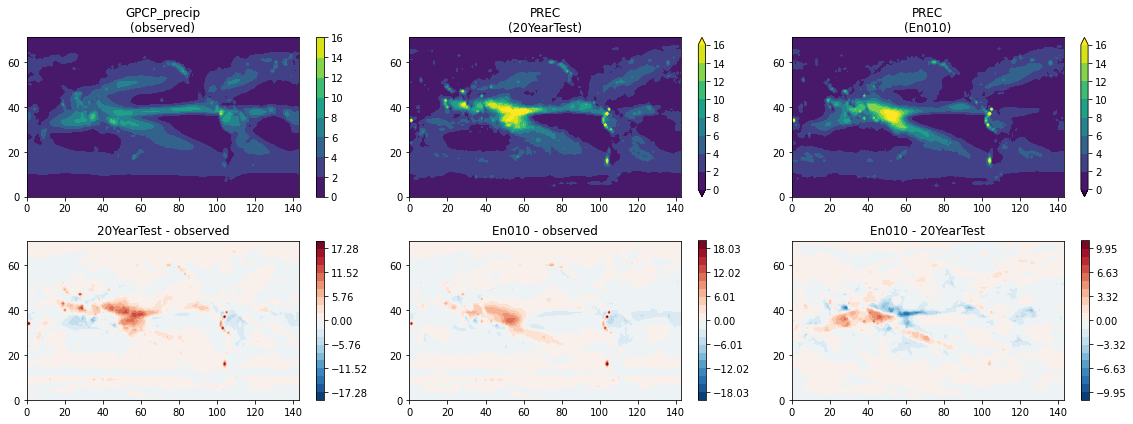

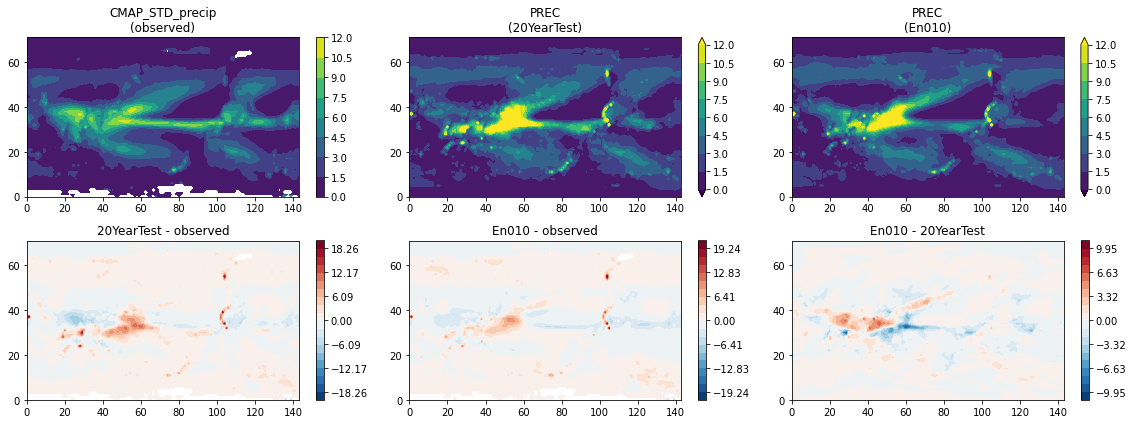

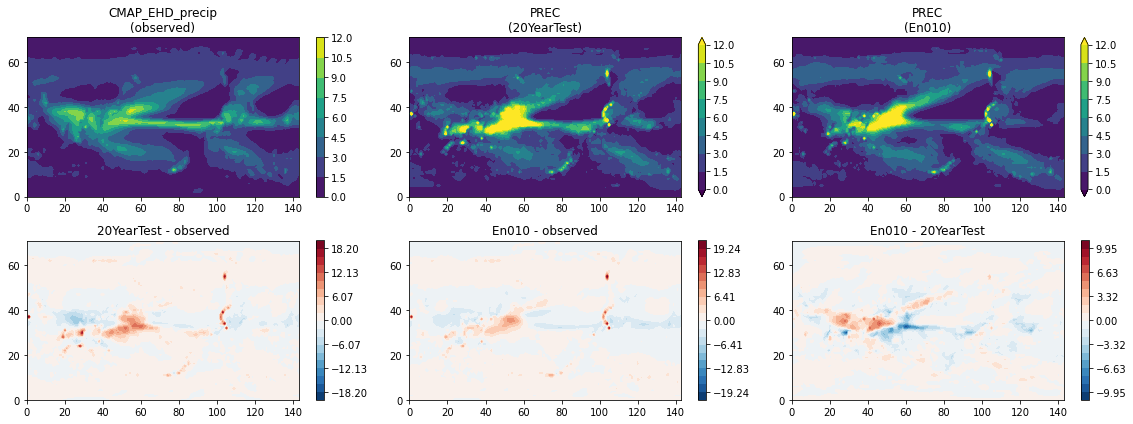

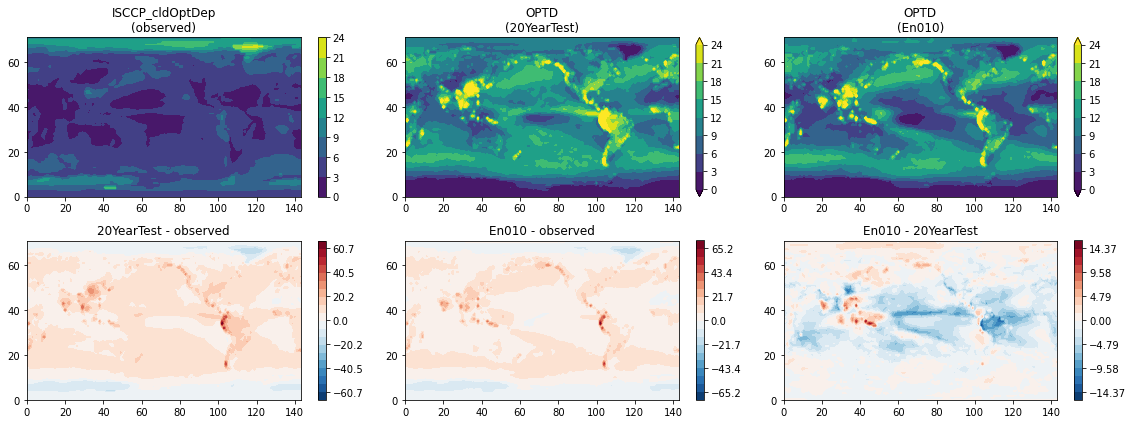

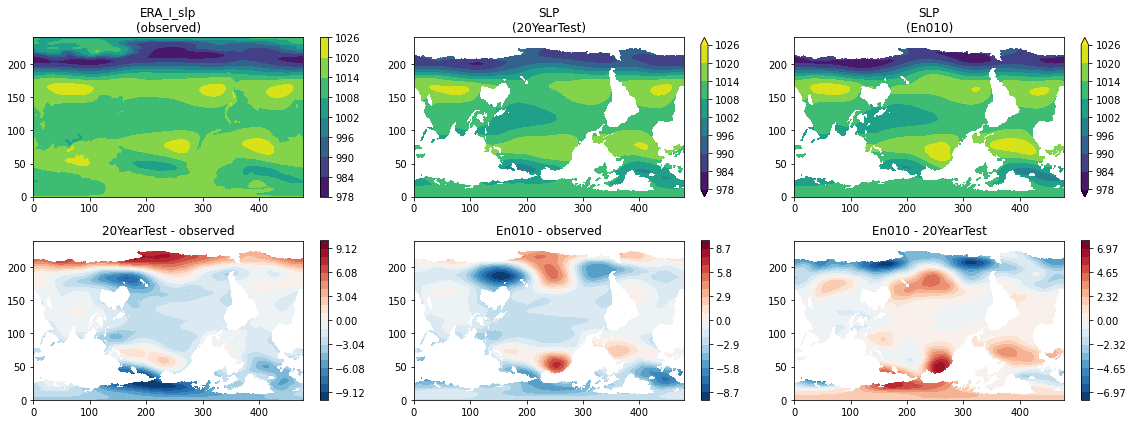

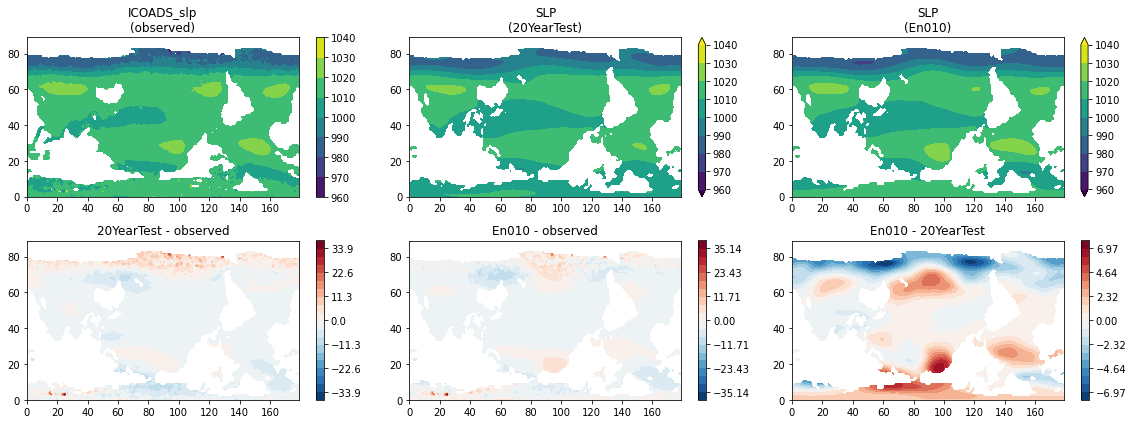

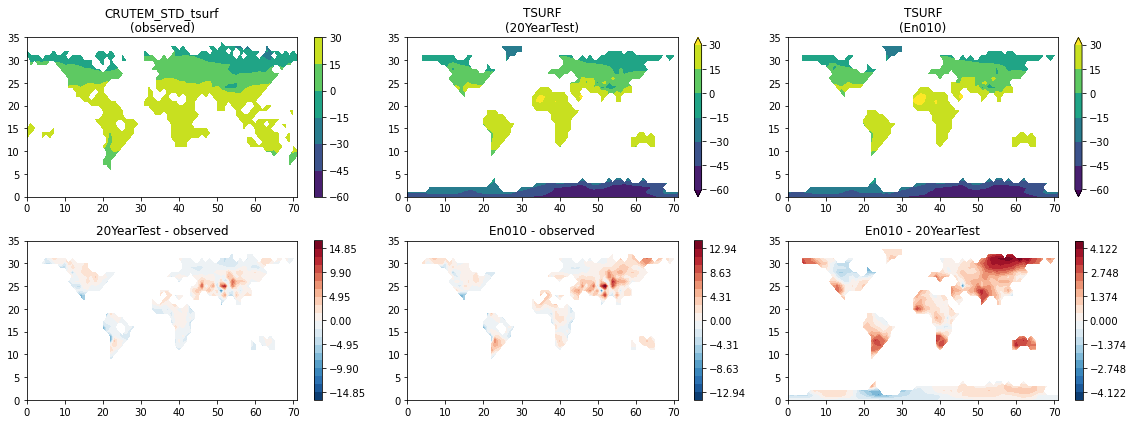

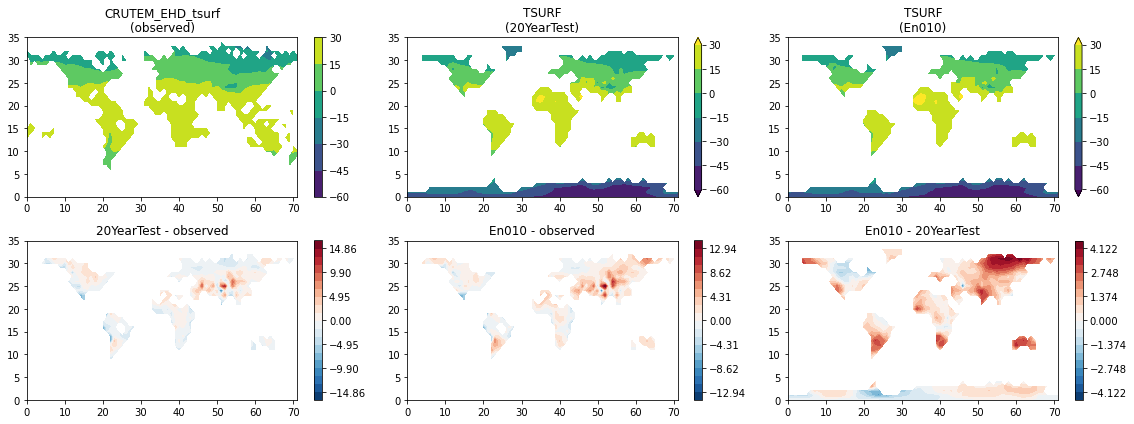

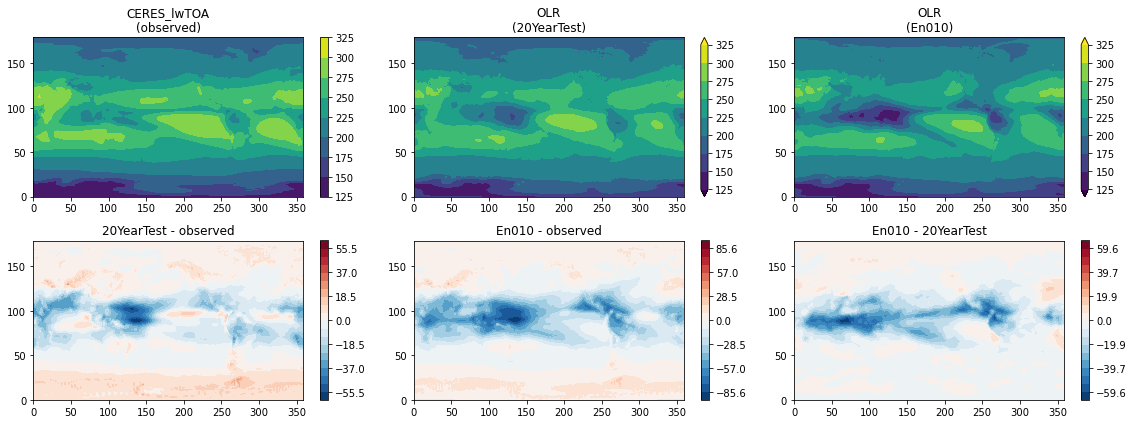

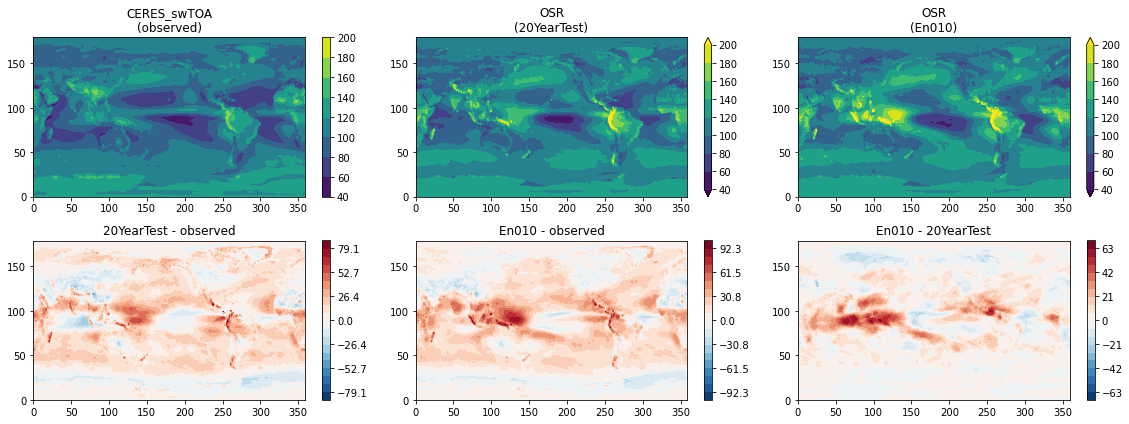

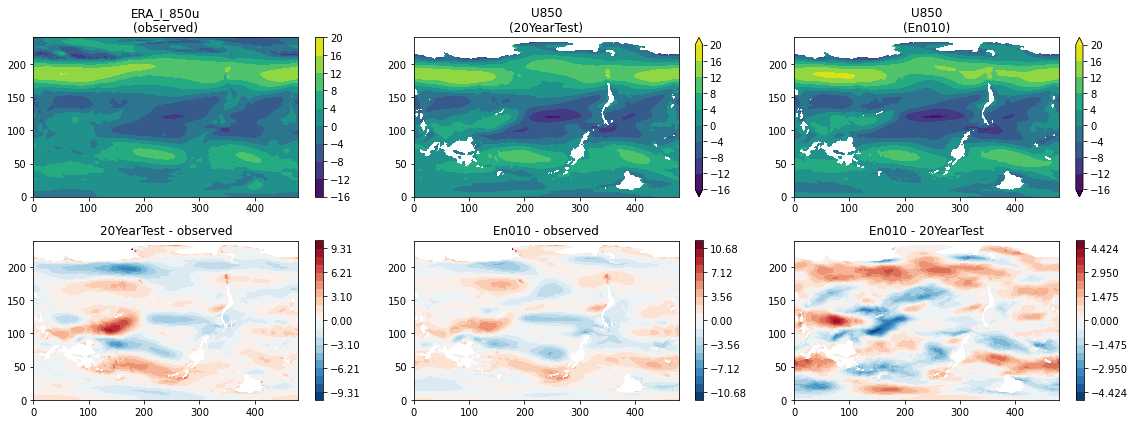

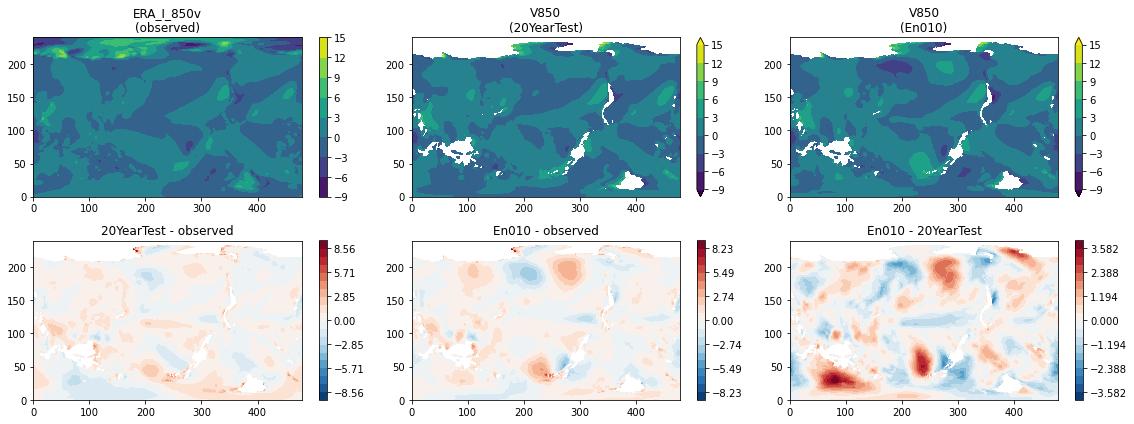

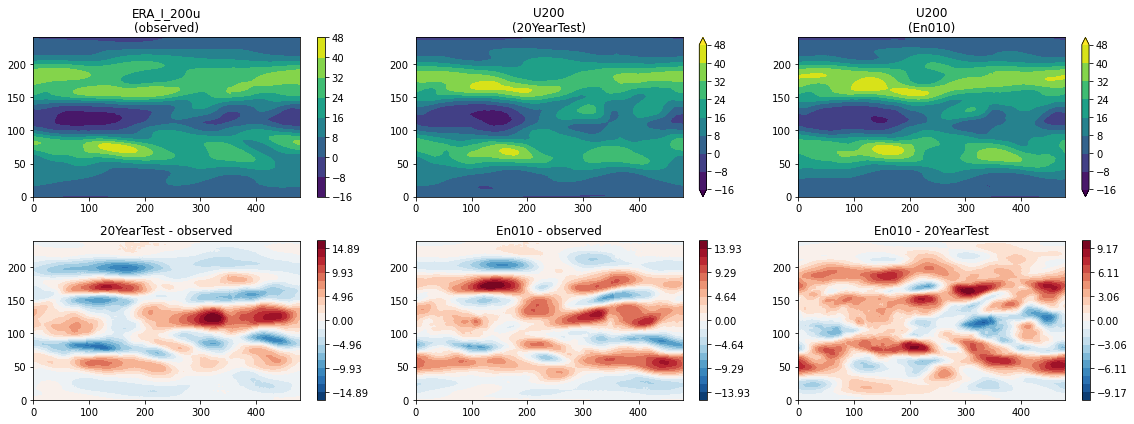

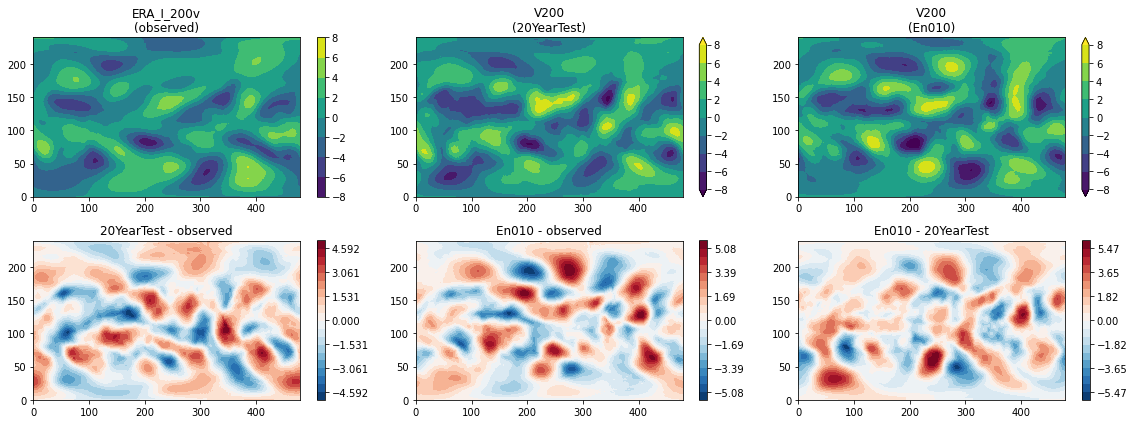

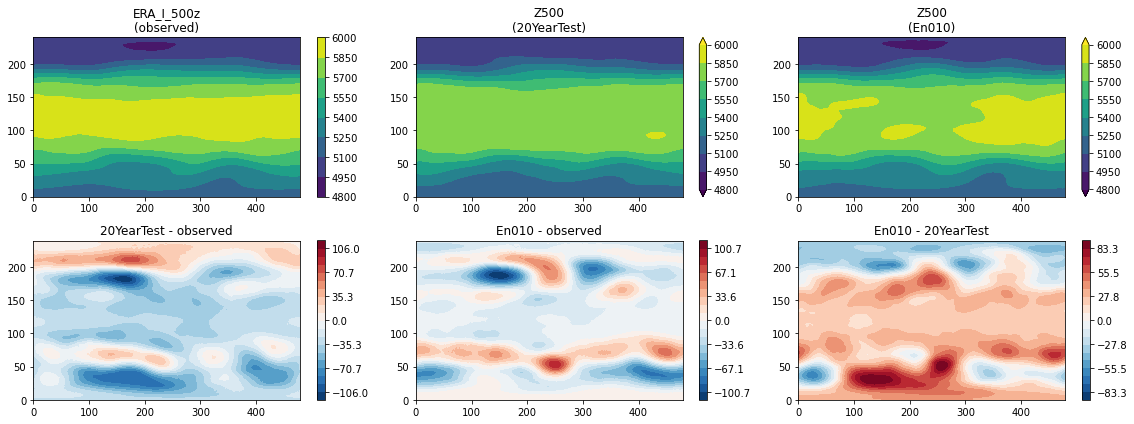

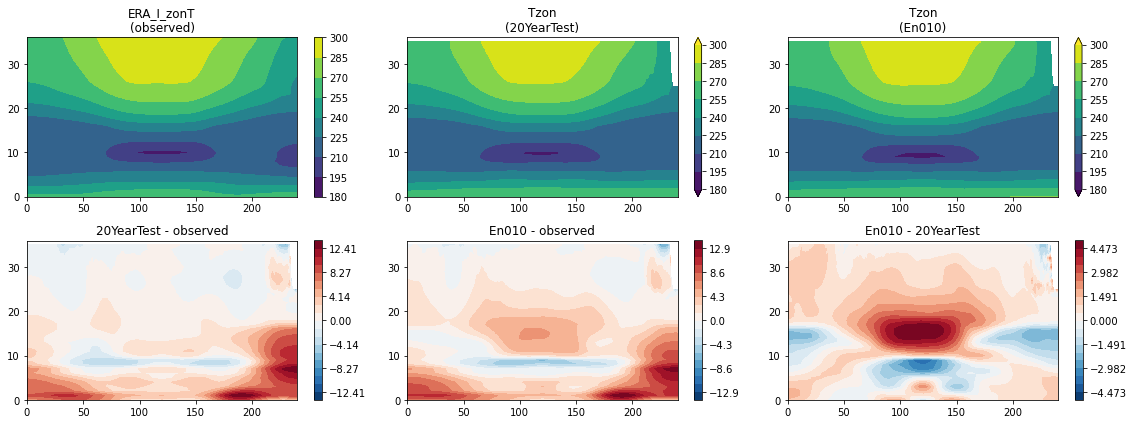

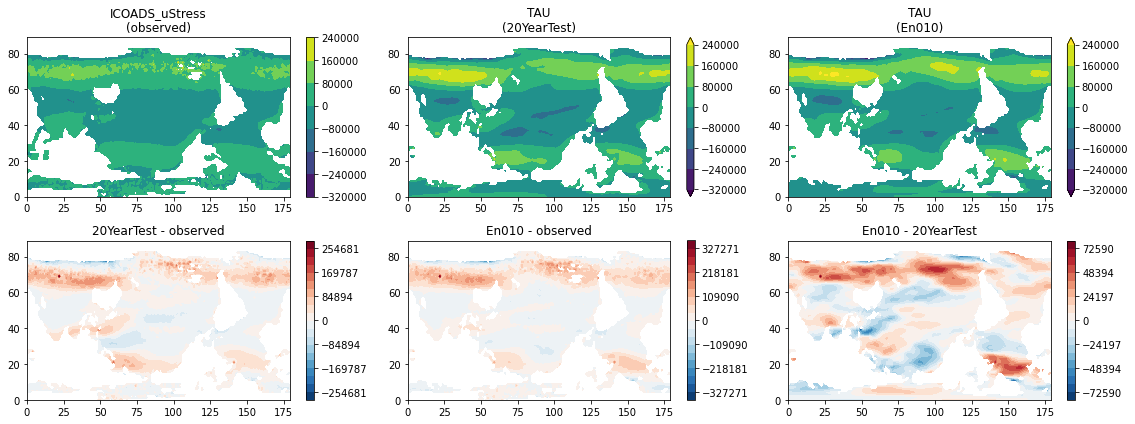

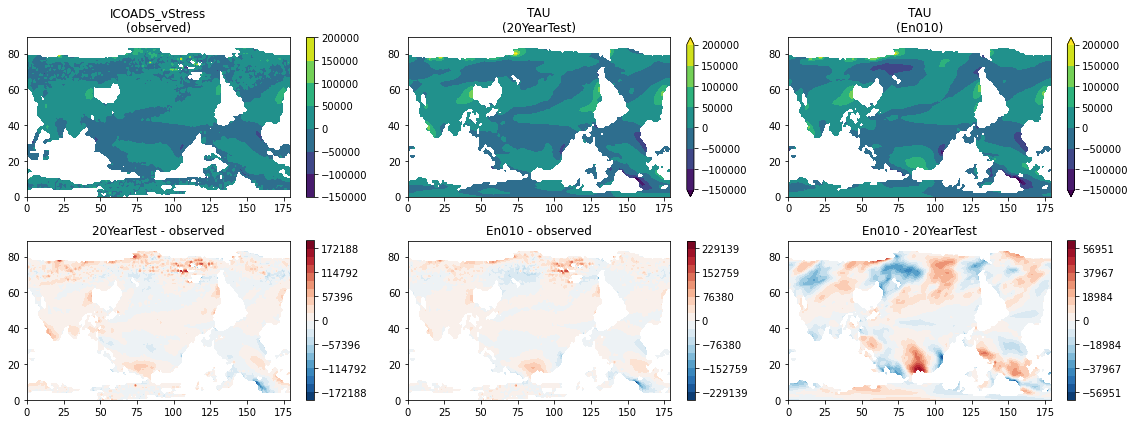

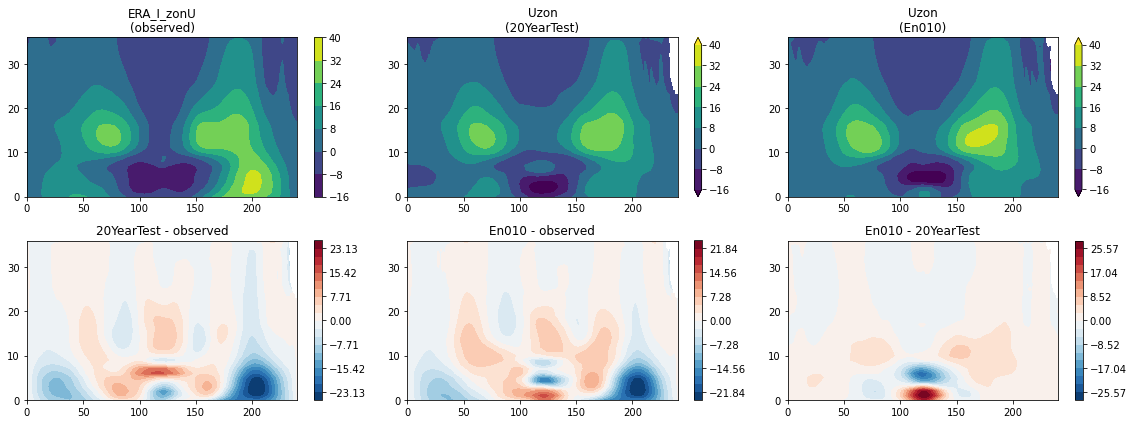

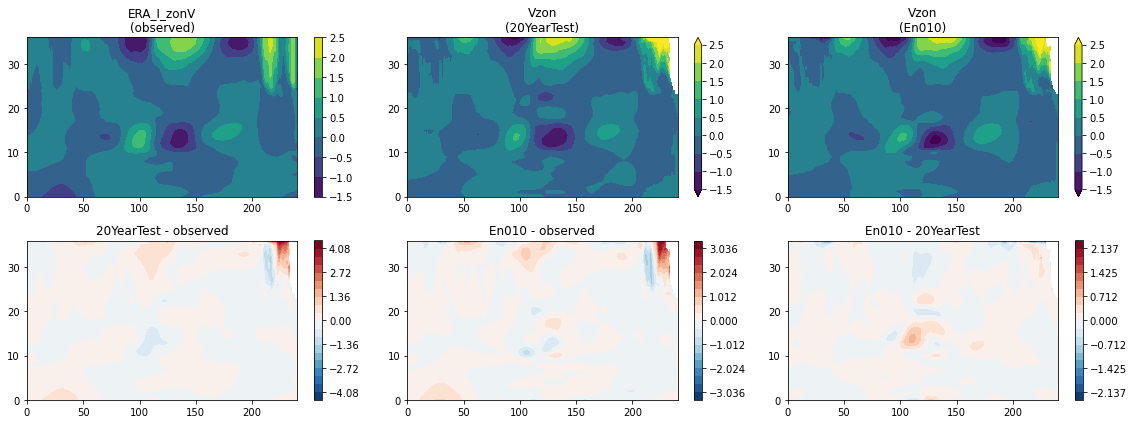

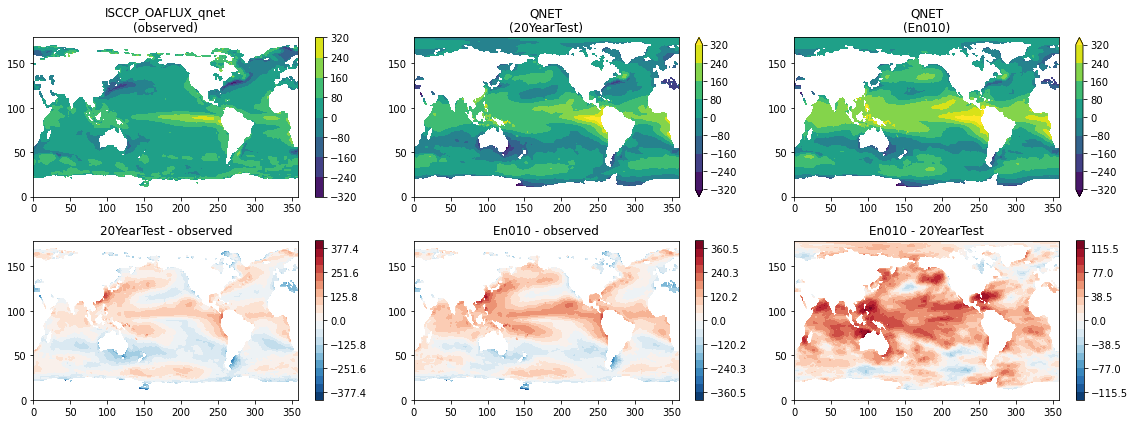

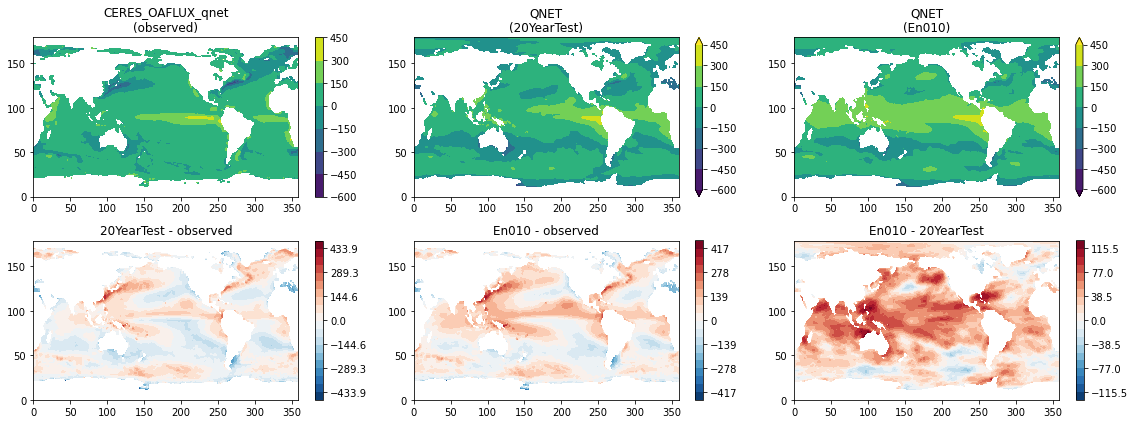

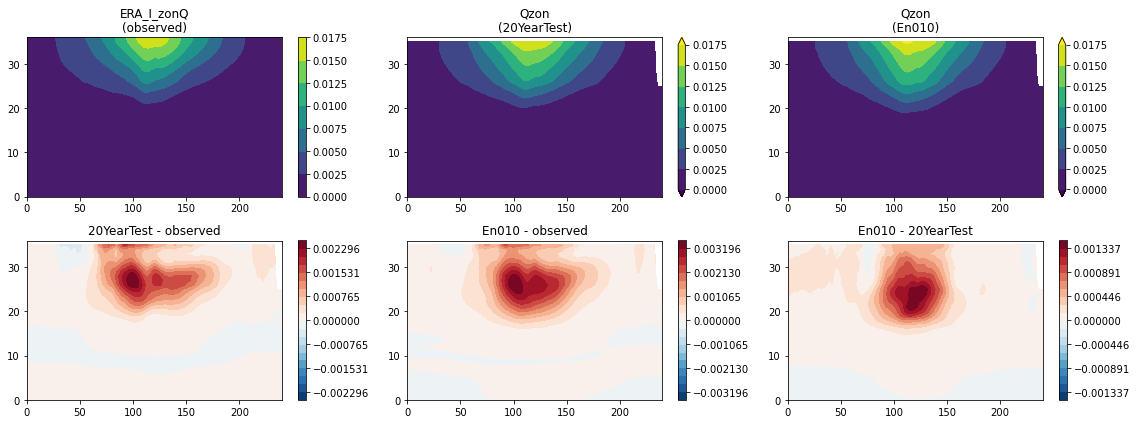

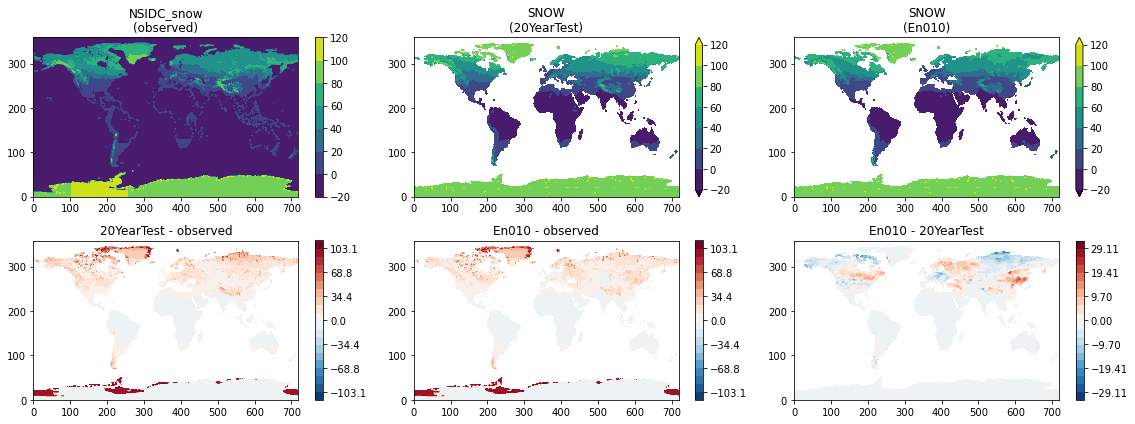

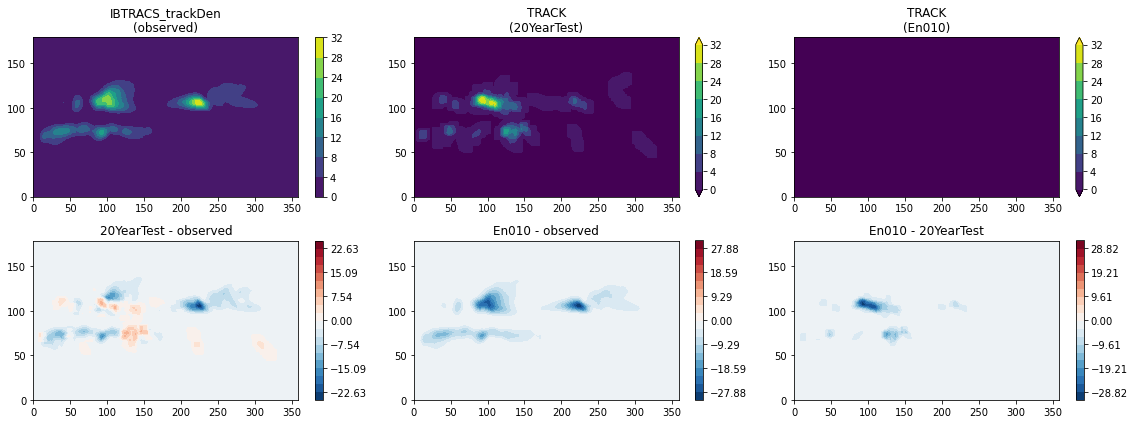

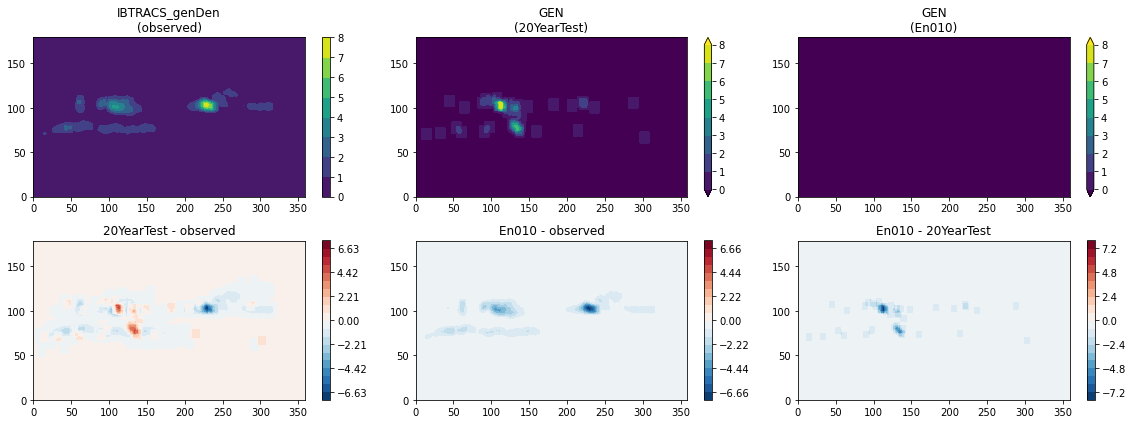

In [37]:
for v in vnames:
    print('Plotting 6-panel comparison for variable: ' + v)
    plt.figure(figsize=(16,6))
    plot_obs_def_test(mat_ds_dict, v, 'En010')
    plt.savefig('plots/obs_default_En010_'+v+'.png')